# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline




In [2]:
# Global parameters

# Gaussian smoothing
kernel_size = 3

# Canny Edge Detector
low_threshold = 50
high_threshold = 150

# Region-of-interest vertices
trap_bottom_width = 0.85  
trap_top_width = 0.07  
trap_height = 0.4  

# Hough Transform
rho = 2 
theta = 1 * np.pi/180 
threshold = 15     
min_line_length = 10 
max_line_gap = 20    

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


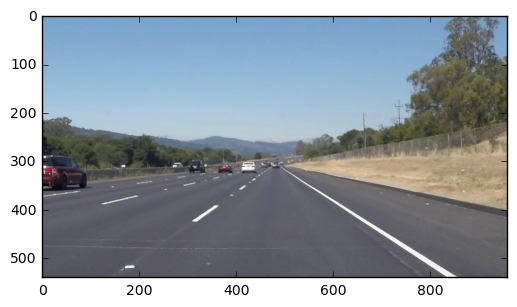

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

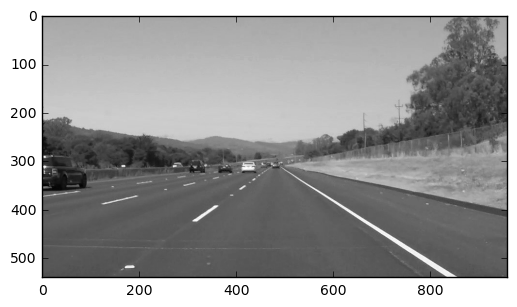

In [4]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = grayscale(image)
plt.imshow(gray, cmap='gray') 

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [6]:
import math
import pandas

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

############################################

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

############################################

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
  ##########################################################
       
            
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)




################################

def remove_outliers(slopes, m = 2):
    med = np.mean(slopes)
    stand_dev = np.std(slopes)
    for slope in slopes:
        if abs(slope - med) > (m * stand_dev):
            slopes.remove(slope)
    return slopes

def lane_lines(img):
    #Gray-scale
    gray = grayscale(img)
    
    #Smooth it a bit with Gaussian Blur
    kernel_size = 9
    blur_gray = gaussian_blur(gray, kernel_size)
    
    #Canny Edge 
    low_threshold = 90
    high_threshold = 180
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Masking
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 325), (550, 325), (imshape[1],imshape[0])]], dtype=np.int32)  
    masked_edges = region_of_interest(edges, vertices)

    # Hough transform 
    rho = 5 
    theta = np.pi/30 
    threshold = 50     
    min_line_len = 25 
    max_line_gap = 25    
    line_image = np.copy(img)*0 

    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
    
    left_lines = []
    left_slopes = []
    right_lines = []
    right_slopes = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope < 0:
                left_lines.append(line)
                left_slopes.append(slope)
            else:
                right_lines.append(line)
                right_slopes.append(slope)
    
    #Average line 
    avg_left_pos = [sum(col)/len(col) for col in zip(*left_lines)]
    avg_right_pos = [sum(col)/len(col) for col in zip(*right_lines)]
    
    avg_left_slope = np.mean(remove_outliers(left_slopes))
    avg_right_slope = np.mean(remove_outliers(right_slopes))
    
    for x1,y1,x2,y2 in avg_left_pos:
        x = int(np.mean([x1, x2])) 
        y = int(np.mean([y1, y2])) 
        slope = avg_left_slope
        b = -(slope * x) + y 
        avg_left_line = [int((325-b)/slope), 325, int((539-b)/slope), 539] #Line for the image 
    
    avg_right_line = []
    for x1,y1,x2,y2 in avg_right_pos:
        x = int(np.mean([x1, x2]))
        y = int(np.mean([y1, y2]))
        slope = avg_right_slope
        b = -(slope * x) + y
        avg_right_line = [int((325-b)/slope), 325, int((539-b)/slope), 539]
    
    lines = [[avg_left_line], [avg_right_line]]
    
    draw_lines(line_image, lines)

    line_edges = weighted_img(line_image, img)
    
    return line_edges

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

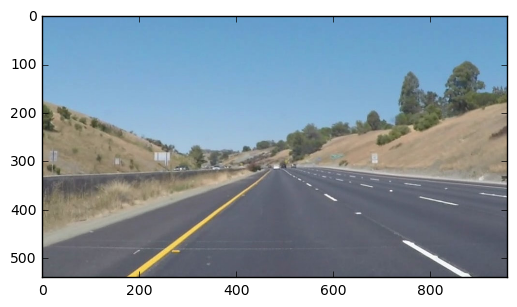

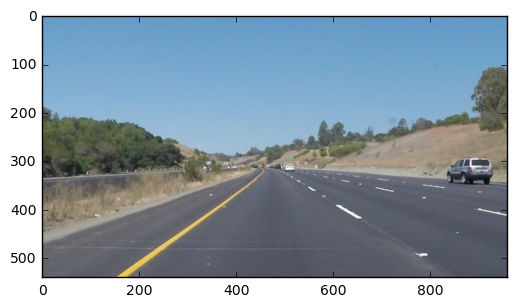

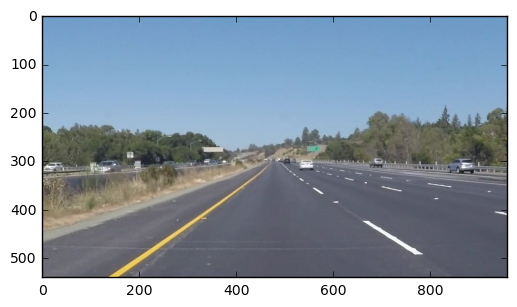

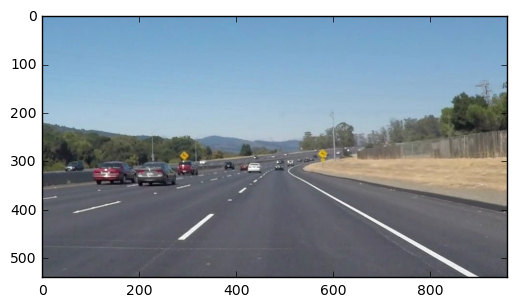

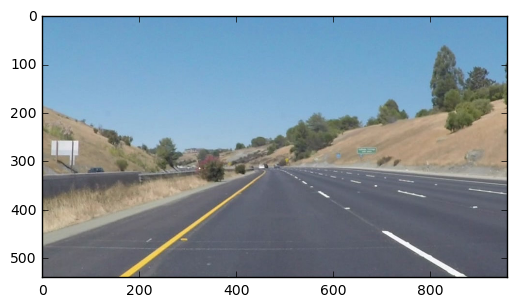

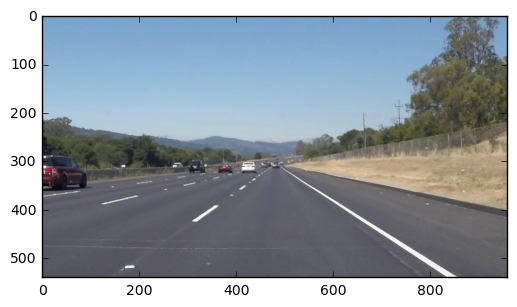

In [7]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

test_pics = os.listdir("test_images/")

for i in test_pics:
    i = 'test_images/' + i
    image = mpimg.imread(i)
    plt.imshow(image)
    plt.show()

run your solution on all test_images and make copies into the test_images directory).


The pipeline
I added image processing functions to process images for the video. 

#The main image processing helper functions are:
# 1.  gray-scale
#  2.  Gaussian Blur
#  3.  Canny Edge
#  4.  masking
#  5.  Hough-Transform
#  After the images processing identifies the 
#  lane lines, then track previous data points and 
# use statistical functions to 
#  remove outliers, remove noise values and
#  extrapolate the lines


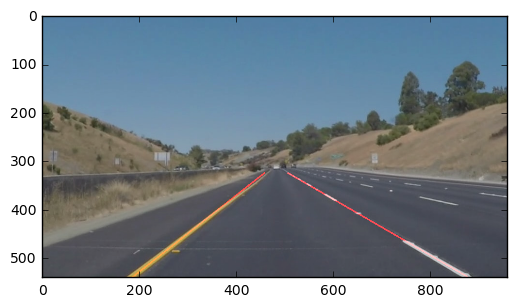

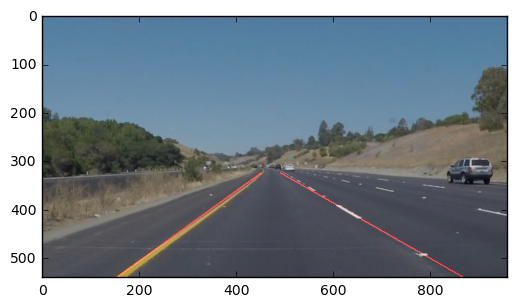

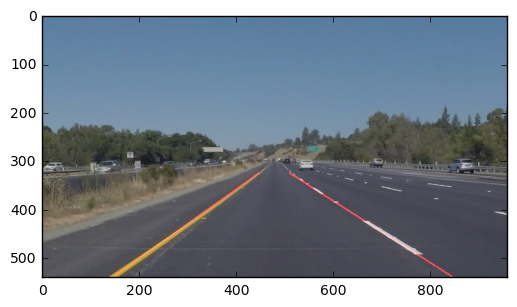

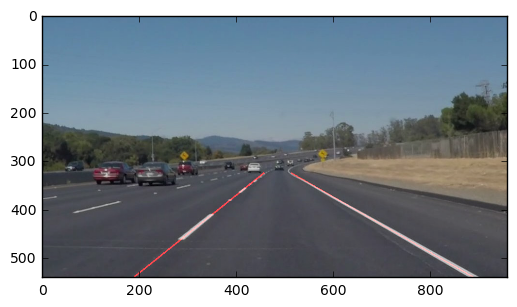

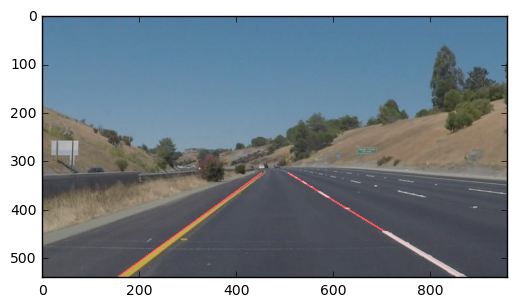

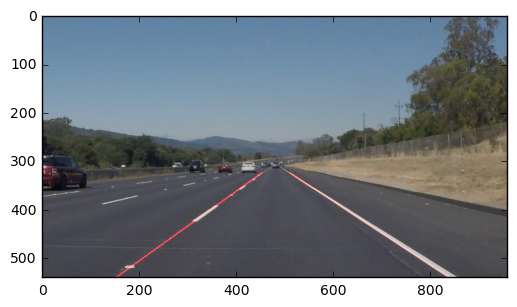

In [8]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

test_pics = os.listdir("test_images/")


#Pull each image and show it to see how it performed
for i in test_pics: 
    i = 'test_images/' + i
    image = mpimg.imread(i)
    plt.imshow(lane_lines(image))
    plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy import *
from IPython.display import HTML

In [10]:
import pandas as pd
#mport scipy.stats as stats
import numpy as np

global x1_last
global x2_last
global y1_last
global y2_last
global set_last_data

set_last_data = True
x1_last = None
x2_last = None
y1_last = None
y2_last = None



def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)




def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def separate_lines(lines):
    """ Takes an array of hough lines and separates them by +/- slope.
        The y-axis is inverted in matplotlib, so the calculated positive slopes will be right
        lane lines and negative slopes will be left lanes. """
    right = []
    left = []
    for x1,y1,x2,y2 in lines[:, 0]:
        m = (float(y2) - y1) / (x2 - x1)
        if m >= 0: 
            right.append([x1,y1,x2,y2,m])
        else:
            left.append([x1,y1,x2,y2,m])
    
    return right, left


def extend_point(x1, y1, x2, y2, length):
    """ Takes line endpoints and extroplates new endpoint by a specfic length"""
    line_len = np.sqrt((x1 - x2)**2 + (y1 - y2)**2) 
    x = x2 + (x2 - x1) / line_len * length
    y = y2 + (y2 - y1) / line_len * length
    return x, y
  
def reject_outliers(data, cutoff, thresh=0.08):
    """Reduces jitter by rejecting lines based on a hard cutoff range and outlier slope """
    data = np.array(data)
    data = data[(data[:, 4] >= cutoff[0]) & (data[:, 4] <= cutoff[1])]
    m = np.mean(data[:, 4], axis=0)
    return data[(data[:, 4] <= m+thresh) & (data[:, 4] >= m-thresh)]


def merge_lines(lines):
    """Merges all Hough lines by the mean of each endpoint, 
       then extends them off across the image"""
    
    lines = np.array(lines)[:, :4] ## Drop last column (slope)
    
    
    x1,y1,x2,y2 = np.mean(lines, axis=0)
    

    print ('x1', x1)
    print ('x2', x2)
    print ('y1', y1)
    print ('y2', y2)
    
    if (np.isnan(x1)):
      print ('x1', x1)
    if (np.isnan(x2)):
      print ('x2', x2)
    if (np.isnan(y1)):
      print ('y1', y1)
    if (np.isnan(y1)):
      print ('y2', y2)

    
    
    x1e, y1e = extend_point(x1,y1,x2,y2, -500) # bottom point
    x2e, y2e = extend_point(x1,y1,x2,y2, 500)  # top point
    line = np.array([[x1e,y1e,x2e,y2e]])

 
    
    return np.array([line], dtype=np.int32)

    




Let's try the one with the solid white lane on the right first ...

In [11]:
def pipeline(image):  
    ### Params for region of interest
    bot_left = [80, 540]
    bot_right = [980, 540]
    apex_right = [510, 315]
    apex_left = [450, 315]
    v = [np.array([bot_left, bot_right, apex_right, apex_left], dtype=np.int32)]
    
    ### Run canny edge detection and mask region of interest
    gray = grayscale(image)
    blur = gaussian_blur(gray, 7)
    edge = canny(blur, 50, 125)
    mask = region_of_interest(edge, v)
    
    plt.imshow(mask)
    
    ### Run Hough Lines and separate by +/- slope
#    lines = cv2.HoughLinesP(mask, 0.8, np.pi/180, 25, np.array([]), minLineLength=10, maxLineGap=400)
    lines = cv2.HoughLinesP(mask, 2, np.pi/180, 10, np.array([]), minLineLength=10, maxLineGap=400)

    right_lines, left_lines = separate_lines(lines)
    right = reject_outliers(right_lines,  cutoff=(0.45, 0.75))
    right = merge_lines(right)
    
    left = reject_outliers(left_lines, cutoff=(-0.85, -0.6))
    left = merge_lines(left)

    lines = np.concatenate((right, left))
    
    ### Draw lines and return final image 
    line_img = np.copy((image)*0)
    draw_lines(line_img, lines, thickness=10)
    
    line_img = region_of_interest(line_img, v)
    final = weighted_img(line_img, image)
    plt.imshow(final)
    

    return final    
    
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = pipeline(image)
    return result



Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

x1 529.2
x2 715.0
y1 334.7
y2 449.9
x1 255.5
x2 440.3
y1 469.4
y2 330.5
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|          | 0/222 [00:00<?, ?it/s]

x1 529.2
x2 715.0
y1 334.7
y2 449.9
x1 255.5
x2 440.3
y1 469.4
y2 330.5


  0%|          | 1/222 [00:00<00:28,  7.62it/s]

x1 584.7
x2 749.7
y1 368.6
y2 475.0
x1 234.1
x2 405.4
y1 483.1
y2 356.2


  1%|▏         | 3/222 [00:00<00:27,  7.96it/s]

x1 637.875
x2 799.0
y1 404.0
y2 501.25
x1 230.125
x2 396.625
y1 486.75
y2 362.875


  2%|▏         | 4/222 [00:00<00:26,  8.17it/s]

x1 596.727272727
x2 751.090909091
y1 381.727272727
y2 473.818181818
x1 246.222222222
x2 450.333333333
y1 473.444444444
y2 323.444444444


  2%|▏         | 5/222 [00:00<00:26,  8.25it/s]

x1 580.666666667
x2 767.0
y1 369.222222222
y2 482.0
x1 255.857142857
x2 436.142857143
y1 467.142857143
y2 333.714285714


  3%|▎         | 6/222 [00:00<00:26,  8.23it/s]

x1 553.272727273
x2 792.454545455
y1 360.363636364
y2 498.909090909
x1 310.333333333
x2 428.222222222
y1 427.0
y2 339.222222222


  3%|▎         | 7/222 [00:00<00:24,  8.63it/s]

x1 635.777777778
x2 793.111111111
y1 402.888888889
y2 499.0
x1 281.1
x2 434.0
y1 445.6
y2 336.1


  4%|▎         | 8/222 [00:00<00:24,  8.83it/s]

x1 547.333333333
x2 800.0
y1 344.5
y2 499.166666667
x1 261.0
x2 422.857142857
y1 460.285714286
y2 345.0
x1 558.6
x2 696.7
y1 354.5
y2 438.6
x1 258.636363636
x2 443.181818182
y1 460.272727273
y2 332.090909091
x1 494.181818182
x2 723.272727273
y1 319.909090909
y2 457.090909091
x1 386.333333333
x2 452.166666667
y1 376.333333333
y2 324.833333333


  5%|▍         | 10/222 [00:01<00:22,  9.31it/s]

x1 592.4
x2 764.1
y1 377.3
y2 

  5%|▍         | 11/222 [00:01<00:22,  9.21it/s]

485.8
x1 267.166666667
x2 465.5
y1 459.166666667
y2 320.5
x1 535.25
x2 714.416666667
y1 352.5
y2 455.75
x1 238.285714286
x2 441.142857143
y1 483.142857143
y2 338.428571429
x1 646.2
x2 814.6
y1 410.1
y2 518.5
x1 226.642857143
x2 407.5
y1 489.0
y2 354.5


  6%|▌         | 13/222 [00:01<00:21,  9.52it/s]

x1 582.166666667
x2 743.166666667
y1 370.833333333
y2 473.833333333
x1 220.818181818
x2 440.181818182
y1 489.545454545
y2 337.0
x1 572.5
x2 747.333333333
y1 370.333333333
y2 475.333333333
x1 195.111111111
x2 347.222222222
y1 508.111111111
y2 399.777777778


  7%|▋         | 15/222 [00:01<00:20,  9.89it/s]

x1 584.285714286
x2 774.142857143
y1 371.714285714
y2 490.857142857
x1 175.875
x2 384.75
y1 519.125
y2 372.0
x1 625.909090909
x2 759.363636364
y1 398.454545455
y2 482.818181818
x1 260.875
x2 419.875
y1 458.0
y2 342.5


  8%|▊         | 18/222 [00:02<00:31,  6.54it/s]

x1 661.428571429
x2 755.285714286
y1 419.785714286
y2 478.5
x1 308.666666667
x2 427.666666667
y1 422.5
y2 340.666666667


  9%|▊         | 19/222 [00:02<00:35,  5.77it/s]

x1 685.411764706
x2 774.294117647
y1 433.117647059
y2 492.882352941
x1 305.333333333
x2 454.166666667
y1 427.5
y2 322.166666667


  9%|▉         | 20/222 [00:02<00:37,  5.42it/s]

x1 556.625
x2 717.875
y1 357.75
y2 457.25
x1 274.333333333
x2 428.888888889
y1 452.222222222
y2 339.333333333


  9%|▉         | 21/222 [00:02<00:42,  4.75it/s]

x1 540.625
x2 723.5
y1 345.25
y2 461.5
x1 256.5
x2 452.125
y1 463.25
y2 327.5


 10%|▉         | 22/222 [00:03<00:41,  4.79it/s]

x1 581.5
x2 745.1
y1 370.5
y2 474.2
x1 300.857142857
x2 422.571428571
y1 434.142857143
y2 346.428571429
x1 547.0
x2 740.571428571
y1 349.857142857
y2 473.142857143
x1 269.428571429
x2 453.714285714
y1 455.571428571
y2 321.857142857


 11%|█         | 24/222 [00:03<00:36,  5.47it/s]

x1 592.909090909
x2 738.454545455
y1 378.363636364
y2 469.636363636
x1 259.75
x2 457.0
y1 464.0
y2 325.5
x1 518.666666667
x2 765.888888889
y1 334.111111111
y2 487.444444444
x1 254.555555556
x2 453.111111111
y1 467.888888889
y2 324.0


 12%|█▏        | 26/222 [00:03<00:32,  5.94it/s]

x1 589.9
x2 722.3
y1 376.7
y2 460.0
x1 251.833333333
x2 398.0
y1 466.0
y2 360.416666667
x1 537.9
x2 707.3
y1 345.4
y2 451.3
x1 221.384615385
x2 402.076923077
y1 489.538461538
y2 361.230769231


 13%|█▎        | 28/222 [00:03<00:31,  6.08it/s]

x1 582.25
x2 740.625
y1 371.875
y2 473.0
x1 219.125
x2 431.5
y1 493.5
y2 339.625
x1 571.6
x2 739.0
y1 370.6
y2 473.4
x1 207.5
x2 422.166666667
y1 499.666666667
y2 347.166666667


 14%|█▎        | 30/222 [00:04<00:30,  6.20it/s]

x1 554.2
x2 736.8
y1 353.9
y2 468.5
x1 328.714285714
x2 444.857142857
y1 412.0
y2 329.714285714
x1 559.0
x2 741.571428571
y1 357.142857143
y2 467.714285714
x1 314.0
x2 434.4
y1 424.0
y2 338.2


 14%|█▍        | 32/222 [00:04<00:30,  6.25it/s]

x1 598.363636364
x2 749.181818182
y1 378.181818182
y2 473.363636364
x1 249.8
x2 458.2
y1 469.6
y2 319.2
x1 557.636363636
x2 695.272727273
y1 353.272727273
y2 440.272727273
x1 189.111111111
x2 421.777777778
y1 508.0
y2 346.333333333


 15%|█▌        | 34/222 [00:04<00:31,  5.91it/s]

x1 613.909090909
x2 732.636363636
y1 392.454545455
y2 467.636363636
x1 296.4
x2 452.8
y1 436.6
y2 324.2
x1 519.285714286
x2 740.285714286
y1 330.571428571
y2 470.428571429
x1 290.875
x2 421.875
y1 441.0
y2 343.0


 16%|█▌        | 36/222 [00:05<00:29,  6.26it/s]

x1 554.5
x2 718.0
y1 353.666666667
y2 456.666666667
x1 277.333333333
x2 442.666666667
y1 454.222222222
y2 328.666666667
x1 611.470588235
x2 738.058823529
y1 389.411764706
y2 468.235294118
x1 220.142857143
x2 433.571428571
y1 492.0
y2 342.142857143


 17%|█▋        | 38/222 [00:05<00:28,  6.56it/s]

x1 563.5625
x2 713.0625
y1 365.375
y2 455.9375
x1 199.5
x2 445.75
y1 505.875
y2 332.125
x1 585.461538462
x2 665.0
y1 374.076923077
y2 424.230769231
x1 241.454545455
x2 399.0
y1 476.272727273
y2 364.272727273


 18%|█▊        | 40/222 [00:05<00:27,  6.52it/s]

x1 601.529411765
x2 719.588235294
y1 385.176470588
y2 456.823529412
x1 226.1
x2 349.5
y1 485.9
y2 396.6
x1 565.25
x2 689.833333333
y1 359.666666667
y2 437.166666667
x1 165.777777778
x2 394.888888889
y1 529.555555556
y2 362.111111111


 19%|█▉        | 43/222 [00:06<00:25,  6.99it/s]

x1 574.714285714
x2 672.642857143
y1 366.5
y2 427.642857143
x1 336.5
x2 443.375
y1 406.25
y2 327.125
x1 567.944444444
x2 726.555555556
y1 367.777777778
y2 463.333333333
x1 289.285714286
x2 443.571428571
y1 442.0
y2 326.571428571


 20%|█▉        | 44/222 [00:06<00:24,  7.23it/s]

x1 666.1
x2 782.7
y1 421.0
y2 498.9
x1 274.111111111
x2 438.333333333
y1 449.555555556
y2 333.0
x1 569.1
x2 685.6
y1 366.1
y2 436.2
x1 207.416666667
x2 392.25
y1 499.333333333
y2 364.416666667


 21%|██        | 46/222 [00:06<00:24,  7.27it/s]

x1 529.916666667
x2 762.5
y1 348.166666667
y2 487.666666667
x1 325.8
x2 456.4
y1 412.8
y2 319.4
x1 655.461538462
x2 768.230769231
y1 418.615384615
y2 488.384615385
x1 283.142857143
x2 410.285714286
y1 444.0
y2 348.857142857


 22%|██▏       | 49/222 [00:07<00:22,  7.62it/s]

x1 596.066666667
x2 698.266666667
y1 380.333333333
y2 443.333333333
x1 275.25
x2 441.25
y1 449.375
y2 331.375
x1 680.25
x2 763.583333333
y1 430.333333333
y2 485.25
x1 254.333333333
x2 427.666666667
y1 464.888888889
y2 340.333333333


 23%|██▎       | 51/222 [00:07<00:21,  7.96it/s]

x1 604.285714286
x2 765.428571429
y1 393.928571429
y2 488.571428571
x1 206.777777778
x2 410.555555556
y1 494.777777778
y2 352.111111111
x1 634.214285714
x2 717.285714286
y1 400.857142857
y2 455.357142857
x1 222.857142857
x2 448.142857143
y1 487.0
y2 325.571428571


 24%|██▍       | 53/222 [00:07<00:20,  8.23it/s]

x1 516.8
x2 717.2
y1 335.5
y2 455.6
x1 292.7
x2 440.1
y1 435.1
y2 330.0
x1 548.0
x2 747.1
y1 351.4
y2 473.9
x1 224.833333333
x2 400.5
y1 482.083333333
y2 358.75


 24%|██▍       | 54/222 [00:07<00:20,  8.24it/s]

x1 664.875
x2 737.8125
y1 421.1875
y2 471.75
x1 286.375
x2 425.375
y1 437.0
y2 341.125
x1 563.909090909
x2 742.090909091
y1 364.909090909
y2 474.636363636
x1 301.166666667
x2 452.833333333
y1 428.0
y2 320.0


 26%|██▌       | 57/222 [00:08<00:19,  8.39it/s]

x1 539.9375
x2 725.8125
y1 350.25
y2 463.4375
x1 254.571428571
x2 445.857142857
y1 458.714285714
y2 330.571428571
x1 503.384615385
x2 733.923076923
y1 332.538461538
y2 471.538461538
x1 179.0
x2 407.625
y1 513.375
y2 354.25


 27%|██▋       | 59/222 [00:08<00:19,  8.31it/s]

x1 548.555555556
x2 732.666666667
y1 356.222222222
y2 471.222222222
x1 322.0
x2 441.5
y1 413.333333333
y2 333.0
x1 553.416666667
x2 733.083333333
y1 357.166666667
y2 469.166666667
x1 266.833333333
x2 451.0
y1 452.333333333
y2 325.333333333


 27%|██▋       | 60/222 [00:08<00:19,  8.47it/s]

x1 617.529411765
x2 713.882352941
y1 393.058823529
y2 457.823529412
x1 262.375
x2 446.625
y1 456.375
y2 325.625
x1 556.090909091
x2 679.454545455
y1 357.909090909
y2 435.363636364
x1 226.222222222
x2 412.0
y1 479.222222222
y2 351.222222222


 28%|██▊       | 62/222 [00:08<00:19,  8.30it/s]

x1 533.352941176
x2 697.352941176
y1 350.0
y2 445.411764706
x1 187.666666667
x2 438.333333333
y1 505.833333333
y2 333.5
x1 596.090909091
x2 713.818181818
y1 382.454545455
y2 461.272727273
x1 207.4
x2 379.1
y1 493.4
y2 374.3


 29%|██▉       | 64/222 [00:08<00:20,  7.62it/s]

x1 578.333333333
x2 736.555555556
y1 368.666666667
y2 473.555555556
x1 175.888888889
x2 389.555555556
y1 515.0
y2 363.444444444
x1 547.0
x2 739.142857143
y1 349.142857143
y2 476.571428571
x1 190.7
x2 438.6
y1 501.5
y2 336.3


 30%|██▉       | 66/222 [00:09<00:19,  7.93it/s]

x1 556.3
x2 693.0
y1 355.3
y2 445.7
x1 316.428571429
x2 450.428571429
y1 414.142857143
y2 326.857142857
x1 673.142857143
x2 738.642857143
y1 429.428571429
y2 472.785714286
x1 345.5
x2 446.5
y1 397.5
y2 324.0


 31%|███       | 68/222 [00:09<00:17,  8.66it/s]

x1 676.176470588
x2 757.882352941
y1 432.117647059
y2 487.0
x1 258.375
x2 440.0
y1 454.375
y2 328.0
x1 682.307692308
x2 782.153846154
y1 435.384615385
y2 502.384615385
x1 194.5
x2 429.625
y1 496.75
y2 337.0
x1 557.2
x2 770.4
y1 355.0
y2 494.6
x1 333.6
x2 433.4
y1 404.3
y2 337.4


 32%|███▏      | 72/222 [00:09<00:15,  9.91it/s]

x1 556.166666667
x2 777.0
y1 354.333333333
y2 500.5
x1 276.0
x2 391.111111111
y1 441.777777778
y2 360.222222222
x1 503.5
x2 781.333333333
y1 320.0
y2 503.333333333
x1 274.0
x2 404.3
y1 441.7
y2 358.1
x1 603.363636364
x2 724.727272727
y1 386.727272727
y2 466.454545455
x1 254.545454545
x2 424.090909091
y1 456.090909091
y2 342.181818182


 33%|███▎      | 74/222 [00:09<00:15,  9.77it/s]

x1 551.8
x2 714.0
y1 352.3
y2 459.0
x1 199.0
x2 372.444444444
y1 493.666666667
y2 376.0
x1 652.090909091
x2 769.818181818
y1 418.909090909
y2 497.0
x1 200.4
x2 388.1
y1 492.9
y2 364.4
x1 585.923076923
x2 738.846153846
y1 374.923076923
y2 478.461538462
x1 166.125
x2 411.625
y1 516.25
y2 349.0


 35%|███▌      | 78/222 [00:10<00:14,  9.91it/s]

x1 566.777777778
x2 688.777777778
y1 364.0
y2 444.555555556
x1 207.111111111
x2 353.0
y1 485.222222222
y2 389.111111111
x1 581.1
x2 693.7
y1 374.2
y2 448.8
x1 317.0
x2 414.111111111
y1 414.0
y2 344.555555556


 36%|███▌      | 80/222 [00:10<00:14,  9.87it/s]

x1 575.133333333
x2 720.466666667
y1 376.733333333
y2 468.6
x1 270.0
x2 439.666666667
y1 443.0
y2 329.666666667
x1 636.1875
x2 722.9375
y1 408.25
y2 468.5625
x1 254.285714286
x2 430.714285714
y1 457.0
y2 333.428571429


 36%|███▋      | 81/222 [00:10<00:15,  9.38it/s]

x1 608.214285714
x2 708.428571429
y1 391.428571429
y2 460.928571429
x1 273.333333333
x2 403.833333333
y1 438.5
y2 355.0
x1 604.181818182
x2 755.454545455
y1 395.090909091
y2 493.272727273
x1 308.333333333
x2 439.5
y1 415.833333333
y2 330.833333333
x1 620.2


 38%|███▊      | 84/222 [00:10<00:14,  9.62it/s]

x2 764.8
y1 397.7
y2 498.5
x1 271.333333333
x2 443.5
y1 440.833333333
y2 329.666666667
x1 584.25
x2 692.416666667
y1 374.333333333
y2 448.666666667
x1 253.5
x2 387.0
y1 454.5
y2 361.25


 38%|███▊      | 85/222 [00:11<00:14,  9.56it/s]

x1 582.0
x2 685.846153846
y1 374.230769231
y2 444.769230769
x1 246.8
x2 459.2
y1 458.2
y2 322.0
x1 603.888888889
x2 724.444444444
y1 388.666666667
y2 470.666666667
x1 144.111111111
x2 373.444444444
y1 527.111111111
y2 374.888888889
x1 562.4
x2 702.733333333
y1 364.666666667
y2 457.333333333
x1 168.833333333
x2 457.5
y1 511.166666667
y2 319.0


 40%|████      | 89/222 [00:11<00:13, 10.18it/s]

x1 520.9375
x2 703.0625
y1 339.0
y2 459.1875
x1 144.5
x2 458.833333333
y1 528.333333333
y2 319.5
x1 575.727272727
x2 722.454545455
y1 380.272727273
y2 471.181818182
x1 207.2
x2 408.1
y1 486.4
y2 351.9
x1 594.333333333
x2 733.333333333
y1 381.888888889
y2 477.222222222
x1 290.285714286
x2 453.714285714
y1 430.285714286
y2 322.142857143


 41%|████      | 91/222 [00:11<00:12, 10.38it/s]

x1 494.9
x2 648.4
y1 321.6
y2 416.7
x1 292.857142857
x2 465.857142857
y1 430.142857143
y2 317.714285714
x1 546.454545455
x2 662.363636364
y1 352.090909091
y2 428.090909091
x1 216.8
x2 441.2
y1 480.6
y2 330.6
x1 601.846153846
x2 734.615384615
y1 389.692307692
y2 479.076923077
x1 192.25
x2 445.625
y1 497.375
y2 328.625


 43%|████▎     | 95/222 [00:11<00:12, 10.50it/s]

x1 591.583333333
x2 695.666666667
y1 378.25
y2 451.916666667
x1 294.166666667
x2 442.166666667
y1 429.666666667
y2 332.333333333
x1 620.454545455
x2 709.636363636
y1 400.090909091
y2 461.272727273
x1 274.222222222
x2 411.444444444
y1 444.333333333
y2 348.222222222
x1 636.071428571
x2 739.214285714
y1 416.928571429
y2 481.857142857
x1 266.0
x2 419.111111111


 44%|████▎     | 97/222 [00:12<00:11, 10.93it/s]

y1 447.888888889
y2 342.333333333
x1 624.384615385
x2 720.307692308
y1 400.846153846
y2 465.923076923
x1 221.636363636
x2 381.454545455
y1 477.909090909
y2 371.090909091
x1 597.272727273
x2 731.818181818
y1 379.363636364
y2 476.272727273
x1 222.444444444
x2 413.0
y1 476.777777778
y2 347.444444444


 45%|████▍     | 99/222 [00:12<00:11, 10.73it/s]

x1 588.307692308
x2 693.461538462
y1 377.615384615
y2 445.076923077
x1 202.833333333
x2 450.166666667
y1 486.666666667
y2 325.333333333
x1 639.846153846
x2 725.538461538
y1 407.538461538
y2 468.923076923
x1 213.272727273
x2 390.545454545
y1 481.636363636
y2 362.454545455
x1 537.454545455
x2 701.636363636
y1 339.545454545
y2 452.636363636
x1 264.166666667
x2 417.5
y1 451.333333333
y2 345.666666667


 46%|████▋     | 103/222 [00:12<00:11, 10.61it/s]

x1 549.25
x2 711.375
y1 349.125
y2 462.5
x1 314.857142857
x2 438.0
y1 416.142857143
y2 335.285714286
x1 516.818181818
x2 729.909090909
y1 332.727272727
y2 475.909090909
x1 262.285714286
x2 446.857142857
y1 452.857142857
y2 331.0
x1 503.8
x2 734.4
y1 336.333333333
y2 473.866666667
x1 274.75
x2 455.125
y1 449.0
y2 321.125


 47%|████▋     | 105/222 [00:12<00:11, 10.36it/s]

x1 613.461538462
x2 733.692307692
y1 391.230769231
y2 474.615384615
x1 229.0
x2 433.833333333
y1 477.166666667
y2 339.166666667
x1 566.875
x2 744.75
y1 358.875
y2 480.75
x1 312.142857143
x2 479.285714286
y1 419.0
y2 315.571428571
x1 527.555555556
x2 727.666666667
y1 333.888888889
y2 469.0
x1 280.555555556
x2 421.333333333
y1 442.444444444
y2 346.0


 49%|████▉     | 109/222 [00:13<00:09, 11.66it/s]

x1 568.5
x2 687.75
y1 366.6875
y2 440.9375
x1 259.625
x2 445.5
y1 456.625
y2 326.75
x1 651.416666667
x2 735.583333333
y1 415.75
y2 473.666666667
x1 237.916666667
x2 379.833333333
y1 472.833333333
y2 372.916666667
x1 546.777777778
x2 755.333333333
y1 347.333333333
y2 487.444444444
x1 186.111111111
x2 419.0
y1 505.888888889
y2 355.666666667


 50%|█████     | 111/222 [00:13<00:09, 11.99it/s]

x1 548.181818182
x2 701.545454545
y1 348.090909091
y2 453.545454545
x1 195.714285714
x2 369.928571429
y1 501.071428571
y2 386.142857143
x1 569.636363636
x2 692.0
y1 361.272727273
y2 444.909090909
x1 220.857142857
x2 452.714285714
y1 485.571428571
y2 325.857142857
x1 591.818181818
x2 709.636363636
y1 375.181818182
y2 454.636363636
x1 258.714285714
x2 416.714285714
y1 456.857142857
y2 350.714285714


 52%|█████▏    | 115/222 [00:13<00:08, 12.38it/s]

x1 631.133333333
x2 738.4
y1 400.666666667
y2 473.533333333
x1 325.0
x2 451.0
y1 411.833333333
y2 326.666666667
x1 636.6
x2 704.933333333
y1 404.866666667
y2 452.533333333
x1 278.666666667
x2 462.0
y1 441.833333333
y2 321.333333333
x1 633.2
x2 742.6
y1 399.6
y2 471.4
x1 234.166666667
x2 437.333333333
y1 474.666666667
y2 333.0


 53%|█████▎    | 117/222 [00:13<00:08, 12.55it/s]

x1 597.888888889
x2 732.111111111
y1 376.333333333
y2 468.111111111
x1 231.333333333
x2 419.111111111
y1 475.0
y2 346.777777778
x1 585.684210526
x2 724.684210526
y1 378.263157895
y2 463.210526316
x1 296.5
x2 454.375
y1 429.625
y2 325.25
x1 513.142857143
x2 752.0
y1 325.714285714
y2 482.857142857
x1 275.75
x2 446.75
y1 442.5
y2 329.5


 55%|█████▍    | 121/222 [00:14<00:08, 12.52it/s]

x1 588.5
x2 805.333333333
y1 374.333333333
y2 517.666666667
x1 248.666666667
x2 444.333333333
y1 463.333333333
y2 332.666666667
x1 569.071428571
x2 772.785714286
y1 373.071428571
y2 494.714285714
x1 247.0
x2 412.5
y1 467.0
y2 350.333333333
x1 658.9
x2 767.8
y1 416.5
y2 488.9
x1 198.272727273
x2 411.636363636
y1 499.454545455
y2 354.454545455


 55%|█████▌    | 123/222 [00:14<00:07, 12.60it/s]

x1 588.777777778
x2 699.666666667
y1 378.611111111
y2 447.055555556
x1 221.555555556
x2 440.222222222
y1 484.0
y2 334.222222222
x1 512.857142857
x2 744.714285714
y1 331.571428571
y2 471.714285714
x1 217.111111111
x2 437.555555556
y1 484.777777778
y2 339.222222222
x1 574.375
x2 755.125
y1 364.875
y2 479.5
x1 212.222222222
x2 422.777777778
y1 490.0
y2 345.0


 56%|█████▋    | 125/222 [00:14<00:07, 12.54it/s]

x1 493.454545455
x2 715.636363636
y1 322.909090909
y2 449.727272727
x1 311.2
x2 459.8
y1 424.6
y2 320.2
x1 593.0
x2 705.923076923
y1 375.615384615
y2 446.923076923
x1 361.8
x2 448.6
y1 392.4
y2 327.4


 57%|█████▋    | 127/222 [00:14<00:11,  7.96it/s]

x1 609.909090909
x2 763.363636364
y1 386.545454545
y2 484.181818182
x1 260.777777778
x2 468.333333333
y1 459.666666667
y2 318.333333333


 58%|█████▊    | 129/222 [00:15<00:14,  6.23it/s]

x1 558.5
x2 805.5
y1 354.333333333
y2 511.5
x1 248.0
x2 436.285714286
y1 469.285714286
y2 339.571428571


 59%|█████▊    | 130/222 [00:15<00:15,  5.91it/s]

x1 566.555555556
x2 764.555555556
y1 359.0
y2 484.666666667
x1 257.888888889
x2 471.666666667
y1 461.111111111
y2 319.111111111
x1 516.875
x2 740.25
y1 332.375
y2 467.625
x1 286.142857143


 59%|█████▉    | 132/222 [00:16<00:17,  5.21it/s]

x2 460.571428571
y1 446.571428571
y2 319.571428571
x1 566.0
x2 829.4
y1 358.0
y2 525.8
x1 272.0
x2 419.777777778
y1 454.111111111
y2 353.0
x1 608.142857143
x2 741.285714286
y1 385.357142857
y2 467.642857143
x1 282.181818182
x2 431.272727273
y1 450.727272727
y2 337.272727273


 60%|██████    | 134/222 [00:16<00:17,  5.08it/s]

x1 626.833333333
x2 769.333333333
y1 394.75
y2 486.25
x1 242.25
x2 404.375
y1 482.5
y2 355.75
x1 511.6
x2 775.4
y1 321.8
y2 489.6
x1 268.571428571
x2 420.571428571
y1

 61%|██████▏   | 136/222 [00:16<00:17,  4.84it/s]

 456.0
y2 348.857142857
x1 624.090909091
x2 757.545454545
y1 390.727272727
y2 475.181818182
x1 230.214285714
x2 380.5
y1 482.357142857
y2 373.285714286


 62%|██████▏   | 137/222 [00:17<00:17,  4.83it/s]

x1 561.5
x2 763.25
y1 351.875
y2 479.25
x1 240.916666667
x2 388.0
y1 474.083333333
y2 369.0


 62%|██████▏   | 138/222 [00:17<00:17,  4.74it/s]

x1 619.2
x2 785.6
y1 387.4
y2 493.5
x1 352.375
x2 449.375
y1 398.375
y2 326.75


 63%|██████▎   | 139/222 [00:17<00:18,  4.43it/s]

x1 612.272727273
x2 774.272727273
y1 383.454545455
y2 486.272727273
x1 325.0
x2 463.666666667
y1 416.666666667
y2 318.666666667


 63%|██████▎   | 140/222 [00:17<00:17,  4.66it/s]

x1 621.384615385
x2 767.846153846
y1 392.538461538
y2 486.076923077
x1 244.166666667
x2 461.666666667
y1 473.166666667
y2 320.666666667
x1 653.8
x2 775.4
y1 411.3
y2 489.0
x1 210.142857143
x2 472.714285714
y1 500.285714286
y2 316.714285714


 64%|██████▍   | 142/222 [00:18<00:15,  5.08it/s]

x1 590.111111111
x2 780.111111111
y1 377.0
y2 496.777777778
x1 209.555555556
x2 455.111111111
y1 502.666666667
y2 325.0
x1 579.625
x2 764.5
y1 366.125
y2 483.75
x1 338.4
x2 455.8
y1 412.5
y2 325.2


 65%|██████▍   | 144/222 [00:18<00:16,  4.79it/s]

x1 552.923076923
x2 714.538461538
y1 352.538461538
y2 453.076923077
x1 271.5
x2 427.583333333
y1 458.583333333
y2 342.75


 65%|██████▌   | 145/222 [00:18<00:17,  4.43it/s]

x1 509.0
x2 763.833333333
y1 322.333333333
y2 484.166666667
x1 257.333333333
x2 452.166666667
y1 469.25
y2 329.833333333


 66%|██████▌   | 146/222 [00:19<00:17,  4.36it/s]

x1 605.692307692
x2 701.923076923
y1 381.538461538
y2 441.461538462
x1 259.923076923
x2 420.923076923
y1 468.769230769
y2 347.153846154


 66%|██████▌   | 147/222 [00:19<00:17,  4.34it/s]

x1 564.5
x2 709.3
y1 353.6
y2 446.6
x1 218.416666667
x2 392.166666667
y1 496.25
y2 371.083333333


 67%|██████▋   | 148/222 [00:19<00:16,  4.62it/s]

x1 605.333333333
x2 764.933333333
y1 386.066666667
y2 479.466666667
x1 288.125
x2 446.375
y1 448.25
y2 331.5
x1 604.615384615
x2 715.384615385
y1 377.076923077
y2 448.384615385
x1 214.111111111
x2 403.333333333
y1 499.222222222
y2 366.888888889


 68%|██████▊   | 150/222 [00:19<00:13,  5.36it/s]

x1 524.833333333
x2 695.75
y1 330.166666667
y2 438.25
x1 343.6
x2 459.4
y1 405.8
y2 324.6
x1 518.6
x2 715.4
y1 328.6
y2 447.8
x1 299.4
x2 472.8
y1 440.8
y2 317.2


 68%|██████▊   | 152/222 [00:20<00:11,  6.21it/s]

x1 677.416666667
x2 779.0
y1 424.916666667
y2 489.0
x1 318.625
x2 463.75
y1 427.5
y2 321.5
x1 648.545454545
x2 761.727272727
y1 404.454545455
y2 479.0
x1 263.0
x2 446.888888889
y1 466.333333333
y2 334.0


 70%|██████▉   | 155/222 [00:20<00:09,  7.32it/s]

x1 637.333333333
x2 801.222222222
y1 396.111111111
y2 501.555555556
x1 232.0
x2 436.222222222
y1 487.222222222
y2 343.111111111
x1 646.444444444
x2 786.555555556
y1 401.666666667
y2 492.333333333
x1 295.333333333
x2 419.666666667
y1 441.666666667
y2 349.666666667


 71%|███████   | 157/222 [00:20<00:08,  7.85it/s]

x1 589.166666667
x2 707.916666667
y1 366.333333333
y2 442.333333333
x1 288.857142857
x2 439.142857143
y1 447.714285714
y2 336.142857143
x1 674.181818182
x2 789.0
y1 417.181818182
y2 490.909090909
x1 273.111111111
x2 403.0
y1 460.0
y2 361.333333333


 72%|███████▏  | 159/222 [00:20<00:07,  8.08it/s]

x1 532.4
x2 758.7
y1 336.7
y2 473.3
x1 217.75
x2 397.75
y1 501.0
y2 367.5
x1 545.428571429
x2 777.714285714
y1 345.0
y2 485.428571429
x1 205.166666667
x2 427.0
y1 508.5
y2 344.333333333


 73%|███████▎  | 161/222 [00:21<00:07,  8.43it/s]

x1 504.076923077
x2 743.923076923
y1 328.769230769
y2 457.153846154
x1 221.9
x2 325.9
y1 499.9
y2 418.5
x1 608.4
x2 720.4
y1 377.2
y2 447.066666667
x1 200.375
x2 397.75
y1 516.0
y2 369.25


 73%|███████▎  | 162/222 [00:21<00:07,  8.20it/s]

x1 605.857142857
x2 766.0
y1 374.714285714
y2 475.857142857
x1 331.571428571
x2 468.428571429
y1 420.571428571
y2 319.0
x1 531.583333333
x2 758.666666667
y1 341.5
y2 469.916666667
x1 301.75
x2 473.25
y1 443.0
y2 318.0


 74%|███████▍  | 164/222 [00:21<00:07,  8.22it/s]

x1 558.888888889
x2 780.444444444
y1 352.333333333
y2 480.888888889
x1 279.0
x2 453.0
y1 458.333333333
y2 328.5
x1 575.7
x2 778.6
y1 361.6
y2 479.8
x1 254.0
x2 480.142857143
y1 476.285714286
y2 317.857142857


 75%|███████▌  | 167/222 [00:21<00:06,  8.34it/s]

x1 495.8
x2 795.2
y1 316.4
y2 492.4
x1 210.875
x2 470.375
y1 513.375
y2 318.875
x1 487.416666667
x2 757.833333333
y1 317.5
y2 470.833333333
x1 306.0
x2 469.5
y1 443.25
y2 318.0


 76%|███████▌  | 169/222 [00:22<00:06,  7.82it/s]

x1 583.416666667
x2 740.5
y1 366.5
y2 461.5
x1 289.833333333
x2 453.666666667
y1 456.333333333
y2 330.666666667
x1 567.625
x2 760.25
y1 355.625
y2 469.5
x1 274.5
x2 480.0
y1 466.7
y2 318.1


 77%|███████▋  | 171/222 [00:22<00:05,  8.62it/s]

x1 526.444444444
x2 733.777777778
y1 335.777777778
y2 456.111111111
x1 204.083333333
x2 384.583333333
y1 521.5
y2 381.916666667
x1 534.166666667
x2 701.666666667
y1 337.333333333
y2 437.666666667
x1 244.0
x2 383.181818182
y1 492.818181818
y2 381.0
x1

 78%|███████▊  | 173/222 [00:22<00:05,  8.99it/s]

 613.363636364
x2 745.0
y1 384.636363636
y2 458.909090909
x1 249.8
x2 427.3
y1 488.1
y2 348.9
x1 492.333333333
x2 722.666666667
y1 317.666666667
y2 449.666666667
x1 250.666666667
x2 421.222222222
y1 486.222222222
y2 353.0


 79%|███████▉  | 175/222 [00:22<00:05,  9.24it/s]

x1 506.0
x2 726.125
y1 322.125
y2 452.375
x1 329.285714286
x2 463.571428571
y1 425.285714286
y2 320.571428571
x1 529.555555556
x2 729.555555556
y1 334.444444444
y2 451.777777778
x1 322.5
x2 465.5
y1 429.375
y2 319.875
x1 499.142857143
x2 794.428571429
y1 317.0

 80%|███████▉  | 177/222 [00:22<00:04,  9.62it/s]


y2 489.571428571
x1 274.571428571
x2 463.0
y1 468.428571429
y2 322.571428571
x1 560.454545455
x2 711.636363636
y1 353.363636364
y2 440.727272727
x1 287.75
x2 481.125
y1 457.375
y2 317.375
x1 484.090909091
x2 772.0
y1 317.454545455
y2 479.727272727
x1 272.272727273
x2 459.636363636
y1 469.090909091
y2 329.636363636


 81%|████████  | 179/222 [00:23<00:04,  9.77it/s]

x1 498.0
x2 728.714285714
y1 315.428571429
y2 450.428571429
x1 336.545454545
x2 475.545454545
y1 421.818181818
y2 317.181818182
x1 501.8
x2 820.2
y1 316.4
y2 503.8
x1 287.0
x2 418.25
y1 460.375
y2 356.875


 82%|████████▏ | 181/222 [00:23<00:04, 10.11it/s]

x1 587.5
x2 782.0
y1 365.625
y2 480.5
x1 259.2
x2 464.6
y1 485.3
y2 323.1
x1 529.0
x2 756.272727273
y1 335.545454545
y2 465.727272727
x1 240.714285714
x2 442.571428571
y1 498.0
y2 342.285714286
x1 560.470588235
x2 762.235294118
y1 358.470588235
y2 470.411764706
x1 223.142857143
x2 474.0
y1 509.428571429
y2 317.285714286


 83%|████████▎ | 185/222 [00:23<00:03, 11.48it/s]

x1 566.75
x2 793.875
y1 353.125
y2 487.125
x1 233.363636364
x2 396.0
y1 503.636363636
y2 372.363636364
x1 640.545454545
x2 803.181818182
y1 394.272727273
y2 496.090909091
x1 305.571428571
x2 396.0
y1 443.142857143
y2 371.428571429
x1 632.6875
x2 762.1875
y1 392.625
y2 468.9375
x1 305.0
x2 467.2
y1 443.4
y2 317.8


 84%|████████▍ | 187/222 [00:23<00:02, 11.74it/s]

x1 637.666666667
x2 755.133333333
y1 395.4
y2 465.066666667
x1 311.0
x2 450.333333333
y1 438.0
y2 331.666666667
x1 626.666666667
x2 756.866666667
y1 386.533333333
y2 464.933333333
x1 315.8
x2 449.4
y1 432.6
y2 333.0
x1 527.416666667
x2 763.333333333
y1 334.333333333
y2 465.583333333
x1 287.5
x2 454.75
y1 454.625
y2 327.125


 86%|████████▌ | 191/222 [00:24<00:02, 12.23it/s]

x1 591.416666667
x2 737.5
y1 362.166666667
y2 450.166666667
x1 225.875
x2 417.75
y1 503.0
y2 350.75
x1 535.166666667
x2 740.583333333
y1 336.166666667
y2 450.916666667
x1 352.8
x2 459.8
y1 403.2
y2 320.0
x1 580.125
x2 793.875
y1 358.75
y2 482.75
x1 307.888888889
x2 431.777777778
y1 440.888888889
y2 342.333333333


 87%|████████▋ | 193/222 [00:24<00:02, 12.28it/s]

x1 634.777777778
x2 744.444444444
y1 390.0
y2 458.277777778
x1 294.666666667
x2 453.0
y1 451.833333333
y2 333.666666667
x1 516.428571429
x2 715.428571429
y1 327.357142857
y2 443.714285714
x1 277.0
x2 490.9
y1 462.8
y2 318.5
x1 507.333333333
x2 697.222222222
y1 320.222222222
y2 432.666666667
x1 250.8
x2 399.7
y1 489.6
y2 370.3


 89%|████████▊ | 197/222 [00:24<00:02, 11.81it/s]

x1 502.125
x2 721.625
y1 320.125
y2 449.375
x1 265.333333333
x2 408.111111111
y1 478.111111111
y2 362.222222222
x1 501.9
x2 626.5
y1 317.3
y2 392.6
x1 238.0
x2 453.166666667
y1 498.833333333
y2 326.833333333
x1 531.875
x2 743.0
y1 336.875
y2 457.75
x1 342.8
x2 443.2
y1 414.6
y2 335.2


 90%|████████▉ | 199/222 [00:24<00:01, 11.80it/s]

x1 503.4
x2 836.8
y1 316.0
y2 512.4
x1 311.111111111
x2 459.555555556
y1 440.444444444
y2 324.666666667
x1 607.692307692
x2 817.923076923
y1 387.384615385
y2 502.230769231
x1 273.285714286
x2 420.142857143
y1 470.571428571
y2 354.142857143
x1 603.285714286
x2 823.142857143
y1 373.0
y2 502.571428571
x1 299.25
x2 453.75
y1 448.0
y2 332.25


 91%|█████████▏| 203/222 [00:25<00:01, 12.24it/s]

x1 502.111111111
x2 716.333333333
y1 325.222222222
y2 439.944444444
x1 220.166666667
x2 469.0
y1 515.833333333
y2 321.0
x1 529.083333333
x2 743.833333333
y1 338.833333333
y2 456.583333333
x1 343.444444444
x2 473.777777778
y1 412.0
y2 317.888888889
x1 533.0
x2 714.846153846
y1 336.153846154
y2 439.307692308
x1 311.777777778
x2 436.444444444
y1 439.555555556
y2 339.222222222


 92%|█████████▏| 205/222 [00:25<00:01, 11.82it/s]

x1 555.8125
x2 704.0625
y1 345.5
y2 435.375
x1 276.5
x2 437.8
y1 467.4
y2 340.1
x1 661.0
x2 769.571428571
y1 407.428571429
y2 469.785714286
x1 212.125
x2 417.375
y1 518.375
y2 355.375
x1 669.5
x2 779.071428571
y1 409.0
y2 472.071428571
x1 230.857142857
x2 430.285714286
y1 503.0
y2 344.714285714


 94%|█████████▍| 209/222 [00:25<00:01, 12.37it/s]

x1 525.0
x2 734.272727273
y1 331.636363636
y2 445.727272727
x1 278.4
x2 406.6
y1 461.2
y2 370.0
x1 503.0
x2 796.0
y1 317.142857143
y2 483.714285714
x1 219.75
x2 398.125
y1 509.875
y2 368.375
x1 660.125
x2 778.1875
y1 405.1875
y2 472.0625
x1 348.333333333
x2 448.5
y1 407.5
y2 329.166666667


 95%|█████████▌| 211/222 [00:25<00:00, 12.46it/s]

x1 652.928571429
x2 787.0
y1 398.928571429
y2 476.5
x1 336.333333333
x2 464.333333333
y1 417.166666667
y2 322.833333333
x1 555.25
x2 754.5
y1 347.5
y2 460.75
x1 312.375
x2 451.125
y1 435.375
y2 331.0
x1 613.0625
x2 761.0
y1 378.4375
y2 463.625
x1 298.571428571
x2 458.0
y1 446.142857143
y2 328.285714286


 97%|█████████▋| 215/222 [00:26<00:00, 12.56it/s]

x1 514.875
x2 773.75
y1 329.875
y2 472.125
x1 246.0
x2 446.571428571
y1 487.571428571
y2 337.571428571
x1 497.0
x2 882.75
y1 317.75
y2 538.25
x1 313.5
x2 464.333333333
y1 436.833333333
y2 324.166666667
x1 498.4
x2 813.2
y1 318.6
y2 496.8
x1 289.166666667
x2 458.833333333
y1 455.5
y2 325.833333333


 98%|█████████▊| 217/222 [00:26<00:00, 12.57it/s]

x1 538.125
x2 773.25
y1 342.625
y2 475.0
x1 305.666666667
x2 461.0
y1 442.222222222
y2 333.888888889
x1 489.833333333
x2 806.333333333
y1 320.333333333
y2 494.333333333
x1 212.8
x2 456.9
y1 520.5
y2 328.9
x1 565.0
x2 802.538461538
y1 364.153846154
y2 492.769230769
x1 250.75
x2 447.25
y1 486.0
y2 339.583333333


100%|█████████▉| 221/222 [00:26<00:00, 13.10it/s]


x1 571.111111111
x2 753.888888889
y1 363.555555556
y2 464.333333333
x1 256.142857143
x2 456.142857143
y1 481.0
y2 327.0
x1 604.916666667
x2 780.666666667
y1 386.583333333
y2 480.75
x1 248.0
x2 417.625
y1 485.875
y2 356.625
[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 18.3 s, sys: 9.58 s, total: 27.9 s
Wall time: 27.5 s


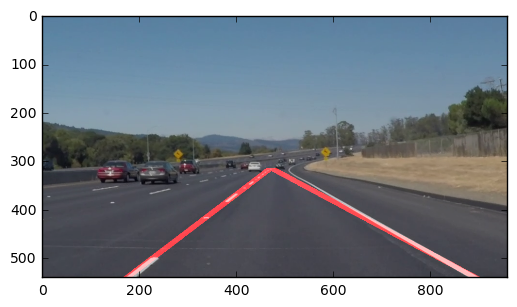

In [12]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

x1 554.222222222
x2 763.0
y1 350.888888889
y2 494.0
x1 259.2
x2 382.533333333
y1 453.4
y2 369.4
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|          | 0/682 [00:00<?, ?it/s]

x1 554.222222222
x2 763.0
y1 350.888888889
y2 494.0
x1

  0%|          | 1/682 [00:00<01:47,  6.35it/s]

 259.2
x2 382.533333333
y1 453.4
y2 369.4
x1 535.571428571
x2 772.285714286
y1 339.0
y2 497.571428571
x1 229.375
x2 395.625
y1 467.75
y2 366.875


  0%|          | 3/682 [00:00<01:46,  6.37it/s]

x1 550.833333333
x2 769.166666667
y1 359.833333333
y2 496.666666667
x1 240.0
x2 420.727272727
y1 463.363636364
y2 346.909090909
x1 524.333333333
x2 785.0
y1 328.333333333
y2 507.666666667
x1 244.0
x2 413.363636364
y1 461.818181818
y2 352.818181818


  1%|          | 5/682 [00:00<01:32,  7.31it/s]

x1 544.857142857
x2 749.785714286
y1 353.071428571
y2 481.928571429
x1 219.1
x2 374.5
y1 477.4
y2 377.2
x1 534.2
x2 679.8
y1 337.2
y2 436.0
x1 273.428571429
x2 453.857142857
y1 443.142857143
y2 328.428571429


  1%|          | 7/682 [00:01<02:01,  5.54it/s]

x1 542.333333333
x2 653.333333333
y1 339.166666667
y2 421.0
x1 247.2
x2 437.2
y1 463.4
y2 341.6


  1%|          | 8/682 [00:01<02:23,  4.71it/s]

x1 512.0
x2 581.0
y1 321.0
y2 364.0
x1 251.333333333
x2 373.0
y1 458.6
y2 380.133333333


  1%|▏         | 9/682 [00:01<02:17,  4.89it/s]

x1 545.125
x2 771.375
y1 341.5
y2 495.75
x1 237.555555556
x2 383.0
y1 469.888888889
y2 379.777777778
x1 584.5


  1%|▏         | 10/682 [00:01<02:24,  4.65it/s]

x2 802.666666667
y1 370.0
y2 513.666666667
x1 261.375
x2 392.25
y1 453.625
y2 371.375


  2%|▏         | 11/682 [00:02<02:20,  4.79it/s]

x1 542.454545455
x2 655.272727273
y1 341.0
y2 414.454545455
x1 249.153846154
x2 379.230769231
y1 461.0
y2 374.153846154


  2%|▏         | 12/682 [00:02<02:24,  4.65it/s]

x1 533.875
x2 722.875
y1 333.25
y2 459.375
x1 221.571428571
x2 413.142857143
y1 483.857142857
y2 351.0


  2%|▏         | 13/682 [00:02<02:13,  5.01it/s]

x1 557.555555556
x2 756.444444444
y1 348.111111111
y2 481.888888889
x1 261.583333333
x2 382.0
y1 455.083333333
y2 376.0
x1 577.857142857
x2 770.571428571
y1 362.857142857
y2 489.571428571
x1 228.384615385
x2 357.923076923
y1 477.153846154
y2 391.307692308


  2%|▏         | 15/682 [00:02<02:09,  5.16it/s]

x1 587.0
x2 804.857142857
y1 370.857142857
y2 509.571428571
x1 159.285714286
x2 369.285714286
y1 527.857142857
y2 389.857142857
x1 574.222222222
x2 792.111111111
y1 362.555555556
y2 501.444444444
x1 256.933333333
x2 361.533333333
y1 459.0
y2 385.866666667


  2%|▏         | 17/682 [00:03<01:55,  5.77it/s]

x1 590.0
x2 794.818181818
y1 370.454545455
y2 503.0
x1 205.333333333
x2 391.666666667
y1 494.888888889
y2 366.666666667
x1 527.333333333
x2 810.222222222
y1 335.555555556
y2 510.555555556
x1 179.111111111
x2 378.888888889
y1 519.0
y2 382.555555556


  3%|▎         | 19/682 [00:03<01:48,  6.12it/s]

x1 539.75
x2 673.5
y1 341.25
y2 420.0
x1 259.8
x2 363.9
y1 458.9
y2 387.7
x1 521.875
x2 716.375
y1 326.5
y2 453.25
x1 225.111111111
x2 413.0
y1 484.777777778
y2 355.333333333


  3%|▎         | 21/682 [00:03<01:37,  6.78it/s]

x1 535.375
x2 675.625
y1 333.5
y2 426.5
x1 268.666666667
x2 432.888888889
y1 452.111111111
y2 338.555555556
x1 529.333333333
x2 786.333333333
y1 341.916666667
y2 494.916666667
x1 261.4
x2 444.0
y1 458.1
y2 337.8


  3%|▎         | 23/682 [00:04<01:43,  6.40it/s]

x1 523.714285714
x2 642.428571429
y1 327.285714286
y2 404.571428571
x1 247.375
x2 434.75
y1 465.25
y2 337.375


  4%|▎         | 24/682 [00:04<02:05,  5.25it/s]

x1 566.625
x2 718.875
y1 356.125
y2 451.875
x1 254.4
x2 412.6
y1 459.0
y2 350.8


  4%|▎         | 25/682 [00:04<02:13,  4.94it/s]

x1 572.0
x2 730.363636364
y1 357.0
y2 459.909090909
x1 256.818181818
x2 393.727272727
y1 463.363636364
y2 363.090909091


  4%|▍         | 26/682 [00:04<02:26,  4.49it/s]

x1 587.125
x2 710.25
y1 371.25
y2 449.0
x1 262.307692308
x2 403.461538462
y1 459.384615385
y2 361.230769231


  4%|▍         | 27/682 [00:05<02:32,  4.29it/s]

x1 603.777777778
x2 756.555555556
y1 381.444444444
y2 473.777777778
x1 272.0
x2 392.933333333
y1 453.066666667
y2 371.066666667


  4%|▍         | 28/682 [00:05<02:39,  4.11it/s]

x1 564.75
x2 765.375
y1 354.875
y2 476.625
x1 249.888888889
x2 353.111111111
y1 466.888888889
y2 397.111111111


  4%|▍         | 29/682 [00:05<02:37,  4.15it/s]

x1 611.0
x2 785.363636364
y1 380.909090909
y2 488.818181818
x1 278.166666667
x2 379.916666667
y1 445.083333333
y2 373.083333333


  4%|▍         | 30/682 [00:05<02:42,  4.01it/s]

x1 550.818181818
x2 775.636363636
y1 344.0
y2 480.363636364
x1 271.615384615
x2 395.230769231
y1 447.076923077
y2 362.538461538


  5%|▍         | 31/682 [00:06<02:35,  4.19it/s]

x1 545.333333333
x2 697.666666667
y1 339.166666667
y2 433.166666667
x1 282.1
x2 429.7
y1 444.2
y2 340.7


  5%|▍         | 32/682 [00:06<02:30,  4.33it/s]

x1 524.0
x2 720.0
y1 325.0
y2 450.0
x1 265.466666667
x2 367.133333333
y1 459.666666667
y2 388.6
x1 549.625
x2

  5%|▍         | 33/682 [00:06<02:19,  4.66it/s]

 702.25
y1 339.75
y2 438.125
x1 252.307692308
x2 388.923076923
y1 466.615384615
y2 367.923076923
x1 556.285714286
x2 755.714285714
y1 344.714285714
y2 472.571428571
x1 220.125
x2 355.375
y1 492.0
y2 396.5


  5%|▌         | 35/682 [00:06<02:12,  4.88it/s]

x1 561.0
x2 816.7
y1 348.6
y2 508.3
x1 210.142857143
x2 376.714285714
y1 499.714285714
y2 380.428571429


  5%|▌         | 36/682 [00:07<02:20,  4.60it/s]

x1 575.625
x2 707.75
y1 355.875
y2 440.125
x1 233.833333333
x2 357.333333333
y1 483.916666667
y2 394.833333333


  5%|▌         | 37/682 [00:07<02:09,  4.98it/s]

x1 585.125
x2 717.125
y1 365.125
y2 445.25
x1 233.666666667
x2 408.333333333
y1 480.333333333
y2 352.222222222
x1 586.857142857
x2 734.285714286
y1 366.285714286
y2 454.0
x1 252.4375
x2 353.6875
y1 467.5625
y2 392.0


  6%|▌         | 39/682 [00:07<02:06,  5.06it/s]

x1 604.272727273
x2 796.0
y1 373.636363636
y2 492.181818182
x1 272.0
x2 391.5
y1 450.7
y2 362.7
x1 538.0
x2 822.333333333
y1 333.333333333
y2 507.333333333
x1 280.846153846
x2 366.923076923
y1 443.076923077
y2 379.538461538


  6%|▌         | 41/682 [00:07<01:55,  5.54it/s]

x1 641.636363636
x2 791.0
y1 399.272727273
y2 488.363636364
x1 248.533333333
x2 384.333333333
y1 469.466666667
y2 368.266666667
x1 607.153846154
x2 782.307692308
y1 381.923076923
y2 484.076923077
x1 188.857142857
x2 345.285714286
y1 511.428571429
y2 395.285714286


  6%|▋         | 43/682 [00:08<01:48,  5.88it/s]

x1 555.222222222
x2 768.0
y1 345.222222222
y2 473.555555556
x1 268.909090909
x2 388.363636364
y1 455.454545455
y2 363.909090909
x1 543.375
x2 692.875
y1 335.875
y2 433.0
x1 246.2
x2 344.6
y1 469.266666667
y2 397.866666667


  7%|▋         | 46/682 [00:08<01:31,  6.92it/s]

x1 522.571428571
x2 668.285714286
y1 323.571428571
y2 418.142857143
x1 221.0
x2 318.125
y1 491.875
y2 424.375
x1 535.125
x2 690.375
y1 340.375
y2 432.375
x1 267.444444444
x2 374.444444444
y1 454.666666667
y2 377.0


  7%|▋         | 47/682 [00:08<01:27,  7.22it/s]

x1 541.5
x2 790.25
y1 345.5
y2 493.625
x1 224.384615385
x2 332.461538462
y1 488.615384615
y2 408.0
x1 541.0
x2 642.625
y1 336.75
y2 403.25
x1 276.0
x2 423.727272727
y1 449.0
y2 342.363636364


  7%|▋         | 49/682 [00:09<01:27,  7.21it/s]

x1 584.5
x2 723.25
y1 364.75
y2 450.5
x1 239.9
x2 388.7
y1 476.8
y2 374.7
x1 566.125
x2 726.125
y1 353.125
y2 452.0
x1 246.909090909
x2 393.909090909
y1 469.181818182
y2 361.818181818


  7%|▋         | 51/682 [00:09<01:32,  6.82it/s]

x1 586.333333333
x2 729.555555556
y1 367.888888889
y2 452.222222222
x1 233.384615385
x2 316.769230769
y1 477.384615385
y2 415.307692308
x1 601.714285714
x2 865.285714286
y1 373.857142857
y2 534.714285714
x1 293.3
x2 441.5
y1 434.2
y2 327.3


  8%|▊         | 53/682 [00:09<01:30,  6.93it/s]

x1 634.555555556
x2 835.222222222
y1 394.222222222
y2 517.666666667
x1 232.571428571
x2 416.142857143
y1 480.428571429
y2 349.285714286
x1 536.0
x2 786.125
y1 336.375
y2 490.75
x1 236.090909091
x2 391.363636364
y1 480.090909091
y2 374.636363636


  8%|▊         | 55/682 [00:10<01:30,  6.93it/s]

x1 567.153846154
x2 767.769230769
y1 358.307692308
y2 479.615384615
x1 231.777777778
x2 434.777777778
y1 482.555555556
y2 337.888888889
x1 550.857142857
x2 658.0
y1 348.142857143
y2 410.142857143
x1 233.3
x2 349.4
y1 479.6
y2 396.3


  8%|▊         | 57/682 [00:10<01:26,  7.25it/s]

x1 518.0
x2 667.285714286
y1 325.428571429
y2 417.428571429
x1 284.866666667
x2 359.4
y1 441.4
y2 388.933333333
x1 540.888888889
x2 774.222222222
y1 338.666666667
y2 490.888888889
x1 204.714285714
x2 470.285714286
y1 502.0
y2 319.571428571


  9%|▉         | 60/682 [00:10<01:20,  7.75it/s]

x1 518.125
x2 750.625
y1 325.25
y2 471.375
x1 253.7
x2 363.7
y1 466.2
y2 388.2
x1 535.909090909
x2 733.636363636
y1 335.0
y2 461.363636364
x1 242.125
x2 383.875
y1 471.375
y2 370.25


  9%|▉         | 61/682 [00:10<01:16,  8.10it/s]

x1 530.666666667
x2 677.833333333
y1 335.0
y2 426.333333333
x1 253.875
x2 404.0
y1 464.5
y2 357.375
x1 565.583333333
x2 700.416666667
y1 356.583333333
y2 439.666666667
x1 236.4
x2 319.666666667
y1 473.8
y2 412.8


  9%|▉         | 64/682 [00:11<01:18,  7.90it/s]

x1 566.111111111
x2 764.333333333
y1 358.0
y2 479.777777778
x1 221.083333333
x2 301.166666667
y1 481.333333333
y2 423.75
x1 564.571428571
x2 775.857142857
y1 354.285714286
y2 484.285714286
x1 222.625
x2 428.5
y1 482.375
y2 336.625


 10%|▉         | 65/682 [00:11<01:15,  8.12it/s]

x1 575.727272727
x2 808.090909091
y1 362.545454545
y2 505.363636364
x1 189.222222222
x2 349.666666667
y1 505.555555556
y2 391.111111111
x1 569.666666667
x2 784.333333333
y1 359.111111111
y2 490.0
x1 241.461538462
x2 331.846153846
y1 468.307692308
y2 403.076923077


 10%|▉         | 67/682 [00:11<01:15,  8.10it/s]

x1 595.357142857
x2 786.785714286
y1 373.571428571
y2 494.357142857
x1 266.1
x2 398.1
y1 452.9
y2 359.0
x1 564.2
x2 813.2
y1 354.7
y2 510.1
x1 207.5
x2 379.875
y1 495.0
y2 371.375


 10%|█         | 69/682 [00:11<01:19,  7.68it/s]

x1 521.0
x2 669.5
y1 328.666666667
y2 423.0
x1 260.3
x2 407.3
y1 457.9
y2 353.5
x1 536.5
x2 669.0
y1 339.25
y2 422.125
x1 234.461538462
x2 340.384615385
y1 475.538461538
y2 399.230769231


 10%|█         | 71/682 [00:12<01:30,  6.76it/s]

x1 525.6
x2 638.6
y1 329.6
y2 408.2
x1 249.555555556
x2 359.555555556
y1 468.0
y2 388.888888889
x1 540.0
x2 788.75
y1 338.75
y2 504.75
x1 273.888888889
x2 415.777777778
y1 452.333333333
y2 348.555555556


 11%|█         | 74/682 [00:12<01:19,  7.63it/s]

x1 516.428571429
x2 642.0
y1 326.714285714
y2 405.571428571
x1 266.083333333
x2 359.833333333
y1 456.5
y2 391.666666667
x1 535.111111111
x2 683.111111111
y1 337.555555556
y2 434.111111111
x1 227.071428571
x2 351.285714286
y1 480.428571429
y2 391.571428571


 11%|█         | 75/682 [00:12<01:22,  7.39it/s]

x1 556.1
x2 696.0
y1 351.3
y2 440.3
x1 215.625
x2 404.125
y1 493.375
y2 359.125
x1 591.625
x2 736.75
y1 374.0
y2 467.25
x1 239.916666667
x2 319.166666667
y1 475.75
y2 421.5


 11%|█▏        | 77/682 [00:13<02:10,  4.63it/s]

x1 576.0
x2 772.636363636
y1 364.636363636
y2 493.363636364
x1 199.857142857
x2 404.285714286
y1 504.857142857
y2 360.285714286


 11%|█▏        | 78/682 [00:13<02:20,  4.29it/s]

x1 564.625
x2 812.375
y1 356.0
y2 515.125
x1 298.117647059
x2 398.0
y1 431.941176471
y2 365.352941176


 12%|█▏        | 79/682 [00:13<02:27,  4.10it/s]

x1 579.5
x2 789.083333333
y1 366.166666667
y2 499.75
x1 230.0
x2 411.5
y1 479.4
y2 349.7
x1 583.3
x2 803.3
y1 369.7
y2 511.4
x1 218.5
x2 388.4
y1 487.1
y2 369.3


 12%|█▏        | 81/682 [00:14<02:37,  3.82it/s]

x1 521.2
x2 661.2
y1 329.0
y2 419.0
x1 239.545454545
x2 397.818181818
y1 471.545454545
y2 362.636363636


 12%|█▏        | 82/682 [00:14<02:36,  3.83it/s]

x1 504.166666667
x2 622.5
y1 316.333333333
y2 398.5
x1 240.1
x2 380.2
y1 471.6
y2 377.0


 12%|█▏        | 83/682 [00:14<02:18,  4.32it/s]

x1 532.111111111
x2 694.888888889
y1 335.888888889
y2 442.555555556
x1 229.272727273
x2 336.272727273
y1 476.909090909
y2 400.181818182


 12%|█▏        | 84/682 [00:15<02:33,  3.91it/s]

x1 520.0
x2 710.875
y1 327.625
y2 454.125
x1 223.789473684
x2 320.736842105
y1 481.210526316
y2 410.578947368


 12%|█▏        | 85/682 [00:15<02:28,  4.01it/s]

x1 554.0
x2 758.857142857
y1 352.0
y2 484.0
x1 256.352941176
x2 330.235294118
y1 457.588235294
y2 404.411764706


 13%|█▎        | 86/682 [00:15<02:34,  3.85it/s]

x1 554.166666667
x2 648.333333333
y1 352.0
y2 410.166666667
x1 201.142857143
x2 370.571428571
y1 497.0
y2 381.857142857


 13%|█▎        | 87/682 [00:15<02:24,  4.11it/s]

x1 539.666666667
x2 672.666666667
y1 342.5
y2 429.0
x1 253.1
x2 379.5
y1 461.1
y2 375.4
x1 548.7
x2 691.0
y1 352.6
y2 

 13%|█▎        | 88/682 [00:16<02:23,  4.13it/s]

438.0
x1 224.8
x2 298.866666667
y1 477.266666667
y2 425.0


 13%|█▎        | 89/682 [00:16<02:15,  4.36it/s]

x1 560.0
x2 756.9
y1 358.1
y2 479.4
x1 244.0
x2 377.0
y1 466.333333333
y2 375.111111111
x1 598.818181818
x2 785.454545455
y1 383.636363636
y2 500.545454545
x1 255.111111111
x2 406.777777778
y1

 13%|█▎        | 90/682 [00:16<02:14,  4.40it/s]

 458.222222222
y2 354.555555556


 13%|█▎        | 91/682 [00:16<02:07,  4.64it/s]

x1 566.5
x2 764.6
y1 360.0
y2 485.7
x1 240.8
x2 424.2
y1 468.7
y2 343.6
x1 602.818181818
x2 788.636363636
y1 384.181818182
y2 501.818181818
x1 220.125
x2 392.375
y1 

 13%|█▎        | 92/682 [00:16<02:06,  4.65it/s]

483.625
y2 366.0
x1 494.7


 14%|█▎        | 93/682 [00:17<02:00,  4.87it/s]

x2 817.2
y1 324.5
y2 522.8
x1 213.5
x2 393.6
y1 492.0
y2 369.0
x1 529.285714286
x2 656.285714286
y1 338.857142857
y2 420.142857143
x1 236.8
x2 371.5
y1 479.5
y2 380.9


 14%|█▍        | 95/682 [00:17<02:03,  4.74it/s]

x1 509.666666667
x2 664.5
y1 325.5
y2 424.5
x1 208.272727273
x2 353.454545455
y1 497.909090909
y2 402.272727273
x1 562.571428571
x2 705.571428571
y1 362.0
y2

 14%|█▍        | 96/682 [00:17<01:58,  4.94it/s]

 453.571428571
x1 248.1
x2 416.5
y1 466.3
y2 350.7
x1 529.0
x2 757.5
y1 338.5
y2 487.0
x1 247.9
x2 405.9
y1 469.0
y2 362.8


 14%|█▍        | 98/682 [00:18<02:01,  4.82it/s]

x1 554.125
x2 747.875
y1 351.375
y2 482.625
x1 245.142857143
x2 420.142857143
y1 469.428571429
y2 349.0
x1 526.125
x2 642.25
y1 333.625
y2 412.625
x1 215.0
x2 439.222222222
y1 

 15%|█▍        | 99/682 [00:18<01:53,  5.12it/s]

491.444444444
y2 341.0
x1 533.0
x2 696.166666667
y1 339.0
y2 445.166666667
x1 238.785714286
x2 345.642857143
y1 473.785714286
y2 397.571428571


 15%|█▍        | 101/682 [00:18<01:44,  5.58it/s]

x1 546.714285714
x2 705.571428571
y1 349.571428571
y2 451.142857143
x1 288.357142857
x2 397.357142857
y1 439.714285714
y2 366.071428571
x1 550.8
x2 726.0
y1 350.6
y2 464.4
x1 245.692307692
x2 382.923076923
y1 468.0
y2 377.076923077


 15%|█▌        | 103/682 [00:18<01:31,  6.31it/s]

x1 555.888888889
x2 780.333333333
y1 355.0
y2 496.333333333
x1 272.2
x2 391.1
y1 450.3
y2 368.5
x1 605.666666667
x2 790.111111111
y1 385.888888889
y2 504.222222222
x1 227.461538462
x2 318.384615385
y1 478.307692308
y2 416.076923077


 15%|█▌        | 105/682 [00:19<01:28,  6.54it/s]

x1 543.111111111
x2 814.222222222
y1 343.777777778
y2 520.222222222
x1 283.7
x2 411.6
y1 439.9
y2 352.2
x1 551.125
x2 822.0
y1 353.125
y2 524.0
x1 271.454545455
x2 417.363636364
y1 450.090909091
y2 351.545454545


 16%|█▌        | 107/682 [00:19<01:22,  6.98it/s]

x1 508.333333333
x2 655.833333333
y1 320.5
y2 419.833333333
x1 270.928571429
x2 385.142857143
y1 447.785714286
y2 370.071428571
x1 525.2
x2 701.0
y1 334.6
y2 448.8
x1 257.470588235
x2 336.588235294
y1 460.235294118
y2 402.470588235


 16%|█▌        | 109/682 [00:19<01:20,  7.11it/s]

x1 532.0
x2 699.0
y1 336.833333333
y2 448.833333333
x1 217.0
x2 381.538461538
y1 487.692307692
y2 378.538461538
x1 534.2
x2 748.8
y1 342.8
y2 478.6
x1 237.928571429
x2 352.0
y1 473.428571429
y2 395.642857143


 16%|█▋        | 112/682 [00:20<01:10,  8.09it/s]

x1 520.0
x2 715.75
y1 331.625
y2 457.0
x1 309.1
x2 431.3
y1 425.7
y2 341.7
x1 533.714285714
x2 671.428571429
y1 339.0
y2 429.142857143
x1 270.0
x2 397.777777778
y1 452.111111111
y2 364.222222222


 17%|█▋        | 113/682 [00:20<01:10,  8.09it/s]

x1 560.0
x2 682.5
y1 363.5
y2 434.2
x1 284.125
x2 439.375
y1 442.875
y2 336.25
x1 596.125
x2 712.875
y1 382.75
y2 453.5
x1 252.285714286
x2 419.0
y1 465.714285714
y2 351.285714286


 17%|█▋        | 115/682 [00:20<01:28,  6.42it/s]

x1 558.333333333
x2 727.416666667
y1 356.25
y2 464.333333333
x1 274.714285714
x2 436.857142857
y1 449.0
y2 337.857142857


 17%|█▋        | 117/682 [00:20<01:16,  7.36it/s]

x1 576.5
x2 739.75
y1 365.416666667
y2 469.166666667
x1 256.684210526
x2 402.052631579
y1 462.052631579
y2 368.789473684
x1 580.333333333
x2 817.777777778
y1 366.444444444
y2 516.222222222
x1 212.2
x2 416.9
y1 493.0
y2 354.7
x1 596.909090909
x2 797.636363636
y1 376.363636364
y2 505.818181818
x1 230.6
x2 371.7
y1 478.3
y2 380.4


 17%|█▋        | 119/682 [00:20<01:08,  8.27it/s]

x1 550.222222222
x2 744.555555556
y1 351.777777778
y2 473.777777778
x1 241.357142857
x2 339.714285714
y1 474.5
y2 404.357142857
x1 543.857142857
x2 695.0
y1 345.857142857
y2 441.571428571
x1 270.454545455
x2 383.272727273
y1 451.363636364
y2 375.0
x1 540.125
x2 681.25
y1 344.25
y2 431.25
x1 214.454545455
x2 315.363636364
y1 491.454545455
y2 419.363636364


 18%|█▊        | 123/682 [00:21<00:57,  9.67it/s]

x1 542.555555556
x2 717.888888889
y1 344.111111111
y2 456.777777778
x1 262.571428571
x2 374.5
y1 458.571428571
y2 384.357142857
x1 518.125
x2 767.625
y1 328.25
y2 489.125
x1 288.4
x2 402.6
y1 440.2
y2 364.4
x1 514.875
x2 626.25
y1 326.75
y2 398.125
x1 240.727272727
x2 405.909090909
y1 478.272727273
y2 359.272727273


 18%|█▊        | 125/682 [00:21<00:54, 10.21it/s]

x1 550.272727273
x2 667.818181818
y1 349.818181818
y2 423.454545455
x1 228.636363636
x2 320.363636364
y1 482.727272727
y2 416.363636364
x1 538.5
x2 700.375
y1 342.5
y2 445.75
x1 243.0
x2 354.538461538
y1 476.307692308
y2 400.846153846
x1 567.166666667
x2 720.416666667
y1 365.0
y2 457.666666667
x1 238.333333333
x2 359.416666667
y1 478.416666667
y2 389.75


 19%|█▉        | 129/682 [00:21<00:50, 10.89it/s]

x1 617.363636364
x2 843.363636364
y1 390.363636364
y2 535.181818182
x1 227.666666667
x2 360.0
y1 483.666666667
y2 390.444444444
x1 566.9
x2 764.8
y1 363.7
y2 485.4
x1 278.416666667
x2 392.0
y1 450.75
y2 373.333333333
x1 520.285714286
x2 755.5
y1 346.357142857
y2 478.714285714
x1 221.272727273
x2 334.909090909
y1 492.727272727
y2 406.727272727


 19%|█▉        | 131/682 [00:21<00:50, 10.91it/s]

x1 586.5
x2 784.416666667
y1 369.916666667
y2 498.416666667
x1 226.666666667
x2 370.666666667
y1 489.666666667
y2 384.666666667
x1 517.0
x2 665.0
y1 329.142857143
y2 422.571428571
x1 243.555555556
x2 414.777777778
y1 475.666666667
y2 358.777777778
x1 542.909090909
x2 625.454545455
y1 347.363636364
y2 394.181818182
x1 269.714285714
x2 444.142857143
y1 457.571428571
y2 333.285714286


 20%|█▉        | 135/682 [00:22<00:48, 11.39it/s]

x1 541.666666667
x2 724.5
y1 345.166666667
y2 459.0
x1 225.181818182
x2 347.090909091
y1 487.181818182
y2 398.636363636
x1 558.636363636
x2 754.454545455
y1 356.454545455
y2 480.636363636
x1 258.333333333
x2 391.75
y1 464.166666667
y2 369.416666667
x1 521.142857143
x2 807.285714286
y1 330.285714286
y2 516.0
x1 260.25
x2 386.416666667
y1 461.416666667
y2 376.666666667


 20%|██        | 137/682 [00:22<00:46, 11.78it/s]

x1 513.571428571
x2 675.428571429
y1 331.0
y2 429.714285714
x1 325.375
x2 449.625
y1 417.875
y2 332.5
x1 551.769230769
x2 677.0
y1 353.615384615
y2 429.076923077
x1 241.571428571
x2 416.714285714
y1 475.0
y2 352.714285714
x1 527.625
x2 698.25
y1 336.25
y2 445.875
x1 205.888888889
x2 391.666666667
y1 502.888888889
y2 371.777777778


 21%|██        | 141/682 [00:22<00:43, 12.47it/s]

x1 608.2
x2 805.9
y1 384.4
y2 511.8
x1 223.769230769
x2 384.769230769
y1 487.461538462
y2 369.307692308
x1 509.461538462
x2 762.0
y1 337.615384615
y2 484.076923077
x1 291.083333333
x2 446.916666667
y1 441.0
y2 336.75
x1 549.666666667
x2 774.444444444
y1 351.333333333
y2 493.888888889
x1 232.0
x2 421.9
y1 483.9
y2 345.7


 21%|██        | 143/682 [00:22<00:42, 12.60it/s]

x1 499.833333333
x2 776.583333333
y1 323.583333333
y2 495.166666667
x1 301.142857143
x2 470.0
y1 434.428571429
y2 320.428571429
x1 567.3
x2 841.9
y1 361.8
y2 532.8
x1 239.75
x2 435.5
y1 477.4375
y2 333.0
x1 512.444444444
x2 634.555555556
y1 330.777777778
y2 401.777777778
x1 268.384615385
x2 449.769230769
y1 457.538461538
y2 324.846153846


 22%|██▏       | 147/682 [00:23<00:43, 12.28it/s]

x1 523.0
x2 694.75
y1 332.5
y2 442.875
x1 265.466666667
x2 408.2
y1 459.333333333
y2 357.466666667
x1 510.285714286
x2 757.857142857
y1 326.142857143
y2 481.571428571
x1 289.8
x2 452.1
y1 439.8
y2 329.0
x1 495.875
x2 734.0
y1 315.25
y2 467.25
x1 251.928571429
x2 377.714285714
y1 465.285714286
y2 374.357142857


 22%|██▏       | 149/682 [00:23<00:44, 12.01it/s]

x1 504.3
x2 615.0
y1 329.1
y2 389.2
x1 231.666666667
x2 424.444444444
y1 478.777777778
y2 345.777777778
x1 530.142857143
x2 690.285714286
y1 332.571428571
y2 439.0
x1 281.875
x2 444.125
y1 446.875
y2 332.75
x1 507.571428571
x2 735.857142857
y1 325.714285714
y2 466.285714286
x1 233.0
x2 416.076923077
y1 483.0
y2 350.076923077


 22%|██▏       | 153/682 [00:23<00:43, 12.28it/s]

x1 539.428571429
x2 744.571428571
y1 346.142857143
y2 473.142857143
x1 280.388888889
x2 401.666666667
y1 450.222222222
y2 361.5
x1 539.666666667
x2 752.416666667
y1 344.75
y2 473.916666667
x1 275.583333333
x2 448.416666667
y1 454.25
y2 330.75
x1 528.0
x2 771.3
y1 340.5
y2 486.2
x1 232.7
x2 347.9
y1 482.5
y2 403.1


 23%|██▎       | 155/682 [00:23<00:42, 12.34it/s]

x1 529.090909091
x2 799.454545455
y1 338.090909091
y2 503.727272727
x1 206.0
x2 461.5
y1 505.875
y2 318.875
x1 492.6
x2 758.0
y1 321.9
y2 476.4
x1 230.2
x2 408.6
y1 487.5
y2 359.4
x1 476.714285714
x2 648.285714286
y1 318.142857143
y2 409.571428571
x1 261.923076923
x2 436.615384615
y1 464.384615385
y2 351.384615385


 23%|██▎       | 159/682 [00:24<00:42, 12.23it/s]

x1 509.0
x2 714.2
y1 328.8
y2 453.2
x1 246.142857143
x2 431.571428571
y1 476.714285714
y2 348.428571429
x1 498.2
x2 702.2
y1 318.0
y2 446.4
x1 267.222222222
x2 405.222222222
y1 462.111111111
y2 363.222222222
x1 496.181818182
x2 722.545454545
y1 324.181818182
y2 456.0
x1 255.4
x2 470.7
y1 472.9
y2 318.8


 24%|██▍       | 163/682 [00:24<00:42, 12.25it/s]

x1 525.166666667
x2 795.833333333
y1 332.666666667
y2 502.166666667
x1 261.615384615
x2 468.307692308
y1 467.230769231
y2 319.0
x1 497.285714286
x2 683.857142857
y1 322.714285714
y2 431.714285714
x1 261.272727273
x2 456.818181818
y1 464.636363636
y2 322.636363636
x1 515.285714286
x2 709.142857143
y1 333.285714286
y2 446.0
x1 269.416666667
x2 390.416666667
y1 463.166666667
y2 378.666666667


 24%|██▍       | 165/682 [00:24<00:41, 12.45it/s]

x1 502.5
x2 714.75
y1 331.25
y2 447.166666667
x1 231.545454545
x2 457.636363636
y1 492.363636364
y2 342.090909091
x1 556.8
x2 812.2
y1 352.0
y2 506.9
x1 276.466666667
x2 428.133333333
y1 457.666666667
y2 345.4
x1 514.181818182
x2 740.090909091
y1 327.363636364
y2 465.0
x1 271.909090909
x2 437.363636364
y1 463.090909091
y2 343.818181818


 24%|██▍       | 167/682 [00:24<00:41, 12.37it/s]

x1 528.454545455
x2 760.909090909
y1 337.272727273
y2 476.454545455
x1 240.125
x2 431.5
y1 483.375
y2 346.375
x1 573.428571429
x2 780.357142857
y1 362.642857143
y2 486.214285714
x1 310.166666667
x2 453.166666667
y1 433.833333333
y2 333.083333333
x1 522.857142857
x2 762.0
y1 333.0
y2 473.857142857
x1 211.909090909
x2 372.181818182
y1 503.818181818
y2 387.909090909


 25%|██▌       | 171/682 [00:25<00:40, 12.59it/s]

x1 512.625
x2 677.625
y1 330.625
y2 423.5
x1 270.875
x2 433.875
y1 464.375
y2 348.0
x1 492.0
x2 742.2
y1 317.6
y2 460.2
x1 293.3
x2 466.5
y1 449.0
y2 327.7
x1 547.25
x2 687.25
y1 347.25
y2 430.5
x1 244.375
x2 418.125
y1 485.25
y2 360.5


 25%|██▌       | 173/682 [00:25<00:40, 12.52it/s]

x1 491.75
x2 836.0
y1 321.0
y2 512.75
x1 200.875
x2 459.25
y1 517.875
y2 337.5
x1 489.8
x2 689.4
y1 317.2
y2 429.4
x1 265.235294118
x2 402.176470588
y1 468.764705882
y2 362.941176471
x1 511.727272727
x2 706.090909091
y1 327.181818182
y2 438.909090909
x1 260.363636364
x2 409.727272727
y1 474.909090909
y2 361.909090909


 26%|██▌       | 177/682 [00:25<00:40, 12.62it/s]

x1 556.545454545
x2 746.636363636
y1 354.909090909
y2 462.636363636
x1 263.8
x2 432.3
y1 472.8
y2 345.2
x1 581.9
x2 773.8
y1 367.1
y2 475.5
x1 250.6875
x2 430.625
y1 483.6875
y2 348.6875
x1 580.727272727
x2 791.727272727
y1 364.545454545
y2 488.545454545
x1 277.0
x2 477.1
y1 459.7
y2 328.9


 26%|██▌       | 179/682 [00:25<00:40, 12.27it/s]

x1 542.846153846
x2 761.076923077
y1 341.769230769
y2 470.538461538
x1 237.833333333
x2 431.333333333
y1 496.5
y2 343.75
x1 517.769230769
x2 773.692307692
y1 358.846153846
y2 504.076923077
x1 218.1
x2 408.2
y1 513.0
y2 373.7
x1 544.111111111
x2 787.111111111
y1 345.888888889
y2 484.888888889
x1 269.0
x2 436.818181818
y1 469.545454545
y2 338.0


 27%|██▋       | 183/682 [00:26<00:42, 11.75it/s]

x1 488.0
x2 682.875
y1 316.75
y2 422.75
x1 213.272727273
x2 430.363636364
y1 512.181818182
y2 339.181818182
x1 499.2
x2 647.2
y1 321.0
y2 403.2
x1 267.777777778
x2 398.111111111
y1 471.333333333
y2 371.444444444
x1 509.571428571
x2 769.571428571
y1 327.714285714
y2 471.428571429
x1 271.285714286
x2 458.428571429
y1 471.214285714
y2 337.285714286


 27%|██▋       | 187/682 [00:26<00:39, 12.59it/s]

x1 494.125
x2 769.25
y1 317.75
y2 471.875
x1 256.125
x2 451.5
y1 479.375
y2 342.75
x1 480.333333333
x2 767.222222222
y1 319.888888889
y2 474.111111111
x1 270.769230769
x2 429.153846154
y1 471.538461538
y2 346.615384615
x1 511.888888889
x2 722.111111111
y1 331.333333333
y2 447.444444444
x1 234.333333333
x2 412.0
y1 499.166666667
y2 366.333333333


 28%|██▊       | 189/682 [00:26<00:38, 12.81it/s]

x1 508.777777778
x2 660.222222222
y1 325.111111111
y2 414.333333333
x1 236.9
x2 455.8
y1 499.1
y2 328.0
x1 529.666666667
x2 710.833333333
y1 345.0
y2 439.0
x1 239.636363636
x2 450.454545455
y1 496.363636364
y2 338.727272727
x1 588.5
x2 776.333333333
y1 365.833333333
y2 480.0
x1 291.111111111
x2 440.666666667
y1 455.111111111
y2 339.222222222


 28%|██▊       | 193/682 [00:26<00:36, 13.56it/s]

x1 501.9
x2 795.3
y1 318.5
y2 490.0
x1 245.25
x2 411.5
y1 494.0
y2 365.25
x1 550.0
x2 765.166666667
y1 359.833333333
y2 470.916666667
x1 263.818181818
x2 402.0
y1 479.545454545
y2 376.0
x1 573.9
x2 820.4
y1 360.3
y2 503.0
x1 280.363636364
x2 417.727272727
y1 463.818181818
y2 359.272727273


 29%|██▊       | 195/682 [00:27<00:35, 13.73it/s]

x1 503.0
x2 822.714285714
y1 321.142857143
y2 505.714285714
x1 265.941176471
x2 422.411764706
y1 474.823529412
y2 358.117647059
x1 512.0
x2 639.285714286
y1 326.142857143
y2 402.428571429
x1 218.916666667
x2 388.583333333
y1 508.916666667
y2 375.583333333
x1 511.714285714
x2 713.857142857
y1 333.285714286
y2 440.0
x1 242.571428571
x2 423.428571429
y1 492.285714286
y2 353.285714286


 29%|██▉       | 199/682 [00:27<00:33, 14.42it/s]

x1 497.8
x2 758.6
y1 317.6
y2 471.6
x1 261.8
x2 396.5
y1 477.8
y2 375.8
x1 492.75
x2 821.125
y1 317.75
y2 505.625
x1 237.0
x2 436.222222222
y1 497.666666667
y2 340.666666667
x1 525.555555556
x2 664.222222222
y1 338.777777778
y2 415.333333333
x1 248.888888889
x2 406.222222222
y1 485.222222222
y2 362.111111111
x1 477.333333333
x2 675.777777778
y1 319.333333333
y2 424.888888889
x1 291.181818182
x2 462.818181818
y1 451.090909091
y2 326.545454545


 30%|██▉       | 203/682 [00:27<00:33, 14.47it/s]

x1 481.2
x2 724.6
y1 317.6
y2 450.5
x1 229.0
x2 425.444444444
y1 498.0
y2 345.666666667
x1 488.333333333
x2 743.0
y1 320.222222222
y2 464.111111111
x1 252.0
x2 434.111111111
y1 484.111111111
y2 341.111111111
x1 513.272727273
x2 811.636363636
y1 336.545454545
y2 500.545454545
x1 262.384615385
x2 436.384615385
y1 475.461538462
y2 346.153846154


 30%|███       | 205/682 [00:27<00:33, 14.16it/s]

x1 481.307692308
x2 814.230769231
y1 320.846153846
y2 505.076923077
x1 219.888888889
x2 385.0
y1 504.333333333
y2 371.222222222
x1 534.222222222
x2 787.444444444
y1 341.555555556
y2 491.222222222
x1 268.222222222
x2 468.0
y1 469.111111111
y2 321.333333333
x1 483.375
x2 836.875
y1 320.75
y2 519.125
x1 231.888888889
x2 452.777777778
y1 494.555555556
y2 338.666666667


 31%|███       | 209/682 [00:28<00:32, 14.44it/s]

x1 497.857142857
x2 688.285714286
y1 321.714285714
y2 434.285714286
x1 269.545454545
x2 469.818181818
y1 463.636363636
y2 320.636363636
x1 463.0
x2 728.9
y1 317.6
y2 456.3
x1 223.0
x2 438.333333333
y1 503.666666667
y2 346.0
x1 506.571428571
x2 704.428571429
y1 325.857142857
y2 445.142857143
x1 236.545454545
x2 459.545454545
y1 492.727272727
y2 333.272727273


 31%|███       | 211/682 [00:28<00:32, 14.56it/s]

x1 488.0
x2 755.2
y1 320.4
y2 470.8
x1 273.4
x2 427.6
y1 460.6
y2 351.4
x1 508.857142857
x2 744.714285714
y1 329.428571429
y2 467.142857143
x1 224.733333333
x2 413.6
y1 496.133333333
y2 355.333333333
x1 520.571428571
x2 678.285714286
y1 336.714285714
y2 431.0
x1 205.666666667
x2 384.222222222
y1 508.555555556
y2 374.666666667


 32%|███▏      | 215/682 [00:28<00:32, 14.21it/s]

x1 514.0
x2 724.875
y1 333.5
y2 458.75
x1 255.076923077
x2 353.692307692
y1 472.692307692
y2 398.0
x1 491.5
x2 782.666666667
y1 319.333333333
y2 490.833333333
x1 287.428571429
x2 449.714285714
y1 450.142857143
y2 329.714285714
x1 515.375
x2 801.125
y1 334.75
y2 505.125
x1 228.888888889
x2 408.777777778
y1 493.444444444
y2 359.555555556


 32%|███▏      | 217/682 [00:28<00:32, 14.27it/s]

x1 543.333333333
x2 837.666666667
y1 352.333333333
y2 524.5
x1 214.375
x2 429.875
y1 505.75
y2 343.625
x1 472.875
x2 821.5
y1 317.25
y2 518.25
x1 272.5
x2 453.166666667
y1 459.166666667
y2 327.333333333
x1 486.0
x2 839.125
y1 318.375
y2 525.25
x1 266.857142857
x2 457.857142857
y1 462.142857143
y2 323.428571429
x1 480.571428571
x2 676.857142857
y1 316.0
y2 429.142857143
x1 306.571428571
x2 460.142857143
y1 433.571428571
y2 322.857142857


 32%|███▏      | 221/682 [00:28<00:30, 15.07it/s]

x1 492.571428571
x2 682.571428571
y1 317.857142857
y2 432.571428571
x1 296.0
x2 456.375
y1 440.125
y2 324.25
x1 509.375
x2 683.25
y1 330.5
y2 434.125
x1 276.909090909
x2 433.636363636
y1 456.454545455
y2 345.909090909
x1 549.5
x2 763.9
y1 352.5
y2 481.7
x1 255.25
x2 386.375
y1 471.75
y2 378.625


 33%|███▎      | 225/682 [00:29<00:32, 14.02it/s]

x1 538.571428571
x2 807.857142857
y1 349.0
y2 507.714285714
x1 255.133333333
x2 393.6
y1 470.533333333
y2 369.866666667
x1 530.428571429
x2 684.0
y1 340.0
y2 433.285714286
x1 293.818181818
x2 417.454545455
y1 443.181818182
y2 355.090909091
x1 511.777777778
x2 659.333333333
y1 334.555555556
y2 418.0
x1 244.625
x2 442.5
y1 481.0
y2 336.125


 33%|███▎      | 227/682 [00:29<00:33, 13.62it/s]

x1 523.222222222
x2 728.333333333
y1 338.888888889
y2 460.444444444
x1 284.0
x2 464.0
y1 452.222222222
y2 320.777777778
x1 492.909090909
x2 811.636363636
y1 325.0
y2 509.545454545
x1 228.142857143
x2 397.928571429
y1 489.5
y2 362.428571429
x1 489.8
x2 781.4
y1 319.3
y2 491.1
x1 263.777777778
x2 467.555555556
y1 465.444444444
y2 318.555555556


 34%|███▍      | 231/682 [00:29<00:31, 14.16it/s]

x1 533.25
x2 810.125
y1 348.375
y2 508.375
x1 236.75
x2 399.916666667
y1 483.333333333
y2 363.833333333
x1 527.545454545
x2 745.363636364
y1 336.090909091
y2 471.727272727
x1 281.769230769
x2 426.0
y1 452.076923077
y2 351.923076923
x1 479.833333333
x2 852.666666667
y1 316.0
y2 535.0
x1 285.916666667
x2 406.75
y1 447.833333333
y2 361.833333333
x1 499.6
x2 663.2
y1 323.8
y2 417.2
x1 291.166666667
x2 433.333333333
y1 443.0
y2 343.25


 34%|███▍      | 235/682 [00:29<00:30, 14.72it/s]

x1 492.3
x2 648.2
y1 320.6
y2 411.4
x1 235.363636364
x2 367.545454545
y1 480.0
y2 384.636363636
x1 486.285714286
x2 725.142857143
y1 316.714285714
y2 458.428571429
x1 283.833333333
x2 460.0
y1 449.666666667
y2 325.333333333
x1 514.090909091
x2 739.363636364
y1 329.727272727
y2 470.909090909
x1 255.5
x2 441.5
y1 468.0625
y2 336.375
x1 489.666666667
x2 673.888888889
y1 323.777777778
y2 426.666666667
x1 255.727272727
x2 409.454545455
y1 467.909090909
y2 359.545454545


 35%|███▌      | 239/682 [00:30<00:30, 14.30it/s]

x1 487.666666667
x2 696.166666667
y1 315.333333333
y2 438.5
x1 268.9
x2 399.9
y1 456.0
y2 362.5
x1 556.428571429
x2 725.0
y1 356.285714286
y2 455.0
x1 234.0
x2 458.555555556
y1 483.555555556
y2 321.888888889
x1 581.833333333
x2 771.083333333
y1 367.0
y2 484.5
x1 246.75
x2 443.375
y1 475.25
y2 333.125


 35%|███▌      | 241/682 [00:30<00:31, 14.11it/s]

x1 511.307692308
x2 817.846153846
y1 339.230769231
y2 511.615384615
x1 244.6
x2 415.8
y1 475.0
y2 352.0
x1 536.538461538
x2 761.230769231
y1 347.0
y2 476.307692308
x1 221.444444444
x2 425.888888889
y1 491.222222222
y2 342.444444444
x1 560.090909091
x2 764.636363636
y1 360.0
y2 480.818181818
x1 210.875
x2 458.625
y1 498.0
y2 319.5


 36%|███▌      | 245/682 [00:30<00:29, 14.75it/s]

x1 559.142857143
x2 807.285714286
y1 355.0
y2 508.142857143
x1 236.181818182
x2 367.363636364
y1 479.181818182
y2 384.0
x1 494.0
x2 652.666666667
y1 318.666666667
y2 414.666666667
x1 227.0
x2 400.818181818
y1 485.818181818
y2 360.727272727
x1 484.5
x2 695.9
y1 316.2
y2 437.6
x1 250.142857143
x2 421.357142857
y1 468.357142857
y2 344.642857143
x1 495.0
x2 709.625
y1 317.25
y2 449.625
x1 208.181818182
x2 329.090909091
y1 499.090909091
y2 411.090909091


 37%|███▋      | 249/682 [00:30<00:30, 14.33it/s]

x1 503.833333333
x2 753.333333333
y1 324.416666667
y2 476.166666667
x1 264.294117647
x2 457.823529412
y1 461.411764706
y2 334.470588235
x1 511.0
x2 635.833333333
y1 330.833333333
y2 406.333333333
x1 214.153846154
x2 414.615384615
y1 494.923076923
y2 350.153846154
x1 491.8
x2 635.6
y1 318.0
y2 405.4
x1 261.444444444
x2 449.333333333
y1 466.555555556
y2 337.777777778


 37%|███▋      | 251/682 [00:30<00:30, 14.31it/s]

x1 501.6
x2 642.0
y1 320.0
y2 410.7
x1 222.6
x2 472.3
y1 492.6
y2 319.3
x1 507.555555556
x2 682.222222222
y1 323.0
y2 433.888888889
x1 277.5
x2 444.5625
y1 452.25
y2 340.25
x1 496.3
x2 729.2
y1 318.8
y2 462.4
x1 210.8
x2 434.2
y1 497.8
y2 338.1


 37%|███▋      | 255/682 [00:31<00:29, 14.55it/s]

x1 546.916666667
x2 755.25
y1 349.166666667
y2 478.333333333
x1 242.272727273
x2 390.272727273
y1 474.909090909
y2 368.636363636
x1 481.9
x2 789.6
y1 322.0
y2 500.9
x1 235.5
x2 446.4
y1 482.9
y2 336.6
x1 559.166666667
x2 815.916666667
y1 352.083333333
y2 514.833333333
x1 270.0
x2 423.1875
y1 459.625
y2 354.25


 38%|███▊      | 257/682 [00:31<00:29, 14.59it/s]

x1 501.0
x2 730.333333333
y1 331.333333333
y2 460.833333333
x1 228.307692308
x2 391.384615385
y1 489.153846154
y2 374.307692308
x1 552.083333333
x2 796.5
y1 355.083333333
y2 503.333333333
x1 225.461538462
x2 359.230769231
y1 490.230769231
y2 390.076923077
x1 487.571428571
x2 665.428571429
y1 318.857142857
y2 423.0
x1 223.571428571
x2 398.5
y1 493.214285714
y2 360.857142857


 38%|███▊      | 261/682 [00:31<00:28, 14.76it/s]

x1 485.333333333
x2 643.833333333
y1 320.333333333
y2 409.0
x1 272.333333333
x2 396.0
y1 457.666666667
y2 364.583333333
x1 513.0
x2 683.0
y1 329.777777778
y2 435.444444444
x1 281.777777778
x2 477.777777778
y1 448.666666667
y2 322.777777778
x1 504.181818182
x2 749.272727273
y1 323.818181818
y2 475.0
x1 307.111111111
x2 459.444444444
y1 429.222222222
y2 326.444444444
x1 510.333333333
x2 804.888888889
y1 331.111111111
y2 509.444444444


 39%|███▊      | 263/682 [00:31<00:28, 14.79it/s]

x1 237.0
x2 402.666666667
y1 482.888888889
y2 359.111111111
x1 510.5
x2 689.5
y1 326.75
y2 438.5
x1 241.363636364
x2 451.272727273
y1 483.0
y2 339.0
x1 513.625
x2 684.875
y1 335.5
y2 435.5
x1 276.3
x2 438.1
y1 453.7
y2 339.2
x1 522.111111111
x2 735.0
y1 335.777777778
y2 464.666666667
x1 244.0
x2 442.666666667
y1 478.222222222
y2 339.888888889


 39%|███▉      | 267/682 [00:32<00:27, 14.93it/s]

x1 563.75
x2 773.625
y1 360.625
y2 487.25
x1 231.5
x2 437.875
y1 484.75
y2 337.75
x1 570.714285714
x2 775.285714286
y1 359.357142857
y2 487.642857143
x1 229.857142857
x2 433.571428571
y1 486.428571429
y2 340.714285714
x1 566.0625
x2 763.8125
y1 360.125
y2 481.8125
x1 248.363636364
x2 378.727272727
y1 473.0
y2 379.454545455
x1 499.75
x2 748.0
y1 320.875
y2 472.5
x1 252.0
x2 468.444444444
y1 470.666666667
y2 316.777777778


 40%|███▉      | 271/682 [00:32<00:27, 15.19it/s]

x1 490.625
x2 811.0
y1 319.125
y2 508.5
x1 215.428571429
x2 427.285714286
y1 499.0
y2 347.857142857
x1 506.375
x2 699.25
y1 327.25
y2 440.375
x1 243.888888889
x2 402.444444444
y1 476.888888889
y2 363.888888889
x1 484.555555556
x2 692.666666667
y1 322.555555556
y2 435.666666667
x1 178.0
x2 466.2
y1 524.8
y2 320.0
x1 478.0
x2 697.5
y1 318.0
y2 437.875
x1 232.818181818
x2 436.090909091
y1 489.272727273
y2 348.0


 40%|████      | 275/682 [00:32<00:26, 15.52it/s]

x1 492.857142857
x2 790.285714286
y1 318.714285714
y2 493.571428571
x1 284.875
x2 444.0
y1 451.625
y2 338.375
x1 507.571428571
x2 648.142857143
y1 326.428571429
y2 410.857142857
x1 236.571428571
x2 461.428571429
y1 485.428571429
y2 325.571428571
x1 499.142857143
x2 645.857142857
y1 326.285714286
y2 406.714285714
x1 229.181818182
x2 399.909090909
y1 491.545454545
y2 373.454545455
x1 517.1
x2 717.9
y1 332.3
y2 449.4
x1 219.0
x2 437.2
y1 494.0
y2 336.1


 41%|████      | 279/682 [00:32<00:26, 15.44it/s]

x1 510.111111111
x2 693.777777778
y1 326.111111111
y2 435.555555556
x1 227.777777778
x2 448.444444444
y1 489.444444444
y2 330.444444444
x1 531.818181818
x2 786.727272727
y1 340.909090909
y2 490.818181818
x1 263.0
x2 439.5
y1 461.5625
y2 345.125
x1 490.2
x2 756.6
y1 320.5
y2 476.4
x1 242.666666667
x2 427.266666667
y1 481.133333333
y2 344.2


 41%|████      | 281/682 [00:32<00:26, 14.97it/s]

x1 496.222222222
x2 800.666666667
y1 323.0
y2 499.222222222
x1 196.333333333
x2 466.0
y1 501.111111111
y2 319.444444444
x1 520.444444444
x2 800.111111111
y1 339.777777778
y2 501.222222222
x1 210.4
x2 469.8
y1 506.2
y2 316.6
x1 482.875
x2 684.125
y1 316.5
y2 433.5
x1 240.5
x2 469.5
y1 481.0
y2 318.5


 42%|████▏     | 285/682 [00:33<00:27, 14.45it/s]

x1 510.6
x2 721.2
y1 333.0
y2 454.4
x1 262.636363636
x2 463.909090909
y1 466.727272727
y2 325.181818182
x1 486.444444444
x2 744.444444444
y1 321.777777778
y2 466.555555556
x1 270.416666667
x2 466.25
y1 463.416666667
y2 327.25
x1 476.307692308
x2 770.615384615
y1 327.0
y2 482.230769231
x1 236.454545455
x2 440.545454545
y1 485.454545455
y2 342.363636364
x1 511.833333333
x2 811.833333333
y1 336.0
y2 507.833333333
x1 198.75
x2 448.125
y1 513.5
y2 330.5


 42%|████▏     | 289/682 [00:33<00:26, 14.88it/s]

x1 492.7
x2 648.6
y1 352.7
y2 439.4
x1 239.272727273
x2 448.090909091
y1 484.909090909
y2 337.0
x1 469.25
x2 697.5
y1 316.5
y2 442.75
x1 212.666666667
x2 478.555555556
y1 504.444444444
y2 317.555555556
x1 446.166666667
x2 701.166666667
y1 335.0
y2 483.0
x1 229.75
x2 443.375
y1 498.5
y2 337.75


 43%|████▎     | 293/682 [00:33<00:26, 14.51it/s]

x1 474.125
x2 816.0
y1 317.25
y2 516.125
x1 214.285714286
x2 472.285714286
y1 507.714285714
y2 319.571428571
x1 473.285714286
x2 792.714285714
y1 319.571428571
y2 503.0
x1 262.133333333
x2 443.533333333
y1 466.8
y2 336.733333333
x1 481.181818182
x2 747.636363636
y1 326.454545455
y2 475.454545455
x1 240.363636364
x2 464.272727273
y1 481.181818182
y2 324.545454545


 43%|████▎     | 295/682 [00:33<00:26, 14.46it/s]

x1 498.75
x2 748.0
y1 326.25
y2 474.0
x1 197.285714286
x2 384.857142857
y1 515.142857143
y2 376.714285714
x1 494.25
x2 652.75
y1 327.125
y2 415.25
x1 269.111111111
x2 389.666666667
y1 464.0
y2 378.444444444
x1 501.875
x2 682.5
y1 323.75
y2 437.75
x1 280.083333333
x2 447.75
y1 453.583333333
y2 337.916666667


 44%|████▍     | 299/682 [00:34<00:25, 14.95it/s]

x1 507.375
x2 698.875
y1 327.875
y2 444.875
x1 282.125
x2 465.125
y1 452.75
y2 320.0
x1 492.75
x2 702.75
y1 317.125
y2 449.25
x1 231.2
x2 432.5
y1 490.6
y2 347.6
x1 480.375
x2 779.5
y1 318.0
y2 492.5
x1 201.142857143
x2 487.285714286
y1 514.0
y2 317.0
x1 524.0
x2 682.125
y1 341.75
y2 435.875
x1 214.727272727
x2 425.272727273
y1 502.090909091
y2 351.727272727


 44%|████▍     | 303/682 [00:34<00:25, 14.75it/s]

x1 491.0
x2 678.833333333
y1 317.166666667
y2 435.666666667
x1 277.6875
x2 459.5625
y1 456.5625
y2 329.75
x1 499.875
x2 702.375
y1 322.25
y2 449.25
x1 226.090909091
x2 415.090909091
y1 493.545454545
y2 353.636363636
x1 518.666666667
x2 786.0
y1 331.333333333
y2 500.0
x1 293.3125
x2 458.0
y1 446.75
y2 330.875


 45%|████▍     | 305/682 [00:34<00:25, 14.75it/s]

x1 505.75
x2 798.875
y1 325.625
y2 505.875
x1 261.4
x2 392.933333333
y1 464.6
y2 366.133333333
x1 535.818181818
x2 752.363636364
y1 346.090909091
y2 477.545454545
x1 236.538461538
x2 351.615384615
y1 483.461538462
y2 395.461538462
x1 537.916666667
x2 774.0
y1 351.0
y2 489.166666667
x1 211.285714286
x2 315.142857143
y1 499.857142857
y2 421.714285714
x1 515.6
x2 757.0
y1 337.0


 45%|████▌     | 309/682 [00:34<00:24, 15.12it/s]

y2 478.4
x1 278.909090909
x2 390.636363636
y1 450.454545455
y2 368.818181818
x1 500.714285714
x2 666.714285714
y1 323.428571429
y2 423.428571429
x1 199.0
x2 398.111111111
y1 508.222222222
y2 360.333333333
x1 505.166666667
x2 711.666666667
y1 321.833333333
y2 453.666666667
x1 217.923076923
x2 330.153846154
y1 496.307692308
y2 409.307692308
x1 521.5
x2 773.5
y1 333.5
y2 488.5
x1 257.8
x2 431.9
y1 467.3
y2 346.9


 46%|████▌     | 313/682 [00:35<00:24, 14.99it/s]

x1 549.909090909
x2 792.818181818
y1 354.0
y2 498.727272727
x1 245.5
x2 406.875
y1 474.125
y2 359.125
x1 527.4
x2 652.2
y1 340.6
y2 410.2
x1 257.625
x2 403.75
y1 464.625
y2 360.375
x1 520.625
x2 696.0
y1 334.625
y2 441.625
x1 265.266666667
x2 374.666666667
y1 456.8
y2 379.133333333
x1 

 46%|████▌     | 315/682 [00:35<00:24, 14.92it/s]

493.666666667
x2 708.5
y1 329.0
y2 443.5
x1 235.25
x2 351.416666667
y1 479.083333333
y2 396.916666667
x1 530.428571429
x2 775.428571429
y1 342.857142857
y2 489.0
x1 250.0
x2 422.0
y1 471.066666667
y2 352.533333333
x1 501.0
x2 739.0
y1 323.571428571
y2 468.0
x1 230.0
x2 410.090909091
y1 485.272727273
y2 355.363636364
x1 553.0
x2 742.75
y1 353.583333333
y2 470.416666667
x1 239.0
x2 445.090909091
y1 478.454545455
y2 340.090909091


 47%|████▋     | 319/682 [00:35<00:23, 15.13it/s]

x1 532.7
x2 797.1
y1 344.6
y2 501.4
x1 216.1
x2 420.6
y1 500.8
y2 349.2
x1 526.25
x2 756.125
y1 337.375
y2 478.875
x1 257.6
x2 398.8
y1 465.533333333
y2 364.666666667
x1 499.142857143
x2 672.714285714
y1 321.571428571
y2 428.142857143
x1 209.75
x2 353.8125
y1 498.9375
y2 395.5625
x1 481.166666667
x2 730.333333333
y1 318.333333333
y2 459.0
x1 175.2
x2 351.6
y1 524.2
y2 394.3


 47%|████▋     | 323/682 [00:35<00:23, 15.12it/s]

x1 511.0
x2 680.0
y1 333.714285714
y2 429.0
x1 255.454545455
x2 399.454545455
y1 468.181818182
y2 359.363636364
x1 480.571428571
x2 813.428571429
y1 317.285714286
y2 511.285714286
x1 255.363636364
x2 460.454545455
y1 468.545454545
y2 325.545454545
x1 499.375
x2 669.625
y1 327.0
y2 423.875
x1 264.2
x2 449.3
y1 462.4
y2 333.8


 48%|████▊     | 327/682 [00:36<00:23, 14.94it/s]

x1 531.416666667
x2 693.0
y1 343.0
y2 441.0
x1 226.533333333
x2 385.933333333
y1 488.8
y2 369.933333333
x1 487.142857143
x2 707.285714286
y1 319.285714286
y2 448.142857143
x1 238.166666667
x2 438.083333333
y1 480.833333333
y2 341.833333333
x1 535.4
x2 777.4
y1 351.0
y2 492.7
x1 204.666666667
x2 414.833333333
y1 502.0
y2 350.666666667


 48%|████▊     | 329/682 [00:36<00:23, 15.00it/s]

x1 522.692307692
x2 782.307692308
y1 343.538461538
y2 497.230769231
x1 249.166666667
x2 435.0
y1 476.25
y2 338.583333333
x1 480.133333333
x2 784.866666667
y1 317.066666667
y2 499.466666667
x1 196.285714286
x2 475.142857143
y1 513.571428571
y2 316.142857143
x1 477.0
x2 815.714285714
y1 317.0
y2 515.857142857
x1 250.0
x2 413.666666667
y1 468.25
y2 351.5
x1 512.4
x2 835.7
y1 329.9
y2 529.2
x1 205.2
x2 464.8
y1 507.1
y2 323.0


 49%|████▉     | 333/682 [00:36<00:23, 14.96it/s]

x1 491.571428571
x2 640.285714286
y1 318.571428571
y2 408.142857143
x1 256.0
x2 365.2
y1 463.8
y2 382.733333333
x1 492.444444444
x2 701.111111111
y1 319.777777778
y2 444.666666667
x1 261.666666667
x2 429.083333333
y1 458.75
y2 338.583333333
x1 480.5
x2 685.833333333
y1 316.166666667
y2 436.666666667
x1 247.6
x2 438.2
y1 469.0
y2 343.7


 49%|████▉     | 337/682 [00:36<00:23, 14.91it/s]

x1 486.75
x2 742.875
y1 319.375
y2 475.0
x1 233.846153846
x2 481.923076923
y1 480.615384615
y2 319.384615385
x1 518.166666667
x2 615.833333333
y1 331.833333333
y2 395.833333333
x1 206.0
x2 464.0
y1 497.0
y2 319.6
x1 514.6
x2 679.8
y1 340.0
y2 436.6
x1 233.538461538
x2 435.846153846
y1 480.769230769
y2 348.0
x1 467.0
x2 726.111111111
y1 317.333333333
y2 461.666666667
x1 281.0

 50%|████▉     | 339/682 [00:36<00:22, 15.03it/s]


x2 424.888888889
y1 446.888888889
y2 348.333333333
x1 503.125
x2 705.375
y1 326.625
y2 450.75
x1 217.363636364
x2 389.545454545
y1 489.272727273
y2 372.0
x1 478.9
x2 783.6
y1 318.3
y2 498.3
x1 170.25
x2 397.125
y1 519.125
y2 364.125
x1 543.666666667
x2 804.666666667
y1 349.333333333
y2 510.555555556
x1 274.0
x2 465.444444444
y1 451.555555556
y2 321.555555556


 50%|█████     | 343/682 [00:37<00:22, 15.00it/s]

x1 510.428571429
x2 747.357142857
y1 330.571428571
y2 477.785714286
x1 252.888888889
x2 427.333333333
y1 463.222222222
y2 343.888888889
x1 488.357142857
x2 819.428571429
y1 328.857142857
y2 521.285714286
x1 197.571428571
x2 472.285714286
y1 505.714285714
y2 319.142857143
x1 502.333333333
x2 676.333333333
y1 328.166666667
y2 429.166666667
x1 240.333333333
x2 414.333333333
y1 475.166666667
y2 356.5
x1 500.714285714
x2 624.857142857
y1 324.142857143
y2 400.0
x1 245.25
x2 459.75
y1 470.0
y2 322.125


 51%|█████     | 347/682 [00:37<00:22, 14.83it/s]

x1 496.333333333
x2 704.555555556
y1 326.222222222
y2 447.444444444
x1 216.833333333
x2 462.166666667
y1 489.333333333
y2 321.166666667
x1 494.25
x2 661.75
y1 319.375
y2 424.0
x1 247.0
x2 462.0
y1 466.285714286
y2 319.0
x1 508.0
x2 780.0
y1 325.571428571
y2 499.142857143
x1 217.714285714
x2 354.714285714
y1 490.5
y2 393.642857143
x1 495.888888889
x2 690.333333333
y1 317.555555556
y2 441.444444444
x1 245.0
x2 408.823529412
y1 472.117647059
y2 359.294117647

 51%|█████▏    | 351/682 [00:37<00:21, 15.12it/s]


x1 484.714285714
x2 694.857142857
y1 317.0
y2 443.714285714
x1 224.6875
x2 360.3125
y1 485.5625
y2 390.4375
x1 501.0
x2 739.8
y1 317.5
y2 474.1
x1 230.285714286
x2 416.0
y1 482.428571429
y2 354.857142857
x1 546.727272727
x2 753.909090909
y1 359.272727273
y2 476.181818182
x1 221.5
x2 475.5
y1 489.8
y2 316.5
x1 555.4
x2 800.7
y1 359.7
y2 506.2
x1 241.916666667
x2 440.0
y1 474.75
y2 336.0


 52%|█████▏    | 355/682 [00:37<00:21, 15.12it/s]

x1 540.25
x2 778.75
y1 352.0
y2 493.125
x1 252.133333333
x2 443.866666667
y1 467.466666667
y2 338.733333333
x1 507.875
x2 727.5
y1 333.375
y2 461.75
x1 230.142857143
x2 460.857142857
y1 481.0
y2 326.285714286
x1 485.4
x2 656.0
y1 316.4
y2 418.4
x1 206.076923077
x2 417.461538462
y1 500.230769231
y2 346.538461538


 53%|█████▎    | 359/682 [00:38<00:21, 15.10it/s]

x1 496.875
x2 680.375
y1 323.25
y2 433.375
x1 263.166666667
x2 458.166666667
y1 457.666666667
y2 323.916666667
x1 494.571428571
x2 706.857142857
y1 319.714285714
y2 450.571428571
x1 260.375
x2 392.25
y1 465.875
y2 366.125
x1 522.666666667
x2 723.222222222
y1 337.777777778
y2 465.0
x1 222.5
x2 412.0
y1 484.625
y2 354.125
x1 492.363636364
x2 800.909090909
y1 328.272727273
y2 509.0
x1 159.0
x2 415.6
y1 528.2
y2 352.0


 53%|█████▎    | 363/682 [00:38<00:20, 15.25it/s]

x1 502.363636364
x2 647.090909091
y1 326.909090909
y2 415.272727273
x1 266.125
x2 461.0
y1 454.25
y2 320.125
x1 488.5
x2 719.666666667
y1 316.5
y2 459.166666667
x1 261.714285714
x2 465.571428571
y1 458.142857143
y2 318.285714286
x1 505.0
x2 729.6
y1 327.5
y2 464.4
x1 238.888888889
x2 421.777777778
y1 475.111111111
y2 348.333333333
x1 543.666666667
x2 790.666666667
y1 343.444444444
y2 503.666666667
x1 209.333333333
x2 

 54%|█████▎    | 365/682 [00:38<00:21, 14.99it/s]

446.666666667
y1 497.166666667
y2 335.666666667
x1 514.2
x2 762.933333333
y1 334.0
y2 487.533333333
x1 220.444444444
x2 455.777777778
y1 491.444444444
y2 332.888888889
x1 499.727272727
x2 793.090909091
y1 335.181818182
y2 506.0
x1 183.909090909
x2 354.090909091
y1 516.0
y2 393.636363636
x1 513.4
x2 779.2
y1 344.9
y2 492.5
x1 247.0
x2

 54%|█████▍    | 369/682 [00:38<00:20, 15.19it/s]

 438.9
y1 472.7
y2 345.0
x1 505.875
x2 696.0
y1 333.5
y2 432.375
x1 207.25
x2 398.25
y1 500.416666667
y2 363.916666667
x1 486.875
x2 703.75
y1 325.25
y2 437.625
x1 256.444444444
x2 436.222222222
y1 466.777777778
y2 336.888888889
x1 480.5
x2 712.25
y1 315.0
y2 447.75
x1 228.294117647
x2 362.529411765
y1 485.764705882
y2 383.764705882


 55%|█████▍    | 373/682 [00:39<00:20, 15.11it/s]

x1 500.625
x2 748.25
y1 328.375
y2 470.0
x1 221.333333333
x2 408.555555556
y1 490.111111111
y2 355.555555556
x1 516.571428571
x2 760.857142857
y1 332.571428571
y2 486.714285714
x1 204.818181818
x2 399.545454545
y1 500.0
y2 360.181818182
x1 483.875
x2 657.625
y1 317.5
y2 420.875
x1 219.142857143
x2 463.142857143
y1 489.571428571
y2 316.571428571
x1

 55%|█████▍    | 375/682 [00:39<00:20, 14.95it/s]

 499.9
x2 705.4
y1 328.2
y2 449.0
x1 291.714285714
x2 401.714285714
y1 438.5
y2 360.642857143
x1 506.545454545
x2 746.363636364
y1 329.363636364
y2 476.272727273
x1 281.928571429
x2 426.0
y1 446.285714286
y2 347.785714286
x1 489.363636364
x2 773.181818182
y1 316.363636364
y2 491.909090909
x1 250.625
x2 438.625
y1 470.125
y2 335.625
x1 534.888888889
x2 776.222222222
y1 349.111111111
y2 495.666666667
x1 253.631578947
x2 379.736842105
y1 464.368421053
y2 378.684210526


 56%|█████▌    | 379/682 [00:39<00:19, 15.38it/s]

x1 486.5
x2 736.1
y1 321.1
y2 470.2
x1 233.833333333
x2 459.333333333
y1 478.0
y2 316.666666667
x1 507.7
x2 806.7
y1 333.6
y2 513.4
x1 266.9
x2 422.7
y1 447.8
y2 342.1
x1 479.125
x2 707.125
y1 316.125
y2 451.5
x1 224.0
x2 350.153846154
y1 482.384615385
y2 391.461538462


 56%|█████▌    | 383/682 [00:39<00:19, 15.02it/s]

x1 486.5
x2 699.666666667
y1 319.333333333
y2 443.666666667
x1 260.4
x2 376.066666667
y1 456.933333333
y2 373.8
x1 483.5
x2 711.333333333
y1 316.0
y2 453.833333333
x1 195.0
x2 437.285714286
y1 502.714285714
y2 339.285714286
x1 521.75
x2 748.125
y1 340.875
y2 477.375
x1 231.4
x2 447.6
y1 479.6
y2 328.2


 56%|█████▋    | 385/682 [00:39<00:21, 14.05it/s]

x1 518.375
x2 789.375
y1 339.75
y2 502.0
x1 242.75
x2 414.625
y1 470.5
y2 349.25
x1 480.625
x2 667.625
y1 319.75
y2 436.25
x1 222.909090909
x2 367.0
y1 484.454545455
y2 383.818181818
x1 464.777777778
x2 676.777777778
y1 316.0
y2 432.555555556
x1 209.2
x2 448.2
y1 495.5
y2 335.1


 57%|█████▋    | 389/682 [00:40<00:19, 14.65it/s]

x1 521.0
x2 745.0
y1 341.2
y2 476.8
x1 228.875
x2 417.125
y1 482.25
y2 352.125
x1 511.9
x2 769.2
y1 327.5
y2 492.1
x1 255.454545455
x2 367.636363636
y1 467.0
y2 379.0
x1 501.928571429
x2 727.5
y1 330.428571429
y2 463.428571429
x1 255.545454545
x2 399.545454545
y1 460.272727273
y2 358.909090909
x1 509.555555556
x2 793.777777778
y1 338.444444444
y2 508.333333333
x1 208.571428571
x2 430.857142857
y1 491.285714286
y2 341.714285714


 58%|█████▊    | 393/682 [00:40<00:19, 14.91it/s]

x1 513.307692308
x2 685.384615385
y1 331.230769231
y2 442.769230769
x1 258.133333333
x2 469.866666667
y1 463.333333333
y2 320.666666667
x1 482.444444444
x2 739.666666667
y1 326.666666667
y2 471.888888889
x1 228.916666667
x2 427.25
y1 480.666666667
y2 347.833333333
x1 517.714285714
x2 636.571428571
y1 338.285714286
y2 407.571428571
x1 234.615384615
x2 364.538461538
y1 473.538461538
y2 383.461538462
x1 488.25
x2 672.25
y1 319.5
y2 427.25
x1 272.222222222
x2 419.333333333
y1 450.0
y2 349.444444444


 58%|█████▊    | 397/682 [00:40<00:18, 15.32it/s]

x1 512.142857143
x2 717.142857143
y1 330.857142857
y2 463.857142857
x1 239.3
x2 424.0
y1 469.2
y2 348.7
x1 509.363636364
x2 741.363636364
y1 342.0
y2 473.909090909
x1 185.5
x2 470.833333333
y1 510.416666667
y2 319.0
x1 505.428571429
x2 649.571428571
y1 330.0
y2 421.714285714
x1 223.0
x2 453.2
y1 481.6
y2 324.8
x1 514.333333333
x2 687.666666667
y1

 59%|█████▊    | 399/682 [00:40<00:18, 14.96it/s]

 338.333333333
y2 443.111111111
x1 237.2
x2 381.0
y1 470.4
y2 369.933333333
x1 518.2
x2 734.0
y1 343.5
y2 474.6
x1 240.153846154
x2 413.461538462
y1 470.538461538
y2 351.153846154
x1 511.6
x2 709.1
y1 338.5
y2 456.7
x1 227.214285714
x2 323.642857143
y1 475.928571429
y2 409.0
x1

 59%|█████▉    | 403/682 [00:41<00:18, 15.20it/s]

 588.076923077
x2 779.615384615
y1 379.153846154
y2 502.538461538
x1 239.0625
x2 367.8125
y1 469.3125
y2 378.9375
x1 546.833333333
x2 743.583333333
y1 361.25
y2 479.833333333
x1 227.833333333
x2 416.666666667
y1 479.083333333
y2 346.166666667
x1 524.0
x2 742.909090909
y1 341.909090909
y2 480.363636364
x1 261.4
x2 452.6
y1 462.8
y2 324.8
x1 523.444444444
x2 730.777777778
y1 341.0
y2 472.666666667
x1 266.363636364
x2 445.636363636
y1 452.727272727
y2 335.909090909


 60%|█████▉    | 407/682 [00:41<00:17, 15.36it/s]

x1 497.777777778
x2 643.333333333
y1 324.444444444
y2 416.888888889
x1 215.588235294
x2 360.588235294
y1 486.882352941
y2 383.235294118
x1 510.0
x2 662.666666667
y1 335.555555556
y2 428.0
x1 221.866666667
x2 382.266666667
y1 483.533333333
y2 366.933333333
x1 510.75
x2 690.125
y1 328.125
y2 448.875
x1 266.666666667
x2 439.166666667
y1 455.5
y2 336.333333333
x1 492.0
x2 771.571428571
y1 319.428571429
y2 499.142857143
x1 212.230769231
x2 343.923076923
y1 488.076923077
y2 396.230769231


 60%|██████    | 411/682 [00:41<00:17, 15.35it/s]

x1 499.428571429
x2 606.571428571
y1 323.857142857
y2 394.857142857
x1 217.357142857
x2 374.5
y1 484.785714286
y2 376.357142857
x1 551.5
x2 663.75
y1 357.833333333
y2 429.416666667
x1 197.5
x2 397.875
y1 499.0
y2 360.375
x1 508.857142857
x2 701.428571429
y1 339.285714286
y2 450.142857143
x1 233.833333333
x2 400.166666667
y1 478.666666667
y2 364.5
x1 541.3
x2 739.3
y1 346.6
y2 475.6
x1 197.714285714
x2 397.714285714
y1 499.142857143
y2 368.428571429


 61%|██████    | 415/682 [00:41<00:17, 15.01it/s]

x1 586.076923077
x2 776.230769231
y1 373.769230769
y2 501.846153846
x1 262.166666667
x2 454.833333333
y1 454.666666667
y2 320.666666667
x1 535.5
x2 764.625
y1 346.375
y2 491.0
x1 199.0
x2 355.5
y1 499.0
y2 391.125
x1 550.416666667
x2 758.0
y1 351.5
y2 487.333333333
x1 281.0
x2 453.428571429
y1 441.714285714
y2 323.142857143


 61%|██████    | 417/682 [00:42<00:17, 14.86it/s]

x1 576.25
x2 753.25
y1 368.5
y2 483.833333333
x1 240.333333333
x2 413.444444444
y1 470.0
y2 351.111111111
x1 496.75
x2 679.0
y1 321.125
y2 434.125
x1 240.8
x2 419.5
y1 470.2
y2 348.1
x1 509.2
x2 637.8
y1 331.4
y2 407.0
x1 231.363636364
x2 388.909090909
y1 479.0
y2 367.545454545
x1 495.5
x2 675.666666667
y1 321.333333333
y2 435.666666667
x1 225.8
x2 394.4
y1 481.5
y2 365.4


 62%|██████▏   | 421/682 [00:42<00:17, 15.24it/s]

x1 497.2
x2 773.4
y1 318.7
y2 498.4
x1 229.333333333
x2 432.333333333
y1 481.777777778
y2 342.222222222
x1 539.333333333
x2 803.666666667
y1 346.25
y2 518.166666667
x1 259.272727273
x2 409.909090909
y1 458.909090909
y2 354.636363636
x1 514.0
x2 670.285714286
y1 330.428571429
y2 431.142857143
x1 196.9
x2 396.7
y1 501.0
y2 362.2


 62%|██████▏   | 425/682 [00:42<00:17, 14.87it/s]

x1 514.5
x2 712.25
y1 329.5
y2 458.375
x1 205.6
x2 432.6
y1 495.5
y2 340.5
x1 599.4
x2 733.0
y1 381.7
y2 469.5
x1 199.615384615
x2 335.076923077
y1 497.923076923
y2 403.769230769
x1 497.0
x2 786.75
y1 316.75
y2 503.125
x1 229.0
x2 411.0
y1 487.0
y2 353.166666667
x1 591.083333333
x2 787.75
y1 376.0
y2 503.0
x1

 63%|██████▎   | 427/682 [00:42<00:16, 15.02it/s]

 229.363636364
x2 421.818181818
y1 482.545454545
y2 348.0
x1 569.4
x2 762.7
y1 366.0
y2 490.2
x1 264.916666667
x2 405.666666667
y1 450.083333333
y2 355.583333333
x1 548.0
x2 797.875
y1 352.625
y2 510.875
x1 181.333333333
x2 425.333333333
y1 511.777777778
y2 342.777777778
x1 516.222222222
x2 703.777777778
y1 332.111111111
y2 454.666666667
x1 224.142857143
x2 439.0
y1 483.714285714
y2 335.857142857


 63%|██████▎   | 431/682 [00:42<00:16, 14.87it/s]

x1 506.625
x2 666.75
y1 326.75
y2 430.125
x1 257.875
x2 431.625
y1 462.125
y2 338.875
x1 482.4
x2 718.8
y1 317.8
y2 460.4
x1 239.285714286
x2 449.285714286
y1 472.714285714
y2 328.0
x1 502.25
x2 736.5
y1 320.5
y2 475.125
x1 223.833333333
x2 436.5
y1 483.0
y2 336.416666667
x1 

 64%|██████▍   | 435/682 [00:43<00:16, 14.94it/s]

532.0
x2 714.0
y1 337.25
y2 462.5
x1 202.230769231
x2 392.307692308
y1 498.0
y2 368.153846154
x1 510.875
x2 689.0
y1 336.0
y2 440.375
x1 245.454545455
x2 392.090909091
y1 466.727272727
y2 367.454545455
x1 507.375
x2 697.75
y1 335.625
y2 448.25
x1 240.923076923
x2 380.461538462
y1 479.923076923
y2 383.538461538
x1 491.1
x2 716.6
y1 322.5
y2 460.2
x1 285.916666667
x2 446.333333333
y1 453.333333333
y2 343.416666667


 64%|██████▍   | 439/682 [00:43<00:16, 14.78it/s]

x1 549.0
x2 746.230769231
y1 358.384615385
y2 479.615384615
x1 258.461538462
x2 423.615384615
y1 457.769230769
y2 342.692307692
x1 523.7
x2 775.9
y1 343.2
y2 497.6
x1 212.833333333
x2 446.333333333
y1 493.333333333
y2 334.166666667
x1 550.833333333
x2 778.416666667
y1 355.416666667
y2 496.5
x1 219.111111111
x2 404.111111111
y1 482.444444444
y2 356.222222222


 65%|██████▍   | 441/682 [00:43<00:16, 14.77it/s]

x1 531.636363636
x2 795.636363636
y1 351.545454545
y2 506.909090909
x1 200.333333333
x2 373.166666667
y1 495.0
y2 375.5
x1 560.5
x2 837.125
y1 358.875
y2 533.25
x1 211.666666667
x2 399.333333333
y1 498.0
y2 358.166666667
x1 489.666666667
x2 677.0
y1 320.666666667
y2 431.333333333
x1 215.846153846
x2 334.769230769
y1 484.846153846
y2 400.923076923
x1 496.625
x2 678.375


 65%|██████▌   | 445/682 [00:43<00:15, 14.84it/s]

y1 322.625
y2 434.625
x1 214.363636364
x2 399.727272727
y1 485.272727273
y2 354.818181818
x1 519.833333333
x2 700.5
y1 334.5
y2 447.5
x1 271.75
x2 395.333333333
y1 447.75
y2 366.416666667
x1 533.875
x2 703.375
y1 346.25
y2 448.75
x1 253.285714286
x2 428.0
y1 462.571428571
y2 340.0


 66%|██████▌   | 447/682 [00:44<00:15, 14.83it/s]

x1 495.285714286
x2 724.0
y1 321.0
y2 467.142857143
x1 217.222222222
x2 398.555555556
y1 483.777777778
y2 358.0
x1 493.142857143
x2 659.714285714
y1 318.714285714
y2 425.142857143
x1 158.333333333
x2 403.5
y1 524.5
y2 355.333333333
x1 536.166666667
x2 697.666666667
y1 340.0
y2 446.5
x1 240.461538462
x2 427.692307692
y1 470.923076923
y2 348.384615385


 66%|██████▌   | 451/682 [00:44<00:16, 14.42it/s]

x1 521.7
x2 702.5
y1 336.3
y2 449.8
x1 259.375
x2 397.1875
y1 454.75
y2 360.1875
x1 554.8
x2 758.6
y1 355.7
y2 486.1
x1 191.0
x2 357.642857143
y1 501.714285714
y2 387.571428571
x1 557.333333333
x2 766.266666667
y1 360.0
y2 492.4
x1 211.75
x2 442.25
y1 488.5
y2 329.625
x1 553.0
x2 724.166666667
y1 353.333333333
y2 460.916666667
x1 

 66%|██████▋   | 453/682 [00:44<00:15, 14.38it/s]

147.285714286
x2 375.0
y1 531.571428571
y2 378.0
x1 566.444444444
x2 804.444444444
y1 362.111111111
y2 512.444444444
x1 206.285714286
x2 400.857142857
y1 501.857142857
y2 354.857142857
x1 557.916666667
x2 781.25
y1 355.333333333
y2 498.666666667
x1 236.416666667
x2 372.5
y1 470.166666667
y2 375.583333333
x1 518.0
x2 670.2
y1 329.4
y2 428.2
x1 215.666666667


 67%|██████▋   | 457/682 [00:44<00:15, 14.92it/s]

x2 360.444444444
y1 481.444444444
y2 385.333333333
x1 516.857142857
x2 685.0
y1 329.714285714
y2 438.714285714
x1 244.411764706
x2 344.823529412
y1 465.058823529
y2 391.529411765
x1 529.25
x2 667.75
y1 340.625
y2 426.25
x1 260.923076923
x2 414.615384615
y1 452.692307692
y2 347.538461538
x1 507.818181818
x2 782.727272727
y1 336.545454545
y2 500.727272727
x1 283.444444444
x2 435.444444444
y1 438.777777778
y2 338.777777778


 68%|██████▊   | 461/682 [00:45<00:14, 15.07it/s]

x1 549.4
x2 636.9
y1 357.7
y2 406.6
x1 238.142857143
x2 409.0
y1 469.214285714
y2 355.785714286
x1 535.4
x2 702.8
y1 343.6
y2 450.0
x1 222.583333333
x2 418.583333333
y1 479.833333333
y2 351.833333333
x1 524.25
x2 663.625
y1 337.625
y2 423.625
x1 252.625
x2 383.875
y1 458.0
y2 374.0
x1 582.8
x2 742.3
y1 372.9
y2 474.2
x1 221.2
x2

 68%|██████▊   | 463/682 [00:45<00:14, 15.18it/s]

 385.2
y1 481.0
y2 373.8
x1 515.0
x2 784.5
y1 329.5
y2 502.333333333
x1 227.0
x2 412.777777778
y1 480.666666667
y2 352.777777778
x1 563.6
x2 767.2
y1 360.3
y2 490.0
x1 227.266666667
x2 396.533333333
y1 480.866666667
y2 360.666666667
x1 525.3
x2 792.3
y1 334.3
y2 506.5


 68%|██████▊   | 467/682 [00:45<00:14, 14.64it/s]

x1 241.555555556
x2 426.666666667
y1 470.0
y2 344.666666667
x1 513.25
x2 769.75
y1 328.75
y2 491.375
x1 214.75
x2 348.083333333
y1 486.333333333
y2 394.666666667
x1 513.0
x2 687.5
y1 331.5
y2 434.833333333
x1 265.4
x2 411.6
y1 455.6
y2 354.3


 69%|██████▉   | 469/682 [00:45<00:14, 14.45it/s]

x1 533.5
x2 696.333333333
y1 343.833333333
y2 441.333333333
x1 272.5
x2 421.416666667
y1 451.25
y2 345.833333333
x1 526.571428571
x2 711.142857143
y1 338.142857143
y2 452.428571429
x1 216.4375
x2 332.5
y1 485.0625
y2 402.25
x1 584.625
x2 787.5
y1 377.625
y2 498.75
x1 207.545454545
x2 406.818181818
y1 494.090909091
y2 351.454545455


 69%|██████▉   | 473/682 [00:45<00:14, 14.47it/s]

x1 495.142857143
x2 792.0
y1 330.285714286
y2 502.857142857
x1 241.142857143
x2 441.571428571
y1 473.714285714
y2 331.857142857
x1 507.666666667
x2 672.222222222
y1 334.111111111
y2 430.666666667
x1 224.125
x2 438.375
y1 486.625
y2 337.25
x1 550.4
x2 726.9
y1 360.4
y2 465.2
x1 223.636363636
x2 412.545454545
y1 485.454545455
y2 352.545454545


 70%|██████▉   | 475/682 [00:45<00:14, 14.40it/s]

x1 547.142857143
x2 732.428571429
y1 350.857142857
y2 469.285714286
x1 225.25
x2 377.0
y1 482.333333333
y2 383.333333333
x1 539.222222222
x2 754.888888889
y1 356.111111111
y2 480.555555556
x1 229.1
x2 411.2
y1 482.2
y2 364.9
x1 552.666666667
x2 774.111111111
y1 354.444444444
y2 498.555555556
x1 253.384615385
x2 421.461538462
y1 463.769230769
y2 352.538461538


 70%|███████   | 479/682 [00:46<00:13, 14.94it/s]

x1 522.2
x2 751.7
y1 336.5
y2 488.4
x1 225.272727273
x2 404.818181818
y1 481.181818182
y2 356.545454545
x1 587.583333333
x2 791.0
y1 376.75
y2 506.5
x1 254.214285714
x2 435.0
y1 492.428571429
y2 365.642857143
x1 521.111111111
x2 639.222222222
y1 338.444444444
y2 411.777777778
x1 206.0
x2 387.4
y1 495.3
y2 367.5


 71%|███████   | 481/682 [00:46<00:13, 14.77it/s]

x1 523.285714286
x2 660.714285714
y1 339.428571429
y2 423.571428571
x1 235.0
x2 443.888888889
y1 476.555555556
y2 331.666666667
x1 487.857142857
x2 729.285714286
y1 320.428571429
y2 466.142857143
x1 260.4
x2 417.6
y1 459.8
y2 350.5
x1 508.0
x2 701.0
y1 328.111111111
y2 451.333333333
x1 223.888888889
x2 409.222222222
y1 489.333333333
y2 363.666666667
x1 515.0
x2 823.857142857
y1 338.142857143
y2 529.285714286
x1 272.333333333
x2 396.555555556
y1 459.333333333
y2 363.555555556


 71%|███████   | 485/682 [00:46<00:14, 14.03it/s]

x1 517.8
x2 675.7
y1 342.8
y2 435.1
x1 270.4
x2 438.8
y1 455.8
y2 339.4
x1 507.75
x2 681.5
y1 331.375
y2 439.75
x1 234.125
x2 401.875
y1 481.375
y2 357.4375
x1 520.6
x2 695.8
y1 335.2
y2 442.6
x1 236.0
x2 419.111111111
y1 475.777777778
y2 350.888888889


 72%|███████▏  | 489/682 [00:46<00:14, 13.52it/s]

x1 537.7
x2 780.4
y1 344.6
y2 497.0
x1 236.7
x2 401.9
y1 473.8
y2 361.9
x1 571.0
x2 761.777777778
y1 363.111111111
y2 484.555555556
x1 217.923076923
x2 385.307692308
y1 487.538461538
y2 370.846153846
x1 502.125
x2 796.25
y1 323.0
y2 509.875
x1 201.1
x2 371.7
y1 498.5
y2 380.8


 72%|███████▏  | 491/682 [00:47<00:14, 13.48it/s]

x1 540.7
x2 763.7
y1 346.3
y2 490.6
x1 252.0
x2 386.222222222
y1 466.666666667
y2 374.777777778
x1 523.875
x2 791.125
y1 335.75
y2 507.5
x1 212.6
x2 328.933333333
y1 489.8
y2 406.733333333
x1 492.5
x2 691.75
y1 317.0
y2 443.75
x1 254.6
x2 378.6
y1 464.466666667
y2 381.8


 73%|███████▎  | 495/682 [00:47<00:13, 13.47it/s]

x1 516.555555556
x2 705.111111111
y1 330.777777778
y2 451.0
x1 217.125
x2 388.375
y1 487.75
y2 370.625
x1 524.625
x2 706.75
y1 336.75
y2 453.5
x1 242.666666667
x2 426.444444444
y1 470.0
y2 343.777777778
x1 494.111111111
x2 809.222222222
y1 322.222222222
y2 516.888888889
x1 223.714285714
x2 372.285714286
y1 484.5
y2 384.5


 73%|███████▎  | 497/682 [00:47<00:13, 13.89it/s]

x1 506.333333333
x2 626.666666667
y1 325.166666667
y2 400.666666667
x1 220.636363636
x2 421.545454545
y1 488.636363636
y2 352.454545455
x1 527.846153846
x2 643.769230769
y1 335.0
y2 413.461538462
x1 228.875
x2 443.875
y1 482.75
y2 333.125
x1 528.875
x2 717.875
y1 340.875
y2 457.875
x1 202.0
x2 396.076923077
y1 501.461538462
y2 359.769230769
x1 528.0
x2 715.916666667
y1 345.083333333
y2 455.083333333
x1 242.3125

 73%|███████▎  | 501/682 [00:47<00:12, 14.42it/s]


x2 428.9375
y1 475.5625
y2 339.0625
x1 604.727272727
x2 770.272727273
y1 384.454545455
y2 487.818181818
x1 177.125
x2 408.625
y1 522.25
y2 352.125
x1 517.777777778
x2 760.444444444
y1 330.888888889
y2 480.333333333
x1 263.777777778
x2 401.0
y1 458.0
y2 364.222222222
x1 544.692307692
x2 742.076923077
y1 351.846153846
y2 470.461538462
x1 206.857142857
x2 426.714285714
y1 498.142857143
y2 346.857142857


 74%|███████▍  | 505/682 [00:48<00:11, 14.92it/s]

x1 525.5
x2 816.125
y1 343.5
y2 515.875
x1 243.363636364
x2 416.909090909
y1 472.272727273
y2 351.636363636
x1 499.333333333
x2 692.166666667
y1 320.333333333
y2 438.5
x1 258.0
x2 449.222222222
y1 464.222222222
y2 336.666666667
x1 498.111111111
x2 651.0
y1 319.444444444
y2 417.333333333
x1 247.0
x2 431.4
y1 472.1
y2 345.9
x1 488.875
x2 737.125
y1 322.0
y2 468.375
x1 207.142857143
x2

 75%|███████▍  | 509/682 [00:48<00:11, 14.83it/s]

 456.0
y1 496.714285714
y2 324.714285714
x1 502.625
x2 714.0
y1 324.75
y2 456.0
x1 212.090909091
x2 391.545454545
y1 493.545454545
y2 373.181818182
x1 544.222222222
x2 654.333333333
y1 351.444444444
y2 419.0
x1 250.176470588
x2 418.117647059
y1 467.647058824
y2 349.0
x1 507.111111111
x2 676.888888889
y1 327.222222222
y2 433.555555556
x1 229.538461538
x2 405.076923077
y1 482.769230769
y2 362.076923077


 75%|███████▍  | 511/682 [00:48<00:12, 14.08it/s]

x1 510.571428571
x2 735.714285714
y1 330.571428571
y2 469.714285714
x1 217.8
x2 439.6
y1 490.9
y2 338.3
x1 539.166666667
x2 772.833333333
y1 349.0
y2 495.0
x1 181.0
x2 457.5
y1 515.375
y2 321.5
x1 498.727272727
x2 829.727272727
y1 341.181818182
y2 529.909090909
x1 280.666666667
x2 437.333333333
y1 450.666666667
y2 341.166666667


 76%|███████▌  | 515/682 [00:48<00:12, 13.88it/s]

x1 507.5
x2 756.5
y1 328.0
y2 483.8
x1 224.0
x2 423.666666667
y1 487.777777778
y2 348.444444444
x1 564.0
x2 765.166666667
y1 367.5
y2 490.583333333
x1 267.6
x2 439.9
y1 457.3
y2 337.0
x1 498.375
x2 829.125
y1 322.25
y2 528.625
x1 223.0
x2 393.8
y1 482.8
y2 364.8


 76%|███████▌  | 517/682 [00:48<00:11, 13.78it/s]

x1 490.8
x2 681.4
y1 321.4
y2 435.0
x1 241.153846154
x2 394.307692308
y1 469.538461538
y2 370.538461538
x1 502.0
x2 705.0
y1 322.571428571
y2 451.285714286
x1 230.571428571
x2 382.214285714
y1 479.571428571
y2 376.357142857
x1 510.375
x2 715.875
y1 328.75
y2 457.875
x1 238.388888889
x2 347.222222222
y1 471.0
y2 393.888888889


 76%|███████▌  | 519/682 [00:49<00:11, 14.09it/s]

x1 500.0
x2 779.222222222
y1 331.111111111
y2 497.888888889
x1 249.571428571
x2 381.857142857
y1 468.357142857
y2 381.071428571
x1 542.25
x2 791.125
y1 348.5
y2 505.125
x1 271.066666667
x2 413.333333333
y1 453.866666667
y2 357.666666667
x1 

 77%|███████▋  | 523/682 [00:49<00:12, 13.13it/s]

563.25
x2 672.625
y1 362.125
y2 430.25
x1 204.285714286
x2 449.714285714
y1 495.142857143
y2 323.571428571
x1 522.0
x2 683.0
y1 334.714285714
y2 438.714285714
x1 228.866666667
x2 381.666666667
y1 478.6
y2 370.2
x1 557.0
x2 750.125
y1 356.25
y2 478.25
x1 208.5
x2 367.285714286
y1 495.785714286
y2 382.0
x1 548.5
x2 760.3
y1 356.7
y2 484.5
x1 239.2
x2 409.8
y1 474.666666667
y2 365.133333333


 77%|███████▋  | 527/682 [00:49<00:11, 12.92it/s]

x1 547.7
x2 779.8
y1 359.8
y2 496.7
x1 222.909090909
x2 447.454545455
y1 486.636363636
y2 329.545454545
x1 538.545454545
x2 784.272727273
y1 352.636363636
y2 501.454545455
x1 223.0
x2 339.4
y1 484.7
y2 408.1
x1 575.222222222
x2 733.777777778
y1 374.0
y2 468.0
x1 250.066666667
x2 442.866666667
y1 465.733333333
y2 333.4


 78%|███████▊  | 529/682 [00:49<00:11, 13.26it/s]

x1 536.666666667
x2 787.0
y1 345.333333333
y2 500.5
x1 257.666666667
x2 439.666666667
y1 462.333333333
y2 340.444444444
x1 517.142857143
x2 687.428571429
y1 332.428571429
y2 437.857142857
x1 252.625
x2 455.0
y1 467.125
y2 329.625
x1 504.5
x2 701.25
y1 324.25
y2 448.25
x1 281.769230769
x2 443.230769231
y1 450.153846154
y2 332.0


 78%|███████▊  | 533/682 [00:50<00:10, 14.18it/s]

x1 510.25
x2 759.75
y1 326.75
y2 486.5
x1 292.9
x2 428.2
y1 441.3
y2 348.0
x1 559.125
x2 771.75
y1 356.625
y2 495.5
x1 268.692307692
x2 400.923076923
y1 454.769230769
y2 366.769230769
x1 496.5
x2 686.25
y1 318.0
y2 438.5
x1 237.363636364
x2 381.909090909
y1 477.090909091
y2 377.727272727
x1 496.75
x2 711.0
y1 317.75
y2 454.0
x1 273.2
x2 428.0
y1 452.1
y2 344.5


 79%|███████▊  | 537/682 [00:50<00:09, 14.62it/s]

x1 560.0
x2 688.615384615
y1 353.846153846
y2 440.615384615
x1 240.1
x2 442.4
y1 474.9
y2 336.0
x1 551.4
x2 777.1
y1 350.2
y2 495.3
x1 254.769230769
x2 434.076923077
y1 466.538461538
y2 341.538461538
x1 537.222222222
x2 776.333333333
y1 340.333333333
y2 493.444444444
x1 236.090909091
x2 444.0
y1 482.545454545
y2 342.727272727
x1 563.0
x2 786.0
y1 359.0

 79%|███████▉  | 539/682 [00:50<00:09, 14.65it/s]


y2 499.25
x1 224.272727273
x2 428.545454545
y1 495.545454545
y2 344.727272727
x1 524.5
x2 782.375
y1 335.25
y2 497.875
x1 201.375
x2 468.875
y1 505.125
y2 321.125
x1 511.571428571
x2 837.142857143
y1 330.857142857
y2 531.285714286
x1 246.4
x2 415.133333333
y1 474.866666667
y2 363.533333333


 80%|███████▉  | 543/682 [00:50<00:09, 14.47it/s]

x1 519.0
x2 691.428571429
y1 332.857142857
y2 440.714285714
x1 182.222222222
x2 453.777777778
y1 520.222222222
y2 337.555555556
x1 512.5
x2 657.0
y1 328.5
y2 419.0
x1 214.222222222
x2 382.777777778
y1 495.444444444
y2 382.555555556
x1 528.0
x2 753.666666667
y1 337.5
y2 478.166666667
x1 284.333333333
x2 413.416666667
y1 445.916666667
y2 356.083333333


 80%|███████▉  | 545/682 [00:50<00:09, 14.30it/s]

x1 491.375
x2 798.5
y1 325.25
y2 506.125
x1 272.5
x2 408.916666667
y1 454.416666667
y2 359.583333333
x1 543.571428571
x2 727.571428571
y1 347.571428571
y2 464.285714286
x1 219.2
x2 372.0
y1 493.4
y2 381.9
x1 514.833333333
x2 694.833333333
y1 327.5
y2 442.333333333
x1 274.7
x2 417.4
y1 456.5
y2 356.2


 80%|████████  | 549/682 [00:51<00:09, 14.61it/s]

x1 551.0
x2 734.833333333
y1 348.333333333
y2 466.666666667
x1 271.538461538
x2 411.538461538
y1 456.923076923
y2 362.307692308
x1 556.375
x2 762.875
y1 352.5
y2 483.875
x1 230.866666667
x2 407.666666667
y1 482.533333333
y2 354.933333333
x1 585.555555556
x2 766.888888889
y1 373.333333333
y2 482.555555556
x1 219.75
x2 420.166666667
y1 492.5
y2 346.25


 81%|████████  | 551/682 [00:51<00:09, 14.38it/s]

x1 569.545454545
x2 732.363636364
y1 360.363636364
y2 462.0
x1 222.0
x2 385.111111111
y1 489.0
y2 377.666666667
x1 602.363636364
x2 770.272727273
y1 380.272727273
y2 485.818181818
x1 217.166666667
x2 438.416666667
y1 495.5
y2 334.75
x1 526.6
x2 753.1
y1 333.6
y2 475.8
x1 240.6
x2 436.5
y1 477.0
y2 335.1


 81%|████████▏ | 555/682 [00:51<00:08, 14.89it/s]

x1 541.142857143
x2 658.428571429
y1 346.142857143
y2 414.571428571
x1 221.0
x2 397.0
y1 490.545454545
y2 363.727272727
x1 518.857142857
x2 671.428571429
y1 329.714285714
y2 426.285714286
x1 269.5
x2 446.6
y1 463.6
y2 330.2
x1 535.0
x2 699.777777778
y1 344.0
y2 443.333333333
x1 223.1
x2 396.0
y1 490.4
y2 366.2
x1 515.142857143
x2 785.571428571
y1 333.0
y2 494.571428571
x1 238.8
x2 436.0
y1 480.8
y2 339.7


 82%|████████▏ | 559/682 [00:51<00:08, 14.77it/s]

x1 557.444444444
x2 759.555555556
y1 351.888888889
y2 482.777777778
x1 234.727272727
x2 430.363636364
y1 481.181818182
y2 338.545454545
x1 575.777777778
x2 697.222222222
y1 364.666666667
y2 440.222222222
x1 269.071428571
x2 418.214285714
y1 456.571428571
y2 348.0
x1 521.5
x2 726.0
y1 330.666666667
y2 456.333333333
x1 220.285714286
x2 429.285714286
y1 491.714285714
y2 342.571428571


 82%|████████▏ | 561/682 [00:52<00:08, 14.47it/s]

x1 560.5
x2 683.333333333
y1 355.166666667
y2 428.083333333
x1 234.0
x2 389.111111111
y1 483.111111111
y2 370.444444444
x1 558.375
x2 758.375
y1 353.5
y2 476.25
x1 247.666666667
x2 427.5
y1 477.833333333
y2 342.666666667
x1 552.571428571
x2 803.285714286
y1 349.857142857
y2 503.142857143
x1 238.9
x2 408.5
y1 476.8
y2 355.7


 83%|████████▎ | 565/682 [00:52<00:08, 14.61it/s]

x1 572.222222222
x2 786.888888889
y1 360.222222222
y2 492.777777778
x1 207.461538462
x2 395.615384615
y1 492.0
y2 359.692307692
x1 584.555555556
x2 814.333333333
y1 367.0
y2 507.0
x1 235.272727273
x2 423.545454545
y1 479.727272727
y2 342.272727273
x1 497.142857143
x2 764.571428571
y1 318.142857143
y2 476.857142857
x1 237.363636364
x2 405.090909091
y1 480.636363636
y2 358.545454545


 83%|████████▎ | 567/682 [00:52<00:07, 14.51it/s]

x1 534.714285714
x2 696.571428571
y1 337.0
y2 436.857142857
x1 259.230769231
x2 394.230769231
y1 466.0
y2 369.692307692
x1 545.5
x2 697.375
y1 344.625
y2 438.5
x1 248.785714286
x2 457.928571429
y1 478.0
y2 335.142857143
x1 530.875
x2 665.25
y1 336.625
y2 415.125
x1 236.666666667
x2 451.5
y1 486.333333333
y2 328.833333333


 84%|████████▎ | 571/682 [00:52<00:07, 14.57it/s]

x1 535.0
x2 828.8
y1 338.4
y2 514.0
x1 236.642857143
x2 370.0
y1 487.714285714
y2 382.357142857
x1 543.875
x2 670.0
y1 342.125
y2 419.0
x1 253.071428571
x2 417.357142857
y1 474.071428571
y2 349.642857143
x1 520.571428571
x2 691.142857143
y1 336.0
y2 429.714285714
x1 285.153846154
x2 432.076923077
y1 452.692307692
y2 343.076923077


 84%|████████▍ | 573/682 [00:52<00:07, 14.55it/s]

x1 586.083333333
x2 723.833333333
y1 368.25
y2 450.75
x1 280.357142857
x2 412.785714286
y1 454.928571429
y2 363.5
x1 559.545454545
x2 769.909090909
y1 354.272727273
y2 477.636363636
x1 215.0
x2 419.0
y1 502.0
y2 352.285714286
x1 615.272727273
x2 775.727272727
y1 386.0
y2 483.181818182
x1 246.5
x2 439.125
y1 481.5
y2 339.875


 85%|████████▍ | 577/682 [00:53<00:07, 14.43it/s]

x1 564.25
x2 761.75
y1 358.75
y2 473.625
x1 249.352941176
x2 450.294117647
y1 480.176470588
y2 347.058823529
x1 625.461538462
x2 797.846153846
y1 394.615384615
y2 493.923076923
x1 214.090909091
x2 386.363636364
y1 501.909090909
y2 384.727272727
x1 502.8
x2 864.4
y1 318.2
y2 532.2
x1 289.5
x2 408.333333333
y1 453.0
y2 366.333333333


 85%|████████▍ | 579/682 [00:53<00:07, 14.48it/s]

x1 530.833333333
x2 686.0
y1 333.5
y2 429.5
x1 191.25
x2 469.75
y1 526.25
y2 318.0
x1 547.125
x2 697.625
y1 343.375
y2 431.625
x1 274.933333333
x2 441.133333333
y1 462.933333333
y2 333.0
x1 524.333333333
x2 763.333333333
y1 331.333333333
y2 470.833333333
x1 262.117647059
x2 386.882352941
y1 470.647058824
y2 373.058823529
x1 519.1
x2 794.9
y1 336.9
y2 489.4
x1 279.6
x2 446.2
y1 458.6
y2 332.1


 85%|████████▌ | 583/682 [00:53<00:06, 14.78it/s]

x1 583.5
x2 872.125
y1 369.5
y2 536.75
x1 272.461538462
x2 407.0
y1 465.538461538
y2 360.461538462
x1 568.909090909
x2 682.363636364
y1 355.363636364
y2 425.272727273
x1 259.8
x2 462.3
y1 473.4
y2 319.3
x1 559.818181818
x2 702.454545455
y1 354.909090909
y2 434.727272727
x1 284.375
x2 426.625
y1 455.0625
y2 342.375


 86%|████████▌ | 587/682 [00:53<00:06, 14.01it/s]

x1 568.333333333
x2 721.666666667
y1 360.916666667
y2 446.416666667
x1 267.8
x2 442.0
y1 473.9
y2 335.3
x1 549.833333333
x2 796.833333333
y1 351.5
y2 489.75
x1 258.285714286
x2 423.571428571
y1 478.142857143
y2 354.428571429
x1 544.916666667
x2 756.083333333
y1 348.583333333
y2 465.083333333
x1 277.363636364
x2 454.909090909
y1 464.272727273
y2 326.909090909


 86%|████████▋ | 589/682 [00:54<00:06, 13.48it/s]

x1 604.7
x2 770.0
y1 377.4
y2 476.1
x1 272.6875
x2 425.125
y1 463.625
y2 345.375
x1 463.125
x2 727.125
y1 348.875
y2 495.125
x1 253.75
x2 454.166666667
y1 477.083333333
y2 333.083333333
x1 519.833333333
x2 880.5
y1 332.666666667
y2 535.166666667
x1 272.571428571
x2 457.928571429
y1 468.0
y2 333.785714286


 87%|████████▋ | 593/682 [00:54<00:06, 14.28it/s]

x1 522.666666667
x2 693.555555556
y1 333.555555556
y2 433.555555556
x1 230.714285714
x2 463.285714286
y1 497.428571429
y2 325.428571429
x1 538.545454545
x2 708.0
y1 341.454545455
y2 442.909090909
x1 283.4
x2 438.066666667
y1 458.0
y2 338.066666667
x1 498.833333333
x2 765.166666667
y1 318.833333333
y2 477.166666667
x1 269.466666667
x2 453.6
y1 474.733333333
y2 346.066666667
x1 504.2
x2 843.6
y1 324.4
y2 523.2
x1 280.2
x2 478.8
y1 463.4
y2 320.2


 88%|████████▊ | 597/682 [00:54<00:05, 14.20it/s]

x1 504.444444444
x2 645.666666667
y1 323.333333333
y2 410.333333333
x1 267.846153846
x2 443.692307692
y1 475.538461538
y2 344.846153846
x1 496.0
x2 732.5
y1 321.5
y2 460.5
x1 268.333333333
x2 459.0
y1 473.333333333
y2 332.111111111
x1 513.545454545
x2 675.818181818
y1 332.545454545
y2 425.545454545
x1 211.142857143
x2 474.428571429
y1 517.428571429
y2 320.142857143


 88%|████████▊ | 599/682 [00:54<00:05, 13.90it/s]

x1 566.615384615
x2 739.615384615
y1 359.230769231
y2 463.153846154
x1 267.5
x2 402.9
y1 473.4
y2 367.0
x1 493.923076923
x2 764.0
y1 328.538461538
y2 474.076923077
x1 241.444444444
x2 477.222222222
y1 496.555555556
y2 317.777777778


 88%|████████▊ | 601/682 [00:54<00:06, 11.68it/s]

x1 493.0
x2 796.333333333
y1 318.166666667
y2 492.333333333
x1 278.0
x2 474.0
y1 464.272727273
y2 330.0
x1 547.0
x2 755.333333333
y1 348.083333333
y2 467.166666667
x1 265.75
x2 441.875
y1 475.0625
y2 343.5625
x1 506.875
x2 790.0
y1 328.0
y2 486.0
x1 248.444444444
x2 421.222222222
y1 488.888888889
y2 351.333333333


 89%|████████▊ | 605/682 [00:55<00:05, 13.17it/s]

x1 553.111111111
x2 652.111111111
y1 346.777777778
y2 409.666666667
x1 262.25
x2 454.375
y1 478.5
y2 325.25
x1 514.857142857
x2 720.714285714
y1 329.285714286
y2 445.571428571
x1 273.833333333
x2 455.916666667
y1 466.833333333
y2 324.583333333
x1 517.857142857
x2 673.142857143
y1 330.142857143
y2 416.0
x1 250.285714286
x2 370.785714286
y1 485.5
y2 392.214285714
x1 508.571428571
x2 789.571428571
y1 325.285714286
y2 488.142857143
x1 252.875
x2 410.25
y1 486.125
y2 367.125


 89%|████████▉ | 609/682 [00:55<00:05, 14.06it/s]

x1 504.428571429
x2 660.571428571
y1 324.428571429
y2 412.857142857
x1 228.857142857
x2 463.285714286
y1 503.714285714
y2 320.714285714
x1 494.0
x2 704.0
y1 317.833333333
y2 437.666666667
x1 264.142857143
x2 416.357142857
y1 477.571428571
y2 359.5
x1 564.25
x2 721.125
y1 355.625
y2 449.125
x1 263.454545455
x2 469.818181818
y1 482.545454545
y2 325.818181818


 90%|████████▉ | 611/682 [00:55<00:05, 14.07it/s]

x1 619.666666667
x2 736.75
y1 387.083333333
y2 457.833333333
x1 251.769230769
x2 478.384615385
y1 489.538461538
y2 317.692307692
x1 552.6
x2 836.5
y1 352.8
y2 511.3
x1 262.461538462
x2 416.461538462
y1 481.538461538
y2 364.307692308
x1 648.666666667
x2 768.266666667
y1 403.333333333
y2 475.133333333
x1 293.0
x2 464.0
y1 450.888888889
y2 320.111111111
x1 542.0
x2 776.111111111
y1 346.555555556

 90%|█████████ | 615/682 [00:55<00:04, 14.16it/s]


y2 477.111111111
x1 252.0
x2 456.6
y1 491.4
y2 324.9
x1 562.272727273
x2 819.181818182
y1 359.909090909
y2 505.181818182
x1 246.166666667
x2 425.666666667
y1 494.0
y2 362.166666667
x1 505.0
x2 677.5
y1 326.7
y2 421.7
x1 260.142857143
x2 441.857142857
y1 478.571428571
y2 353.857142857


 90%|█████████ | 617/682 [00:56<00:04, 14.54it/s]

x1 519.428571429
x2 655.285714286
y1 332.142857143
y2 407.571428571
x1 287.0
x2 438.25
y1 465.0
y2 353.083333333
x1 537.666666667
x2 646.777777778
y1 340.222222222
y2 405.888888889
x1 312.0
x2 470.5
y1 442.625
y2 326.0
x1 486.142857143
x2 802.714285714
y1 319.714285714
y2 493.571428571
x1 318.727272727
x2 429.727272727
y1 438.727272727
y2 354.909090909
x1 531.818181818
x2 794.545454545
y1 339.727272727
y2 490.0
x1 295.0
x2 414.583333333
y1 458.916666667
y2 369.5


 91%|█████████ | 621/682 [00:56<00:04, 14.96it/s]

x1 505.0
x2 693.6
y1 323.0
y2 429.4
x1 330.0
x2 427.625
y1 430.1875
y2 355.875
x1 554.75
x2 744.75
y1 352.75
y2 459.5
x1 300.076923077
x2 411.307692308
y1 455.923076923
y2 368.923076923
x1 584.636363636
x2 711.363636364
y1 365.454545455
y2 440.636363636
x1 279.166666667
x2 460.5
y1 471.0
y2 322.0
x1 622.785714286
x2 773.0
y1 384.571428571
y2 474.928571429
x1 247.0
x2 405.5
y1 496.8
y2 375.3


 92%|█████████▏| 625/682 [00:56<00:03, 14.51it/s]

x1 504.4
x2 890.6
y1 320.4
y2 537.8
x1 261.75
x2 393.916666667
y1 481.75
y2 381.333333333
x1 543.0
x2 753.875
y1 341.375
y2 459.125
x1 242.125
x2 393.375
y1 491.25
y2 366.5
x1 580.625
x2 801.5
y1 361.75
y2 488.5
x1 266.0
x2 411.777777778
y1 477.666666667
y2 356.555555556


 92%|█████████▏| 629/682 [00:56<00:03, 14.84it/s]

x1 539.0
x2 779.333333333
y1 342.0
y2 472.888888889
x1 242.142857143
x2 365.142857143
y1 498.0
y2 396.714285714
x1 542.125
x2 697.0
y1 344.625
y2 430.5
x1 324.166666667
x2 441.166666667
y1 434.666666667
y2 339.833333333
x1 501.0
x2 722.142857143
y1 320.0
y2 444.714285714
x1 264.444444444
x2 399.0
y1 481.111111111
y2 369.0
x1 535.333333333
x2 763.444444444
y1 346.111111111
y2 465.222222222
x1 231.571428571
x2 401.428571429
y1 508.428571429
y2 367.857142857


 93%|█████████▎| 633/682 [00:57<00:03, 14.84it/s]

x1 568.25
x2 777.125
y1 358.875
y2 475.375
x1 319.333333333
x2 427.555555556
y1 440.555555556
y2 351.333333333
x1 514.5
x2 730.8
y1 333.6
y2 443.8
x1 263.166666667
x2 395.5
y1 483.416666667
y2 376.166666667
x1 545.222222222
x2 728.222222222
y1 350.0
y2 442.777777778
x1 260.818181818
x2 377.818181818
y1 486.363636364
y2 391.909090909


 93%|█████████▎| 635/682 [00:57<00:03, 14.69it/s]

x1 546.2
x2 725.6
y1 348.1
y2 444.0
x1 328.625
x2 450.125
y1 427.375
y2 331.125
x1 584.2
x2 735.3
y1 367.7
y2 453.3
x1 269.888888889
x2 402.222222222
y1 474.555555556
y2 369.444444444
x1 596.6
x2 871.4
y1 373.5
y2 529.7
x1 242.4
x2 465.2
y1 498.0
y2 317.8


 94%|█████████▎| 639/682 [00:57<00:03, 14.26it/s]

x1 547.666666667
x2 781.333333333
y1 349.222222222
y2 479.222222222
x1 269.9
x2 387.4
y1 475.8
y2 381.4
x1 553.692307692
x2 750.846153846
y1 379.230769231
y2 486.538461538
x1 248.166666667
x2 349.166666667
y1 471.666666667
y2 396.5
x1 579.818181818
x2 666.272727273
y1 365.090909091
y2 419.272727273
x1 264.090909091
x2 425.727272727
y1 481.909090909
y2 356.545454545


 94%|█████████▍| 641/682 [00:57<00:02, 14.22it/s]

x1 512.166666667
x2 691.333333333
y1 330.0
y2 430.0
x1 251.166666667
x2 391.416666667
y1 489.166666667
y2 380.083333333
x1 506.0
x2 703.0
y1 324.75
y2 440.5
x1 278.363636364
x2 410.454545455
y1 464.636363636
y2 364.272727273
x1 521.222222222
x2 754.666666667
y1 337.111111111
y2 465.444444444
x1 316.428571429
x2 449.571428571
y1 434.428571429
y2 330.0
x1 536.545454545
x2 709.818181818
y1

 95%|█████████▍| 645/682 [00:57<00:02, 14.57it/s]

 342.454545455
y2 440.636363636
x1 286.0
x2 441.285714286
y1 457.0
y2 336.0
x1 556.875
x2 844.25
y1 353.5
y2 516.0
x1 243.4
x2 399.5
y1 489.7
y2 363.5
x1 535.222222222
x2 673.666666667
y1 342.666666667
y2 419.777777778
x1 267.75
x2 421.5
y1 470.125
y2 350.875
x1 542.333333333
x2 678.111111111
y1 347.0

 95%|█████████▍| 647/682 [00:58<00:02, 14.64it/s]


y2 425.444444444
x1 231.0
x2 401.166666667
y1 499.333333333
y2 366.333333333
x1 530.285714286
x2 737.571428571
y1 342.285714286
y2 459.571428571
x1 276.058823529
x2 374.0
y1 465.882352941
y2 394.176470588
x1 495.357142857
x2 782.5
y1 333.071428571
y2 485.357142857
x1 252.25
x2 469.5
y1 484.375
y2 318.375
x1 511.0
x2 803.0
y1 332.444444444
y2

 95%|█████████▌| 651/682 [00:58<00:02, 14.55it/s]

 500.0
x1 239.555555556
x2 418.0
y1 495.222222222
y2 356.444444444
x1 602.285714286
x2 789.785714286
y1 386.071428571
y2 491.0
x1 254.8
x2 396.6
y1 479.0
y2 370.8
x1 602.0
x2 818.4
y1 381.2
y2 511.5
x1 250.181818182
x2 374.363636364
y1 481.909090909
y2 391.181818182


 96%|█████████▌| 653/682 [00:58<00:01, 14.86it/s]

x1 523.0
x2 756.5
y1 338.125
y2 473.25
x1 283.2
x2 382.466666667
y1 457.8
y2 386.333333333
x1 508.666666667
x2 695.166666667
y1 324.5
y2 437.333333333
x1 240.25
x2 372.625
y1 488.5
y2 389.25
x1 554.0
x2 738.0
y1 352.333333333
y2 463.5
x1 245.2
x2 382.2
y1 483.8
y2 379.5
x1 497.6
x2 713.6
y1 318.2
y2 446.8
x1 259.454545455
x2 428.454545455
y1 469.818181818
y2 338.909090909


 96%|█████████▋| 657/682 [00:58<00:01, 14.96it/s]

x1 529.714285714
x2 740.857142857
y1 337.428571429
y2 461.571428571
x1 217.0
x2 429.0
y1 503.333333333
y2 343.666666667
x1 511.166666667
x2 691.166666667
y1 326.833333333
y2 435.166666667
x1 265.75
x2 424.25
y1 463.875
y2 348.75
x1 549.3
x2 674.2
y1 350.3
y2 422.5
x1 275.769230769
x2 367.461538462
y1 459.923076923
y2 391.615384615
x1 552.538461538
x2 718.384615385
y1 355.0
y2 450.538461538
x1 247.1
x2 390.4
y1 482.5
y2 378.8


 97%|█████████▋| 661/682 [00:59<00:01, 14.73it/s]

x1 542.444444444
x2 785.888888889
y1 347.666666667
y2 491.444444444
x1 247.3
x2 394.1
y1 482.3
y2 375.0
x1 511.375
x2 776.0
y1 332.625
y2 487.25
x1 235.333333333
x2 434.555555556
y1 481.111111111
y2 339.555555556
x1 544.7
x2 802.8
y1 352.9
y2 501.4
x1 221.083333333
x2 347.083333333
y1 494.75
y2 402.416666667
x1 595.75
x2 800.625
y1 375.5
y2 502.625
x1 208.142857143
x2 324.5
y1 497.5
y2 411.357142857


 98%|█████████▊| 665/682 [00:59<00:01, 15.26it/s]

x1 602.666666667
x2 796.555555556
y1 378.777777778
y2 498.111111111
x1 221.625
x2 364.5
y1 495.375
y2 389.375
x1 541.888888889
x2 639.555555556
y1 345.555555556
y2 398.888888889
x1 278.133333333
x2 384.133333333
y1 453.466666667
y2 373.666666667
x1 545.714285714
x2 663.571428571
y1 346.714285714
y2 415.0
x1 262.076923077
x2 389.846153846
y1 466.230769231
y2 369.846153846


 98%|█████████▊| 669/682 [00:59<00:00, 15.16it/s]

x1 522.5
x2 741.0
y1 334.0
y2 461.0
x1 229.6
x2 398.5
y1 489.1
y2 372.8
x1 565.555555556
x2 790.555555556
y1 356.333333333
y2 495.777777778
x1 273.777777778
x2 421.0
y1 457.333333333
y2 352.444444444
x1 543.6
x2 682.4
y1 344.1
y2 431.3
x1 238.714285714
x2 438.428571429
y1 483.428571429
y2 341.571428571
x1 525.818181818
x2 632.0
y1 338.272727273
y2 397.363636364
x1 261.142857143
x2 410.857142857
y1 465.857142857
y2 358.142857143


 99%|█████████▊| 673/682 [00:59<00:00, 15.30it/s]

x1 528.857142857
x2 688.857142857
y1 336.142857143
y2 434.0
x1 216.428571429
x2 384.0
y1 498.857142857
y2 379.571428571
x1 559.75
x2 728.75
y1 360.875
y2 455.75
x1 211.8
x2 444.4
y1 501.8
y2 336.0
x1 575.3
x2 754.8
y1 364.4
y2 473.9
x1 248.545454545
x2 384.181818182
y1 477.272727273
y2 382.636363636
x1 587.75
x2 772.75
y1 372.583333333
y2 488.666666667
x1 261.5
x2 453.1
y1 466.6
y2 334.4


 99%|█████████▉| 677/682 [01:00<00:00, 15.26it/s]

x1 602.625
x2 823.25
y1 379.25
y2 516.625
x1 240.625
x2 370.9375
y1 481.1875
y2 391.875
x1 527.0
x2 824.545454545
y1 342.363636364
y2 518.363636364
x1 187.0
x2 458.428571429
y1 533.571428571
y2 321.142857143
x1 518.142857143
x2 663.857142857
y1 334.285714286
y2 418.571428571
x1 235.0
x2 409.2
y1 487.3
y2 371.3
x1 533.0
x2 715.8
y1 343.2
y2 452.6
x1 231.538461538
x2 375.0
y1

100%|█████████▉| 679/682 [01:00<00:00, 15.24it/s]

 490.846153846
y2 383.846153846
x1 521.142857143
x2 746.428571429
y1 335.142857143
y2 471.285714286
x1 261.692307692
x2 415.384615385
y1 467.538461538
y2 352.076923077
x1 532.142857143
x2 747.0
y1 339.285714286
y2 471.857142857
x1 253.2
x2 419.0
y1 475.5
y2 351.4
x1 533.8
x2 783.3
y1 342.5
y2 492.5
x1 257.266666667
x2 382.4
y1 474.933333333
y2 375.533333333


100%|█████████▉| 681/682 [01:00<00:00, 14.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 44.7 s, sys: 16.4 s, total: 1min 1s
Wall time: 1min 1s


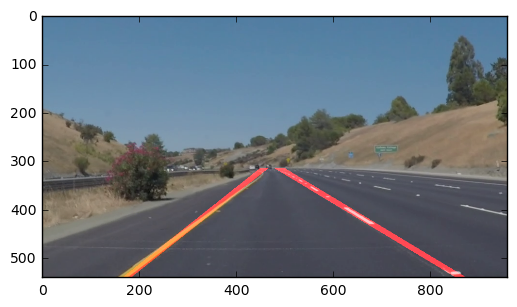

In [14]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge


Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

 # For the Optional Challenge, I redefined some of the functions, rather than change them in previous cells so that I can experiment without breaking functions that previously worked.
 

In [17]:
import matplotlib
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy import *
from IPython.display import HTML
import numpy as np
import cv2
import matplotlib.pyplot as plt

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
def pipeline(image):  
    ### Params for region of interest
    bot_left = [250, 540]
    bot_right = [980, 540]
    apex_right = [510, 315]
    apex_left = [450, 315]
    v = [np.array([bot_left, bot_right, apex_right, apex_left], dtype=np.int32)]
    
    ### Run canny edge detection and mask region of interest
    gray = grayscale(image)
    blur = gaussian_blur(gray, 7)
    edge = canny(blur, 50, 125)
    mask = region_of_interest(edge, v)
    
    plt.imshow(mask)
    
    ### Run Hough Lines and separate by +/- slope
#    lines = cv2.HoughLinesP(mask, 0.8, np.pi/180, 25, np.array([]), minLineLength=10, maxLineGap=400)
    lines = cv2.HoughLinesP(mask, 2, np.pi/180, 10, np.array([]), minLineLength=10, maxLineGap=400)

    right_lines, left_lines = separate_lines(lines)
    right = reject_outliers(right_lines,  cutoff=(0.45, 0.75))
    right = merge_lines(right)
    
    left = reject_outliers(left_lines, cutoff=(-0.85, -0.6))
    left = merge_lines(left)

    lines = np.concatenate((right, left))
    
    ### Draw lines and return final image 
    line_img = np.copy((image)*0)
    draw_lines(line_img, lines, thickness=10)
    
    line_img = region_of_interest(line_img, v)
    final = weighted_img(line_img, image)

    

    return final

def extend_point(x1, y1, x2, y2, length):
    """ Takes line endpoints and extroplates new endpoint by a specfic length"""
    line_len = np.sqrt((x1 - x2)**2 + (y1 - y2)**2) 
    x = x2 + (x2 - x1) / line_len * length
    y = y2 + (y2 - y1) / line_len * length
    return x, y

def reject_outliers2(data, cutoff, thresh=0.08):
    """Reduces jitter by rejecting lines based on a hard cutoff range and outlier slope """
    data = np.array(data)
    data = data[(data[:, 4] >= cutoff[0]) & (data[:, 4] <= cutoff[1])]
    m = np.mean(data[:, 4], axis=0)
    return data[(data[:, 4] <= m+thresh) & (data[:, 4] >= m-thresh)]



def merge_lines(lines):
    """Merges all Hough lines by the mean of each endpoint, 
       then extends them off across the image"""
    global set_last_data
    global x1_last
    global x2_last
    global y1_last
    global y2_last
    
    
    
    lines = np.array(lines)[:, :4] ## Drop last column (slope)
    
    
#    x1,y1,x2,y2 = np.mean(lines, axis=0)
    x1,y1,x2,y2 = np.median(lines, axis=0)
    


    print ('x1', x1)
    print ('x2', x2)
    print ('y1', y1)
    print ('y2', y2)
    
    if (set_last_data):
        x1_last = x1
        x2_last = x2
        y1_last = y1
        y2_last = y2
        set_last_data = False
        
    if (not np.isnan(x1)):
        x1_last = x1
    if (not np.isnan(x2)):
        x2_last = x2
    if (not np.isnan(y1)):
        y1_last = y1
    if (not np.isnan(y2)):
        y2_last = y2
    
    if (np.isnan(x1)):
      print ('x1 NaN', x1)
      x1 = x1_last
    if (np.isnan(x2)):
      print ('x2 NaN', x2)
      x2 = x2_last
    if (np.isnan(y1)):
      print ('y1 NaN', y1)
      y1 = y1_last
    if (np.isnan(y2)):
      print ('y2 Nan', y2)
      y2 = y2_last

    
    
    x1e, y1e = extend_point(x1,y1,x2,y2, -1000) # bottom point
    x2e, y2e = extend_point(x1,y1,x2,y2, 1000)  # top point
    
    line = np.array([[x1e,y1e,x2e,y2e]]) 
    
    return np.array([line], dtype=np.int32)

##############################################


global x1_last
global x2_last
global y1_last
global y2_last
global set_last_data

check_data = True
x1_last = None
x2_last = None
y1_last = None
y2_last = None



def pipeline2(image, preview=False):

    
    bot_left = [300, 660]
    bot_right = [1100, 660]
    apex_right = [725, 440]
    apex_left = [580, 440]
    
    v = [np.array([bot_left, bot_right, apex_right, apex_left], dtype=np.int32)]
    
    ### Added a color mask to deal with shaded region
    color_low = np.array([187,187,0])
    color_high = np.array([255,255,255])


    color_mask = cv2.inRange(image, color_low, color_high)
    
    gray = grayscale(image)
    blur = gaussian_blur(gray, 7)
    blur = weighted_img(blur, color_mask)

    edge = cv2.Canny(blur, 50, 125)
    mask = region_of_interest(edge, v)
    
    plt.imshow(mask)

    lines = cv2.HoughLinesP(mask, 0.5, np.pi/180, 10, np.array([]), minLineLength=90, maxLineGap=200)

    
    right_lines, left_lines = separate_lines(lines)

    right = reject_outliers2(right_lines, cutoff=(0.45, 0.75))
    right = merge_lines(right)


    left = reject_outliers2(left_lines, cutoff=(-1.1, -0.2))
    left = merge_lines(left)
    
    lines = np.concatenate((right, left))
    line_img = np.copy((image)*0)
    draw_lines(line_img, lines, thickness=10)
    
    line_img = region_of_interest(line_img, v)
    final = weighted_img(line_img, image)
    
    return final
    
def process_image2(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = pipeline2(image)
    return result
#################
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)



def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def separate_lines(lines):
    """ Takes an array of hough lines and separates them by +/- slope.
        The y-axis is inverted in matplotlib, so the calculated positive slopes will be right
        lane lines and negative slopes will be left lanes. """
    right = []
    left = []
    for x1,y1,x2,y2 in lines[:, 0]:
        m = (float(y2) - y1) / (x2 - x1)
        if m >= 0: 
            right.append([x1,y1,x2,y2,m])
        else:
            left.append([x1,y1,x2,y2,m])
    
    return right, left

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


x1 723.0
x2 1042.0
y1 453.0
y2 659.0
x1 334.0
x2 584.5
y1 633.0
y2 467.5
[MoviePy] >>>> Building video extra_CHALLENGE_output.mp4
[MoviePy] Writing video extra_CHALLENGE_output.mp4


  0%|          | 1/251 [00:00<00:46,  5.37it/s]

x1 723.0
x2 1042.0
y1 453.0
y2 659.0
x1 334.0
x2 584.5
y1 633.0
y2 467.5


  1%|          | 2/251 [00:00<00:47,  5.22it/s]

x1 759.0
x2 1058.0
y1 481.0
y2 653.0
x1 338.5
x2 530.5
y1 629.5
y2 502.0


  1%|          | 3/251 [00:00<00:51,  4.85it/s]

x1 756.5
x2 1029.5
y1 478.5
y2 645.5
x1 336.5
x2 593.5
y1 631.0
y2 464.5


  2%|▏         | 4/251 [00:00<00:52,  4.70it/s]

x1 728.0
x2 881.0
y1 457.0
y2 557.0
x1 353.0
x2 633.5
y1 620.0
y2 442.0
x1 731.0
x2 911.0
y1 460.5
y2 575.0
x1 339.5
x2 612.0
y1 633.0
y2 452.0


  2%|▏         | 6/251 [00:01<00:45,  5.39it/s]

x1 725.0
x2 954.5
y1 455.5
y2 603.0
x1 320.5
x2 604.0
y1 654.0
y2 457.0
x1 724.5
x2 1013.0
y1 455.5
y2 635.0
x1 319.0
x2 613.0
y1 650.0
y2 451.0


  3%|▎         | 8/251 [00:01<00:44,  5.41it/s]

x1 726.5
x2 873.5
y1 456.5
y2 551.0
x1 383.0
x2 599.0
y1 612.0
y2 459.5
x1 721.0
x2 908.0
y1 452.0
y2 569.0
x1 337.5
x2 571.0
y1 645.0
y2 477.5


  4%|▍         | 11/251 [00:02<00:42,  5.64it/s]

x1 730.0
x2 940.0
y1 461.0
y2 592.0
x1 328.5
x2 566.5
y1 659.5
y2 481.0
x1 747.0
x2 998.0
y1 474.0
y2 625.0
x1 364.0
x2 625.5
y1 625.0
y2 446.0


  5%|▌         | 13/251 [00:02<00:39,  6.01it/s]

x1 735.0
x2 1045.5
y1 465.0
y2 655.0
x1 330.0
x2 611.0
y1 659.0
y2 452.0
x1 732.5
x2 1045.0
y1 462.5
y2 659.0
x1 340.0
x2 609.0
y1 651.0
y2 453.0


  6%|▌         | 15/251 [00:02<00:38,  6.09it/s]

x1 757.5
x2 1058.5
y1 478.0
y2 658.0
x1 329.0
x2 580.0
y1 660.0
y2 471.0
x1 755.0
x2 1059.5
y1 477.0
y2 659.0
x1 330.0
x2 589.5
y1 659.0
y2 464.5


  7%|▋         | 17/251 [00:03<00:37,  6.31it/s]

x1 736.0
x2 887.0
y1 464.0
y2 559.0
x1 329.5
x2 590.0
y1 660.0
y2 463.5
x1 751.0
x2 918.0
y1 477.0
y2 578.0
x1 401.0
x2 573.0
y1 606.0
y2 474.0


  8%|▊         | 19/251 [00:03<00:36,  6.33it/s]

x1 757.0
x2 964.0
y1 479.0
y2 607.0
x1 330.5
x2 550.5
y1 659.5
y2 489.5
x1 736.0
x2 1025.0
y1 466.0
y2 642.0
x1 339.0
x2 542.0
y1 654.0
y2 495.0


  8%|▊         | 21/251 [00:03<00:33,  6.95it/s]

x1 741.5
x2 866.5
y1 471.0
y2 547.0
x1 330.0
x2 570.0
y1 659.0
y2 477.0
x1 743.0
x2 907.5
y1 472.5
y2 570.5
x1 332.0
x2 576.0
y1 658.0
y2 473.0


  9%|▉         | 23/251 [00:03<00:32,  7.11it/s]

x1 744.0
x2 950.0
y1 471.0
y2 596.0
x1 327.5
x2 571.0
y1 658.0
y2 475.0
x1 752.0
x2 991.5
y1 479.0
y2 628.5
x1 328.5
x2 573.5
y1 659.0
y2 474.5


 10%|▉         | 25/251 [00:04<00:31,  7.29it/s]

x1 760.0
x2 1042.0
y1 485.0
y2 660.0
x1 328.0
x2 574.0
y1 660.0
y2 474.0
x1 790.5
x2 1051.5
y1 505.0
y2 659.0
x1 327.0
x2 570.0
y1 659.0
y2 476.0


 10%|█         | 26/251 [00:04<00:30,  7.49it/s]

x1 760.5
x2 1041.5
y1 484.5
y2 659.5
x1 329.0
x2 566.0
y1 659.0
y2 479.0
x1 755.5
x2 1040.5
y1 479.5
y2 653.0
x1 312.0
x2 510.0
y1 657.5
y2 514.5
x1 753.0


 12%|█▏        | 29/251 [00:04<00:26,  8.26it/s]

x2 888.0
y1 477.5
y2 562.5
x1 328.0
x2 545.5
y1 659.0
y2 491.0
x1 743.0
x2 917.0
y1 470.5
y2 582.5
x1 325.5
x2 548.5
y1 654.0
y2 490.5
x1 759.0
x2 964.0
y1 481.0
y2 613.0
x1 324.0
x2 555.0
y1 660.0
y2 485.0
x1 727.0
x2 850.0
y1

 13%|█▎        | 32/251 [00:04<00:26,  8.19it/s]

 459.0
y2 544.0
x1 343.5
x2 553.5
y1 655.5
y2 488.0
x1 724.0
x2 874.0
y1 455.5
y2 556.5
x1 312.5
x2 529.5
y1 659.5
y2 501.5


 14%|█▎        | 34/251 [00:05<00:26,  8.19it/s]

x1 743.0
x2 913.0
y1 472.0
y2 578.5
x1 358.5
x2 542.0
y1 628.5
y2 493.5
x1 745.0
x2 954.0
y1 473.0
y2 604.0
x1 376.0
x2 596.0
y1 608.0
y2 461.0


 14%|█▍        | 36/251 [00:05<00:25,  8.36it/s]

x1 734.5
x2 999.0
y1 466.0
y2 638.0
x1 352.0
x2 596.0
y1 634.0
y2 462.0
x1 744.5
x2 1007.5
y1 474.5
y2 637.5
x1 358.5
x2 557.5
y1 624.0
y2 486.0


 15%|█▌        | 38/251 [00:05<00:26,  8.15it/s]

x1 765.5
x2 1023.5
y1 489.0
y2 645.5
x1 338.0
x2 575.0
y1 633.0
y2 475.0
x1 729.5
x2 1028.0
y1 462.5
y2 648.5
x1 329.0
x2 545.0
y1 637.0
y2 493.0


 16%|█▌        | 40/251 [00:05<00:24,  8.71it/s]

x1 749.5
x2 869.5
y1 476.0
y2 550.5
x1 327.0
x2 545.5
y1 645.0
y2 492.5
x1 731.0
x2 898.0
y1 463.0
y2 568.0
x1 351.0
x2 575.0
y1 627.5
y2 475.0
x1 

 17%|█▋        | 42/251 [00:06<00:22,  9.11it/s]

733.5
x2 930.5
y1 465.5
y2 590.0
x1 349.0
x2 606.0
y1 622.0
y2 456.0
x1 746.0
x2 983.0
y1 472.0
y2 619.0
x1 334.0
x2 597.0
y1 636.0
y2 461.0


 18%|█▊        | 44/251 [00:06<00:25,  8.18it/s]

x1 738.0
x2 1043.0
y1 468.0
y2 659.0
x1 325.0
x2 598.0
y1 644.0
y2 462.0
x1 724.0
x2 819.0
y1 455.0
y2 519.0
x1 338.5
x2 595.5
y1 634.0
y2 462.5


 18%|█▊        | 46/251 [00:06<00:24,  8.26it/s]

x1 732.0
x2 906.0
y1 463.0
y2 578.0
x1 331.0
x2 604.0
y1 642.5
y2 458.0
x1 746.0
x2 973.0
y1 475.0
y2 612.0
x1 323.0
x2 600.0
y1 653.0
y2 460.5


 19%|█▉        | 48/251 [00:06<00:24,  8.45it/s]

x1 752.0
x2 1029.0
y1 479.0
y2 648.0
x1 367.0
x2 611.0
y1 626.0
y2 455.0
x1 756.0
x2 1045.0
y1 481.5
y2 658.5
x1 322.0
x2 591.0
y1 660.0
y2 467.0


 20%|█▉        | 50/251 [00:07<00:23,  8.70it/s]

x1 742.0
x2 1044.0
y1 471.0
y2 656.0
x1 323.5
x2 593.0
y1 660.0
y2 464.5
x1 765.0
x2 1028.0
y1 486.0
y2 647.0
x1 330.5
x2 586.0
y1 652.5
y2 469.5


 21%|██        | 52/251 [00:07<00:24,  8.25it/s]

x1 749.0
x2 879.0
y1 475.0
y2 553.0
x1 330.0
x2 589.0
y1 657.5
y2 463.0
x1 739.0
x2 905.0
y1 467.0
y2 571.0
x1 335.0
x2 593.0
y1 646.0
y2 464.5


 22%|██▏       | 54/251 [00:07<00:24,  7.95it/s]

x1 736.5
x2 939.0
y1 463.0
y2 598.0
x1 344.0
x2 593.5
y1 638.5
y2 466.0
x1 738.0
x2 992.0
y1 465.0
y2 628.0
x1 325.0
x2 618.0
y1 656.0
y2 440.0


 22%|██▏       | 55/251 [00:07<00:24,  7.99it/s]

x1 732.0
x2 873.5
y1 460.0
y2 551.5
x1 331.0
x2 624.0
y1 654.5
y2 441.0
x1 745.0
x2 902.5
y1 471.0
y2 566.0
x1 374.5
x2 622.5
y1 623.5
y2 442.0
x1 747.0
x2 

 23%|██▎       | 57/251 [00:07<00:22,  8.77it/s]

940.0
y1 472.0
y2 589.0
x1 328.0
x2 558.0
y1 659.5
y2 486.5
x1 750.0
x2 985.0
y1 474.5
y2 620.0
x1 329.0
x2 596.0
y1 659.0
y2 464.0
x1 767.0
x2 1050.0
y1 487.0
y2 659.0
x1 327.5
x2 615.5
y1 660.0
y2 443.0


 24%|██▍       | 61/251 [00:08<00:18, 10.10it/s]

x1 765.0
x2 1042.0
y1 483.5
y2 659.5
x1 348.0
x2 575.5
y1 639.5
y2 477.0
x1 765.5
x2 1034.5
y1 485.0
y2 648.5
x1 324.0
x2 614.0
y1 660.0
y2 443.0
x1 740.0
x2 1044.0
y1 459.0
y2 660.0
x1 378.0
x2 611.0
y1 619.0
y2 442.5


 26%|██▌       | 65/251 [00:08<00:16, 10.99it/s]

x1 715.5
x2 883.5
y1 446.5
y2 557.0
x1 336.5
x2 620.0
y1 637.5
y2 443.0
x1 728.0
x2 914.0
y1 455.0
y2 575.0
x1 387.0
x2 611.0
y1 605.5
y2 443.5
x1 712.0
x2 954.5
y1 442.0
y2 601.0
x1 368.5
x2 633.0
y1 616.5
y2 442.5


 27%|██▋       | 67/251 [00:08<00:15, 11.68it/s]

x1 732.0
x2 1011.0
y1 458.0
y2 635.0
x1 317.0
x2 620.5
y1 659.5
y2 444.0
x1 718.5
x2 872.0
y1 445.0
y2 552.0
x1 321.0
x2 619.0
y1 660.0
y2 445.0
x1 721.0
x2 919.0
y1 449.0
y2 574.0
x1 324.0
x2 619.5
y1 659.5
y2 446.0


 27%|██▋       | 69/251 [00:08<00:15, 11.43it/s]

x1 720.5
x2 952.5
y1 448.0
y2 597.0
x1 325.5
x2 619.5
y1 659.5
y2 446.0
x1 738.0
x2 1005.0
y1 462.5
y2 629.5
x1 329.5
x2 583.0
y1 659.5
y2 474.5
x1 705.0
x2 1052.0
y1 446.0
y2 658.0
x1 332.0
x2 616.0
y1 659.0
y2 448.0


 29%|██▉       | 73/251 [00:09<00:15, 11.57it/s]

x1 720.5
x2 1056.5
y1 451.5
y2 660.0
x1 342.5
x2 615.0
y1 645.5
y2 449.0
x1 724.0
x2 1049.0
y1 453.0
y2 653.0
x1 337.0
x2 614.5
y1 659.0
y2 450.0
x1 723.5
x2 968.0
y1 451.0
y2 600.5
x1 339.0
x2 613.0
y1 660.0
y2 451.0


 31%|███       | 77/251 [00:09<00:14, 11.76it/s]

x1 726.0
x2 902.0
y1 455.0
y2 562.0
x1 337.0
x2 613.5
y1 659.5
y2 452.0
x1 719.0
x2 945.0
y1 450.0
y2 583.0
x1 342.0
x2 614.0
y1 659.0
y2 453.0
x1 724.0
x2 916.0
y1 452.0
y2 571.0
x1 343.0
x2 615.0
y1 660.0
y2 454.0


 31%|███▏      | 79/251 [00:09<00:14, 12.03it/s]

x1 731.0
x2 1052.0
y1 460.0
y2 647.0
x1 347.0
x2 613.5
y1 657.5
y2 455.0
x1 719.0
x2 896.0
y1 453.0
y2 558.0
x1 401.0
x2 617.5
y1 618.0
y2 441.5
x1 722.5
x2 937.5
y1 453.0
y2 579.0
x1 427.5
x2 621.5
y1 586.0
y2 441.0


 33%|███▎      | 83/251 [00:10<00:14, 11.96it/s]

x1 735.0
x2 985.0
y1 463.0
y2 604.0
x1 351.0
x2 606.0
y1 655.0
y2 458.0
x1 719.0
x2 1017.0
y1 455.0
y2 629.0
x1 350.0
x2 609.0
y1 659.0
y2 456.0
x1 816.5
x2 1080.5
y1 514.5
y2 660.0
x1 355.0
x2 603.0
y1 654.5
y2 460.5


 34%|███▍      | 85/251 [00:10<00:14, 11.52it/s]

x1 730.0
x2 1074.5
y1 458.0
y2 653.5
x1 364.0
x2 608.0
y1 641.0
y2 457.5
x1 726.0
x2 1068.0
y1 459.0
y2 658.0
x1 348.0
x2 625.0
y1 657.5
y2 447.0
x1 716.0
x2 885.0
y1 448.0
y2 553.0
x1 349.5
x2 596.5
y1 657.5
y2 462.0


 35%|███▍      | 87/251 [00:10<00:14, 11.05it/s]

x1 727.0
x2 910.0
y1 459.0
y2 569.0
x1 347.5
x2 628.5
y1 656.0
y2 443.0
x1 724.0
x2 947.0
y1 457.0
y2 593.0
x1 388.5
x2 631.5
y1 632.0
y2 440.0


 35%|███▌      | 89/251 [00:10<00:15, 10.52it/s]

x1 717.0
x2 1004.0
y1 450.0
y2 623.0
x1 346.0
x2 630.5
y1 659.0
y2 441.5
x1 734.0
x2 877.0
y1 465.0
y2 548.0
x1 350.0
x2 625.0
y1 658.0
y2 441.0
x1 719.0
x2 910.5
y1 453.5
y2 566.5
x1 354.5
x2 622.0
y1 659.0
y2 453.0


 37%|███▋      | 93/251 [00:10<00:14, 10.83it/s]

x1 716.5
x2 943.5
y1 450.5
y2 586.0
x1 349.0
x2 608.0
y1 659.0
y2 452.0
x1 737.0
x2 1003.0
y1 470.0
y2 614.0
x1 357.0
x2 621.5
y1 650.5
y2 442.5
x1 721.0
x2 1071.0
y1 455.0
y2 653.0
x1 353.0
x2 617.0
y1 653.0
y2 444.0


 38%|███▊      | 95/251 [00:11<00:13, 11.21it/s]

x1 740.0
x2 1063.5
y1 467.5
y2 653.0
x1 356.0
x2 617.5
y1 653.0
y2 443.0
x1 743.0
x2 1072.5
y1 482.5
y2 656.5
x1 364.0
x2 614.0
y1 649.0
y2 443.0
x1 723.5
x2 1074.5
y1 459.5
y2 660.0
x1 349.0
x2 623.0
y1 621.5
y2 450.5


 39%|███▉      | 99/251 [00:11<00:14, 10.57it/s]

x1 714.0
x2 1043.0
y1 449.0
y2 643.0
x1 358.5
x2 615.5
y1 654.0
y2 445.5
x1 724.0
x2 885.0
y1 458.0
y2 553.0
x1 352.0
x2 619.0
y1 658.0
y2 440.0


 40%|████      | 101/251 [00:11<00:14, 10.62it/s]

x1 729.0
x2 912.0
y1 467.0
y2 570.0
x1 356.5
x2 608.5
y1 653.0
y2 444.0
x1 730.0
x2 954.5
y1 466.5
y2 593.5
x1 386.0
x2 597.0
y1 602.0
y2 443.0


 41%|████      | 103/251 [00:11<00:13, 10.70it/s]

x1 728.5
x2 929.0
y1 460.5
y2 578.0
x1 364.0
x2 608.0
y1 641.0
y2 443.0
x1 721.0
x2 880.0
y1 451.0
y2 549.0
x1 439.0
x2 620.0
y1 558.0
y2 441.5
x1 744.5
x2 906.0
y1 480.0
y2 565.5
x1 376.5
x2 641.5
y1 615.0
y2 444.0


 42%|████▏     | 105/251 [00:12<00:14, 10.30it/s]

x1 686.0
x2 927.0
y1 440.0
y2 583.0
x1 402.0
x2 615.0
y1 589.5
y2 441.0
x1 716.0
x2 981.0
y1 453.0
y2 615.0
x1 354.0
x2 624.0
y1 633.0
y2 444.0
x1

 43%|████▎     | 109/251 [00:12<00:14,  9.76it/s]

 676.0
x2 1056.0
y1 441.0
y2 652.0
x1 334.5
x2 612.5
y1 646.0
y2 441.0
x1 654.0
x2 1058.0
y1 441.0
y2 653.0
x1 380.5
x2 599.0
y1 618.5
y2 448.0
x1 718.0
x2 1007.0
y1 449.0
y2 634.0
x1 372.0
x2 613.0
y1 606.0
y2 443.0


 44%|████▍     | 110/251 [00:12<00:14,  9.57it/s]

x1 711.0
x2 1043.0
y1 449.0
y2 654.0
x1 343.0
x2 600.0
y1 647.0
y2 442.0
x1 704.0
x2 1038.5
y1 440.0
y2 653.5
x1 355.0
x2 594.0
y1 644.5
y2 443.5
x1 771.0
x2 1033.5
y1 493.0
y2 643.0
x1 363.0
x2 613.0
y1 641.0
y2 442.0


 45%|████▌     | 114/251 [00:13<00:13, 10.23it/s]

x1 769.5
x2 1014.0
y1 484.5
y2 637.0
x1 380.0
x2 614.0
y1 616.0
y2 441.0
x1 772.0
x2 995.0
y1 486.0
y2 633.0
x1 411.0
x2 605.0
y1 599.0
y2 443.0
x1 722.0
x2 954.0
y1 448.0
y2 593.0
x1 381.0
x2 602.0
y1 616.0
y2 442.0


 47%|████▋     | 118/251 [00:13<00:12, 10.36it/s]

x1 723.0
x2 1061.0
y1 445.5
y2 653.5
x1 390.0
x2 614.5
y1 612.0
y2 445.0
x1 694.5
x2 999.5
y1 443.5
y2 608.0
x1 380.0
x2 603.0
y1 623.0
y2 448.0
x1 746.0
x2 991.0
y1 472.0
y2 599.0
x1 387.0
x2 596.0
y1 650.0
y2 481.0


 48%|████▊     | 120/251 [00:13<00:12, 10.50it/s]

x1 708.5
x2 997.0
y1 448.0
y2 615.0
x1 326.0
x2 599.0
y1 659.0
y2 440.0
x1 710.0
x2 968.0
y1 448.0
y2 607.0
x1 375.0
x2 595.5
y1 635.0
y2 449.5
x1 721.0
x2 1029.0
y1 455.0
y2 638.0
x1 351.0
x2 593.5
y1 646.0
y2 440.5


 49%|████▉     | 124/251 [00:13<00:10, 11.86it/s]

x1 749.5
x2 1049.0
y1 474.5
y2 659.0
x1 376.0
x2 588.0
y1 600.0
y2 457.0
x1 754.0
x2 1044.0
y1 479.0
y2 659.0
x1 406.0
x2 552.0
y1 597.0
y2 478.0
x1 741.5
x2 1027.5
y1 468.5
y2 645.5
x1 390.5
x2 575.5
y1 588.5
y2 463.5


 50%|█████     | 126/251 [00:14<00:11, 10.99it/s]

x1 713.0
x2 858.0
y1 450.0
y2 546.0
x1 411.5
x2 589.0
y1 572.5
y2 452.0
x1 726.0
x2 861.5
y1 457.5
y2 556.0
x1 407.0
x2 553.0
y1 576.0
y2 476.0
x1 733.0
x2 918.5
y1 464.5
y2 583.0
x1 428.0
x2 610.0
y1 559.0
y2 440.5


 51%|█████     | 128/251 [00:14<00:10, 11.66it/s]

x1 719.0
x2 969.0
y1 455.0
y2 617.0
x1 418.0
x2 596.0
y1 567.0
y2 442.0
x1 722.0
x2 860.0
y1 450.0
y2 551.0
x1 420.5
x2 600.0
y1 565.5
y2 450.5
x1 719.0
x2 895.0
y1 454.0
y2 566.0
x1 440.0
x2 615.0
y1 551.0
y2 444.0


 53%|█████▎    | 132/251 [00:14<00:10, 11.50it/s]

x1 733.0
x2 923.5
y1 467.5
y2 590.5
x1 418.0
x2 583.0
y1 567.0
y2 460.0
x1 722.0
x2 975.0
y1 454.0
y2 621.0
x1 428.0
x2 583.0
y1 559.0
y2 459.0
x1 749.0
x2 1029.0
y1 475.5
y2 655.0
x1 446.0
x2 608.0
y1 545.0
y2 448.0


 53%|█████▎    | 134/251 [00:14<00:09, 11.75it/s]

x1 728.0
x2 1032.0
y1 455.0
y2 659.0
x1 nan
x2 nan
y1 nan
y2 nan
x1 NaN nan
x2 NaN nan
y1 NaN nan
y2 Nan nan
x1 732.0
x2 1036.0
y1 457.0
y2 658.0
x1 nan
x2 nan
y1 nan
y2 nan
x1 NaN nan
x2 NaN nan
y1 NaN nan
y2 Nan nan
x1 730.0
x2 1026.0
y1 462.0
y2 647.0
x1 480.5
x2 595.0
y1 530.0
y2 456.0


 55%|█████▍    | 138/251 [00:15<00:09, 11.35it/s]

x1 726.0
x2 891.0
y1 462.0
y2 563.0
x1 527.0
x2 643.0
y1 486.0
y2 441.0
x1 752.0
x2 917.5
y1 480.5
y2 586.0
x1 nan
x2 nan
y1 nan
y2 nan
x1 NaN nan
x2 NaN nan
y1 NaN nan
y2 Nan nan
x1 731.0
x2 903.5
y1 467.0
y2 577.0
x1 510.0
x2 611.0
y1 512.5
y2 452.0


 56%|█████▌    | 140/251 [00:15<00:09, 11.16it/s]

x1 733.0
x2 840.0
y1 467.0
y2 541.0
x1 516.0
x2 632.0
y1 500.0
y2 446.0
x1 737.0
x2 877.0
y1 471.0
y2 565.0
x1 535.0
x2 635.0
y1 494.0
y2 443.0
x1 739.0
x2 913.0
y1 473.0
y2 586.0
x1 489.0
x2 621.0
y1 517.5
y2 447.0


 57%|█████▋    | 144/251 [00:15<00:09, 11.07it/s]

x1 743.0
x2 959.0
y1 475.0
y2 614.0
x1 480.0
x2 624.0
y1 521.0
y2 445.0
x1 748.0
x2 1021.0
y1 479.0
y2 654.0
x1 472.0
x2 604.0
y1 525.5
y2 453.5


 58%|█████▊    | 146/251 [00:15<00:09, 10.75it/s]

x1 753.0
x2 1028.5
y1 483.5
y2 659.5
x1 481.0
x2 607.5
y1 524.0
y2 453.5
x1 761.0
x2 1020.0
y1 489.5
y2 650.5
x1 451.0
x2 619.0
y1 545.0
y2 452.0
x1 764.0
x2 1028.0
y1 493.0
y2 660.0
x1 441.0
x2 599.0
y1 549.5
y2 459.0


 60%|█████▉    | 150/251 [00:16<00:09, 11.14it/s]

x1 772.0
x2 890.5
y1 497.0
y2 571.5
x1 421.5
x2 594.0
y1 564.5
y2 461.0
x1 756.0
x2 929.5
y1 487.5
y2 599.5
x1 426.0
x2 581.0
y1 561.0
y2 468.0
x1 787.0
x2 979.0
y1 509.0
y2 632.0
x1 nan
x2 nan
y1 nan
y2 nan
x1 NaN nan
x2 NaN nan
y1 NaN nan
y2 Nan nan


 61%|██████    | 152/251 [00:16<00:08, 11.15it/s]

x1 761.0
x2 1027.5
y1 489.5
y2 656.5
x1 409.0
x2 593.0
y1 576.0
y2 461.0
x1 729.0
x2 892.5
y1 460.5
y2 575.5
x1 428.5
x2 540.5
y1 559.0
y2 489.5
x1 776.5
x2 939.0
y1 500.0
y2 600.0
x1 437.5
x2 579.0
y1 552.0
y2 467.5


 62%|██████▏   | 156/251 [00:16<00:08, 11.79it/s]

x1 854.0
x2 985.5
y1 552.5
y2 632.5
x1 389.0
x2 575.0
y1 591.0
y2 470.0
x1 802.0
x2 1018.0
y1 512.0
y2 652.0
x1 494.0
x2 636.0
y1 510.0
y2 444.0
x1 768.0
x2 1015.0
y1 493.0
y2 655.0
x1 403.5
x2 564.0
y1 580.5
y2 475.5


 63%|██████▎   | 158/251 [00:16<00:08, 11.44it/s]

x1 745.0
x2 1014.0
y1 471.0
y2 655.0
x1 385.5
x2 546.0
y1 593.0
y2 486.0
x1 730.0
x2 856.0
y1 457.5
y2 545.5
x1 500.5
x2 630.5
y1 507.0
y2 442.5
x1 751.5
x2 880.0
y1 475.0
y2 561.0
x1 480.0
x2 600.0
y1 520.0
y2 458.0


 64%|██████▎   | 160/251 [00:17<00:07, 12.06it/s]

x1 755.5
x2 911.5
y1 477.0
y2 582.0
x1 468.0
x2 606.0
y1 528.0
y2 451.0
x1 723.5
x2 951.5
y1 452.5
y2 612.0
x1 474.0
x2 634.0
y1 524.0
y2 443.0
x1 737.0
x2 1011.0
y1 464.5
y2 651.5
x1 474.0
x2 629.0
y1 523.0
y2 447.0


 65%|██████▍   | 162/251 [00:17<00:07, 11.83it/s]

x1 721.0
x2 869.0
y1 450.0
y2 556.0
x1 468.0
x2 628.5
y1 528.0
y2 444.5
x1 723.0
x2 900.0
y1 454.0


 65%|██████▌   | 164/251 [00:17<00:09,  9.21it/s]

y2 578.0
x1 454.0
x2 636.0
y1 540.0
y2 444.0
x1 740.5
x2 948.5
y1 470.5
y2 608.5
x1 441.0
x2 646.0
y1 549.0
y2 443.0


 67%|██████▋   | 168/251 [00:17<00:08, 10.14it/s]

x1 744.0
x2 1011.0
y1 474.0
y2 648.0
x1 422.5
x2 639.0
y1 565.5
y2 445.0
x1 755.0
x2 1023.0
y1 483.0
y2 659.0
x1 385.0
x2 609.0
y1 593.0
y2 460.0
x1 761.0
x2 1020.0
y1 488.0
y2 654.0
x1 391.5
x2 612.0
y1 588.0
y2 458.5


 68%|██████▊   | 170/251 [00:18<00:07, 10.73it/s]

x1 748.0
x2 936.5
y1 480.0
y2 601.5
x1 392.0
x2 630.0
y1 587.5
y2 451.5
x1 730.0
x2 870.0
y1 467.0
y2 559.0
x1 366.0
x2 618.0
y1 608.0
y2 458.0
x1 728.0
x2 899.0
y1 466.5
y2 580.0
x1 343.0
x2 587.0
y1 627.0
y2 476.0


 69%|██████▊   | 172/251 [00:18<00:07, 10.21it/s]

x1 733.0
x2 934.0
y1 472.0
y2 602.0
x1 374.5
x2 620.0
y1 614.0
y2 458.0
x1 735.0
x2 992.0
y1 470.0
y2 633.0
x1 314.0
x2 569.0
y1 658.0
y2 484.0
x1 738.0
x2 872.0
y1 469.0
y2 553.0
x1 322.5
x2 564.5
y1 642.0
y2 485.0


 70%|███████   | 176/251 [00:18<00:08,  8.66it/s]

x1 740.0
x2 892.5
y1 468.5
y2 568.0
x1 339.0
x2 596.0
y1 629.0
y2 467.0
x1 746.0
x2 937.0
y1 473.0
y2 591.0
x1 352.0
x2 586.0
y1 619.0
y2 468.0


 71%|███████   | 178/251 [00:19<00:08,  8.80it/s]

x1 793.0
x2 984.0
y1 503.0
y2 623.0
x1 345.0
x2 593.0
y1 625.0
y2 465.0
x1 752.0
x2 1039.5
y1 474.5
y2 658.0
x1 331.0
x2 544.0
y1 640.0
y2 494.0


 71%|███████▏  | 179/251 [00:19<00:08,  8.70it/s]

x1 758.5
x2 1064.5
y1 483.0
y2 660.0
x1 316.0
x2 558.0
y1 651.0
y2 487.0
x1 745.0
x2 1040.5
y1 471.0
y2 658.0
x1 316.0
x2 592.0
y1 656.0
y2 466.0
x1 730.0
x2 1036.0
y1 457.0
y2 655.0
x1 318.0
x2 589.0
y1 648.0
y2 467.0


 73%|███████▎  | 182/251 [00:19<00:07,  8.85it/s]

x1 753.0
x2 884.5
y1 475.5
y2 560.0
x1 320.0
x2 557.0
y1 650.0
y2 488.0
x1 739.0
x2 918.0
y1 464.0
y2 580.0
x1 348.0
x2 612.0
y1 638.0
y2 453.0


 73%|███████▎  | 184/251 [00:19<00:07,  9.21it/s]

x1 790.0
x2 965.0
y1 500.0
y2 606.0
x1 335.5
x2 608.5
y1 647.0
y2 455.5
x1 741.0
x2 1030.0
y1 467.5
y2 644.0
x1 341.0
x2 629.0
y1 633.5
y2 447.5
x1 742.0
x2 889.0
y1 467.0
y2 555.0
x1 322.0
x2 611.0
y1 656.0
y2 454.0


 75%|███████▍  | 188/251 [00:20<00:06,  9.57it/s]

x1 745.0
x2 865.0
y1 471.0
y2 552.0
x1 328.5
x2 594.0
y1 660.0
y2 468.0
x1 819.5
x2 958.5
y1 520.5
y2 602.0
x1 354.0
x2 604.0
y1 644.0
y2 461.0
x1 753.0
x2 1022.0
y1 475.0
y2 638.0
x1 336.5
x2 611.0
y1 657.5
y2 456.5


 76%|███████▋  | 192/251 [00:20<00:05, 10.14it/s]

x1 815.0
x2 1041.0
y1 516.0
y2 641.0
x1 336.5
x2 579.0
y1 659.5
y2 477.0
x1 762.0
x2 1051.0
y1 479.0
y2 651.0
x1 336.5
x2 583.5
y1 656.5
y2 472.5
x1 734.0
x2 1050.5
y1 457.5
y2 656.5
x1 355.0
x2 574.0
y1 634.0
y2 479.0


 77%|███████▋  | 194/251 [00:20<00:05, 10.06it/s]

x1 735.0
x2 886.0
y1 459.0
y2 550.0
x1 342.0
x2 591.0
y1 657.0
y2 468.0
x1 739.0
x2 912.0
y1 462.0
y2 567.0
x1 342.5
x2 604.0
y1 656.5
y2 459.0
x1 730.0
x2 947.0
y1 453.0
y2 591.0
x1 340.0
x2 591.0
y1 

 78%|███████▊  | 196/251 [00:20<00:05, 10.27it/s]

660.0
y2 468.0
x1 731.0
x2 1001.0
y1 453.0
y2 620.0
x1 337.0
x2 550.0
y1 659.0
y2 494.0
x1 733.0
x2 1060.0
y1 457.0
y2 654.0
x1 340.0
x2 558.0
y1 660.0
y2 489.0


 79%|███████▉  | 198/251 [00:21<00:05, 10.33it/s]

x1 734.0
x2 911.0
y1 458.0
y2 563.0
x1 340.5
x2 538.0
y1 660.0
y2 503.5
x1 772.0
x2 943.5
y1 485.5
y2 586.0
x1 346.0
x2 611.0
y1 647.0
y2 455.0


 80%|███████▉  | 200/251 [00:21<00:05,  9.75it/s]

x1 752.0
x2 1001.0
y1 473.0
y2 617.0
x1 342.0
x2 591.0
y1 657.0
y2 469.0
x1 809.0
x2 1078.0
y1 510.0
y2 658.0
x1 343.0
x2 585.0
y1 658.0
y2 472.0


 80%|████████  | 202/251 [00:21<00:05,  9.76it/s]

x1 768.0
x2 1067.5
y1 485.5
y2 659.5
x1 345.0
x2 589.0
y1 655.0
y2 469.0
x1 839.5
x2 1068.0
y1 529.5
y2 656.5
x1 341.5
x2 574.5
y1 656.5
y2 478.0
x1 770.0
x2 1044.0
y1 486.0
y2 640.0
x1 340.0
x2 576.0
y1 660.0
y2 476.0


 82%|████████▏ | 206/251 [00:21<00:04, 10.46it/s]

x1 754.5
x2 889.0
y1 475.0
y2 560.0
x1 346.5
x2 571.5
y1 658.0
y2 481.0
x1 717.0
x2 818.5
y1 445.5
y2 519.5
x1 344.0
x2 522.0
y1 658.0
y2 515.0


 83%|████████▎ | 208/251 [00:22<00:04, 10.71it/s]

x1 726.0
x2 973.0
y1 457.0
y2 609.0
x1 350.5
x2 585.0
y1 655.5
y2 472.5
x1 733.5
x2 1034.5
y1 462.5
y2 642.5
x1 479.0
x2 621.5
y1 546.5
y2 451.0
x1 720.0
x2 881.5
y1 450.5
y2 556.0
x1 347.5
x2 586.0
y1 658.0
y2 471.5


 84%|████████▍ | 212/251 [00:22<00:03, 11.16it/s]

x1 723.0
x2 917.0
y1 455.0
y2 576.0
x1 377.5
x2 632.0
y1 630.0
y2 444.5
x1 734.0
x2 962.0
y1 464.0
y2 601.0
x1 349.0
x2 612.0
y1 659.0
y2 454.0
x1 806.0
x2 1027.0
y1 505.0
y2 634.0
x1 350.5
x2 607.5
y1 655.0
y2 454.5


 85%|████████▌ | 214/251 [00:22<00:03, 10.87it/s]

x1 760.0
x2 1065.0
y1 479.0
y2 660.0
x1 355.0
x2 615.0
y1 656.0
y2 451.0
x1 762.5
x2 1066.5
y1 479.0
y2 658.0
x1 349.5
x2 615.5
y1 659.0
y2 450.0
x1 730.0
x2 1041.0
y1 458.0
y2 645.0
x1 354.0
x2 593.0
y1 652.0
y2 465.0


 87%|████████▋ | 218/251 [00:22<00:02, 11.50it/s]

x1 752.5
x2 891.0
y1 474.0
y2 549.5
x1 361.5
x2 598.0
y1 655.0
y2 463.5
x1 733.5
x2 915.5
y1 460.5
y2 567.0
x1 358.0
x2 602.0
y1 657.0
y2 459.0
x1 735.0
x2 954.0
y1 463.0
y2 586.0
x1 355.0
x2 620.0
y1 658.0
y2 449.0


 88%|████████▊ | 220/251 [00:23<00:02, 12.31it/s]

x1 727.0
x2 1001.0
y1 455.0
y2 619.0
x1 345.0
x2 570.0
y1 657.0
y2 481.0
x1 729.0
x2 869.0
y1 456.0
y2 542.0
x1 341.0
x2 550.0
y1 659.0
y2 496.0
x1 744.0
x2 908.0
y1 471.0
y2 561.5
x1 352.5
x2 569.5
y1 659.5
y2 482.5


 88%|████████▊ | 222/251 [00:23<00:02, 11.67it/s]

x1 746.0
x2 941.0
y1 472.0
y2 583.5
x1 359.0
x2 573.0
y1 658.0
y2 479.0
x1 750.0
x2 999.0
y1 476.0
y2 615.0
x1 346.0
x2 555.0
y1 659.0
y2 493.0
x1 786.0
x2 1065.5
y1 500.0
y2 655.0
x1 357.5
x2 561.0
y1 657.5
y2 487.5


 90%|█████████ | 226/251 [00:23<00:02, 11.12it/s]

x1 765.0
x2 1072.0
y1 486.0
y2 660.0
x1 350.5
x2 565.0
y1 659.0
y2 484.0
x1 768.0
x2 1066.0
y1 490.0
y2 658.0
x1 345.0
x2 559.5
y1 658.5
y2 490.0
x1 748.0
x2 1051.5
y1 475.5
y2 653.5
x1 346.0
x2 550.0
y1 659.0
y2 498.0


 92%|█████████▏| 230/251 [00:23<00:01, 11.61it/s]

x1 733.5
x2 890.0
y1 464.0
y2 563.0
x1 346.0
x2 544.0
y1 657.0
y2 501.0
x1 733.5
x2 927.0
y1 463.5
y2 584.5
x1 356.0
x2 588.0
y1 657.0
y2 469.0
x1 735.0
x2 975.5
y1 463.5
y2 611.0
x1 351.0
x2 616.0
y1 659.0
y2 449.0


 92%|█████████▏| 232/251 [00:24<00:01, 11.23it/s]

x1 768.0
x2 1055.0
y1 486.0
y2 646.0
x1 354.0
x2 593.0
y1 658.0
y2 463.0
x1 740.0
x2 884.0
y1 466.0
y2 555.0
x1 349.5
x2 593.5
y1 659.5
y2 461.5
x1 728.0
x2 871.0
y1 452.5
y2 550.5
x1 347.0
x2 624.0
y1 658.0
y2 445.0


 93%|█████████▎| 234/251 [00:24<00:01, 11.43it/s]

x1 747.5
x2 966.0
y1 471.5
y2 603.0
x1 346.5
x2 612.0
y1 658.5
y2 449.5
x1 751.0
x2 1037.0
y1 472.0
y2 638.0
x1 349.0
x2 590.5
y1 659.0
y2 462.5
x1 818.0
x2 1060.0
y1 514.0
y2 660.0
x1 349.0
x2 589.0
y1 660.0
y2 464.0


 95%|█████████▍| 238/251 [00:24<00:01, 11.45it/s]

x1 772.0
x2 1045.0
y1 488.0
y2 652.0
x1 349.0
x2 589.0
y1 660.0
y2 465.0
x1 768.5
x2 1051.0
y1 482.5
y2 656.5
x1 348.0
x2 585.5
y1 654.5
y2 466.5
x1 740.0
x2 881.0
y1 463.0
y2 551.0
x1 358.0
x2 585.0
y1 654.0
y2 469.0


 96%|█████████▌| 240/251 [00:24<00:00, 11.62it/s]

x1 723.0
x2 909.0
y1 451.0
y2 572.0
x1 358.0
x2 579.0
y1 655.0
y2 473.0
x1 726.0
x2 952.0
y1 455.0
y2 596.0
x1 335.5
x2 568.0
y1 659.5
y2 480.0
x1 767.0
x2 1024.0
y1 486.0
y2 628.0
x1

 97%|█████████▋| 244/251 [00:25<00:00, 11.68it/s]

 330.0
x2 560.0
y1 660.0
y2 487.0
x1 730.0
x2 868.5
y1 458.0
y2 541.0
x1 348.0
x2 566.0
y1 660.0
y2 482.0
x1 744.0
x2 898.0
y1 471.0
y2 567.0
x1 346.5
x2 555.0
y1 660.0
y2 489.5
x1 789.0
x2 952.0
y1 499.5
y2 595.5
x1 345.5
x2 548.0
y1 658.0
y2 494.0


 99%|█████████▉| 248/251 [00:25<00:00, 11.30it/s]

x1 762.0
x2 1006.0
y1 484.0
y2 628.0
x1 344.5
x2 581.5
y1 659.5
y2 472.5
x1 757.0
x2 1046.0
y1 482.0
y2 656.0
x1 349.0
x2 525.5
y1 658.0
y2 510.5
x1 768.5
x2 1034.5
y1 489.0
y2 650.0
x1 344.0
x2 572.0
y1 658.5
y2 479.0


100%|██████████| 251/251 [00:25<00:00,  9.75it/s]

x1 766.0
x2 1047.0
y1 488.0
y2 658.0
x1 342.5
x2 563.0
y1 658.5
y2 485.5
x1 770.0
x2 1049.0
y1 488.0
y2 653.0
x1 337.5
x2 562.0
y1 659.5
y2 486.5
x1 731.0
x2 901.0
y1 462.0
y2 564.0
x1 344.0
x2 611.5
y1 652.5
y2 451.5


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra_CHALLENGE_output.mp4 

CPU times: user 18 s, sys: 4.98 s, total: 23 s
Wall time: 29.4 s


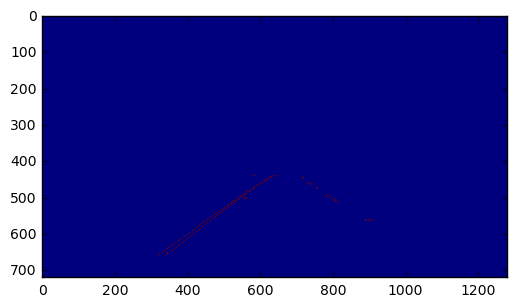

In [18]:
from moviepy.editor import VideoFileClip
from moviepy import *
from IPython.display import HTML
import numpy as np
import cv2
import matplotlib.pyplot as plt


challenge_output = 'extra_CHALLENGE_output.mp4'
clip3 = VideoFileClip('challenge.mp4')
challenge_clip = clip3.fl_image(process_image2)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# **Finding Lane Lines on the Road** 

The goals / steps of this project are the following:
* Make a pipeline that finds lane lines on the road
* Reflect on your work in a written report


### Reflection

### 1. Describe your pipeline. As part of the description, explain how you modified the draw_lines() function.

My pipeline consisted of the following image processing helper functions:
# 1.  gray-scale
#  2.  Gaussian Blur
#  3.  Canny Edge
#  4.  masking
#  5.  Hough-Transform
#  After the images processing identifies the 
#  lane lines, then track previous data points and 
# use statistical functions to 
#  remove outliers, remove noise values and
#  extrapolate the lines



    Identify potential shortcomings with your current pipeline
    Suggest possible improvements to your pipeline
    
Regarding Finding the Lane Lines, there are a number of challenges. One challenge is based on color.  I chosed a single color mask that can detect both white and yellow lane lines. Since yellow lines are harder to detect, one improvement to my pipeline would be to use a separate, HSV-space color mask to isolate the yellow lane lines.

Another challenge is shadows.  Shadows make detecting the lane lines more difficult because the gradient changes are reduced to the point where the lines are "hidden" by the shadows and get masked out so they become harder to detect.  So even though my pipeline can detect lane lines where there is good lighting, it can briefly lose (for a couple of frames) lane lines in the shadows.  To improve the pipeline performance in detecting lane lines in shadows, refine the color mask by using HSV color space, rather than RGB. Another improvement would be to refine the Canny Edge and Hough Transform parameters to work with shadows.  This includes improving the Hough Transform voting scheme so that fewer number of votes are needed to identify lane lines hidden by shadows. 




